In [1]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
import umap
import hdbscan
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette('BuGn_r', n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [2]:
monthly_feeding = pd.read_excel('datasets/Ekoniva_dataset.xlsx', sheet_name='Feeding')
herd_metrics = pd.read_excel('datasets/Ekoniva_dataset.xlsx', sheet_name='Herd maintenance').replace('-', np.nan)
production_indicators = pd.read_excel('datasets/Ekoniva_dataset.xlsx', sheet_name='Dairy indicators').replace('-', np.nan)

In [3]:
out = pd.read_csv('out1.csv', index_col=0)

In [4]:
def rename_shit(dff):
    """Renames bad PhysiologicalGroupNames"""
    mapping = {'Д0 (Новотельные)': 'Д0', 'Н Нетели': 'Нетели', 'Д3 (Предзапуск)': 'Д3', 'D3': 'Д3', 
               'Нетели 1  группа': 'Нетели','Сух-2': "С2", 'Д-3': 'Д3', 'сух 1': 'С1', 'сух 2': 'С2', 'С1 нетели': 'С1', 
               'С2 нетели': 'С2', 'Н НЕТЕЛИ': 'Нетели', 'Сух 2 Нетели': 'С2', 'С2 Нетели': 'С2'}

    dff["PhysiologicalGroupName"] = dff["PhysiologicalGroupName"].replace(mapping)
    return dff

out = rename_shit(out)
out["PhysiologicalGroupName"].unique()

array(['Д0', 'Д1', 'Д2', 'Нетели', 'С1', 'С2', 'Т0 (0-2 мес.)',
       'Т1 (3-5 мес.)', 'Т2 (6-8 мес.)', 'Т3 (9-12 мес.)', 'Т4 (>1 года)',
       'Д3', 'Б0 (0-2 мес.)', 'Т3 9-12', 'Т0', 'Б3 (9-12 мес.)',
       'Т0 (3-5 мес.)', 'Т2', 'МГ Т3', 'Т2 6-8', 'Т4', 'Т3',
       'Б2 (6-8 мес.)', 'Б1 (3-5 мес.)', 'Т4 13-20', 'Телята СВОД Навесы',
       'МГ Т2', 'Т3 (9-12 мес)', 'МП Коровы', 'МП Нетели',
       'МП БП (бык-производитель)', 'Б4 (>1 года)',
       'МП Б1 (6-12 мес. откорм)', 'МП БР2 (>1 года рем.)',
       'МП Т2 (>1 года откорм)', 'МП БР1 (6-12 мес. рем.)',
       'МП ТР1 (6-12 мес. рем.)', 'Телята домики', 'МП Т0 (0-6 мес.)',
       'МП ТР2 (>1 года рем.)', 'МП Б0 (0-6 мес.)',
       'МП Б2 (>1 года откорм)', 'быки племенные', 'Лошади',
       'Т0 (0-2 мес)', 'Коровы'], dtype=object)

In [5]:
df = out.copy()

In [6]:
df

Date     FarmName PhysiologicalGroupName  \
0        2022-01-01   ЖК Добрино                     Д0   
1        2022-01-01   ЖК Добрино                     Д0   
2        2022-01-01   ЖК Добрино                     Д0   
3        2022-01-01   ЖК Добрино                     Д0   
4        2022-01-01   ЖК Добрино                     Д0   
...             ...          ...                    ...   
2235526  2025-10-22  РМ Торопово         Т3 (9-12 мес.)   
2235527  2025-10-22  РМ Торопово         Т3 (9-12 мес.)   
2235528  2025-10-22  РМ Торопово           Т4 (>1 года)   
2235529  2025-10-22  РМ Торопово           Т4 (>1 года)   
2235530  2025-10-22  РМ Торопово           Т4 (>1 года)   

                        ingredient_group  PhysicalWeight_kg  Appetite  \
0        compound_feed_calf_replacements            578.000       1.0   
1                          energy_source            493.000       1.0   
2                               fat_oils             23.079       1.0   
3                            forage_bulk           3675.000       1.0   
4                            medications             25.086       1.0   
...                                  ...                ...       ...   
2235526                      premix_feed             22.291       0.8   
2235527                   protein_source            207.000       0.8   
2235528                      forage_bulk           8069.000       0.8   
2235529                      premix_feed             75.866       0.8   
2235530                   protein_source            748.000       0.8   

         CowCount  WeightPerCow  
0             136      4.250000  
1             136      3.625000  
2             136      0.169699  
3             136     27.022059  
4             136      0.184456  
...           ...           ...  
2235526       150      0.148607  
2235527       150      1.380000  
2235528       404     19.972772  
2235529       404      0.187787  
2235530       404      1.851485  

[2235531 rows x 8 columns]

In [7]:
group_names = ["Д1", "Д2", "Д3", "Д0"]

In [8]:
production_indicators["date"].unique()

<DatetimeArray>
['2022-12-01 00:00:00', '2023-01-01 00:00:00', '2023-02-01 00:00:00',
 '2023-03-01 00:00:00', '2023-04-01 00:00:00', '2023-05-01 00:00:00',
 '2023-06-01 00:00:00', '2023-07-01 00:00:00', '2023-08-01 00:00:00',
 '2023-09-01 00:00:00', '2023-10-01 00:00:00', '2023-11-01 00:00:00',
 '2023-12-01 00:00:00', '2024-01-01 00:00:00', '2024-02-01 00:00:00',
 '2024-03-01 00:00:00', '2024-04-01 00:00:00', '2024-05-01 00:00:00',
 '2024-06-01 00:00:00', '2024-07-01 00:00:00', '2024-08-01 00:00:00',
 '2024-09-01 00:00:00', '2024-10-01 00:00:00', '2024-11-01 00:00:00',
 '2024-12-01 00:00:00', '2025-01-01 00:00:00', '2025-02-01 00:00:00',
 '2025-03-01 00:00:00', '2025-04-01 00:00:00', '2025-05-01 00:00:00',
 '2025-06-01 00:00:00', '2025-07-01 00:00:00']
Length: 32, dtype: datetime64[ns]

In [9]:
herd_metrics["date"].unique()

<DatetimeArray>
['2020-01-01 00:00:00', '2020-02-01 00:00:00', '2020-03-01 00:00:00',
 '2020-04-01 00:00:00', '2020-05-01 00:00:00', '2020-06-01 00:00:00',
 '2020-07-01 00:00:00', '2020-08-01 00:00:00', '2020-09-01 00:00:00',
 '2020-10-01 00:00:00', '2020-11-01 00:00:00', '2020-12-01 00:00:00',
 '2021-01-01 00:00:00', '2021-02-01 00:00:00', '2021-03-01 00:00:00',
 '2021-04-01 00:00:00', '2021-05-01 00:00:00', '2021-06-01 00:00:00',
 '2021-07-01 00:00:00', '2021-08-01 00:00:00', '2021-09-01 00:00:00',
 '2021-10-01 00:00:00', '2021-11-01 00:00:00', '2021-12-01 00:00:00',
 '2022-01-01 00:00:00', '2022-02-01 00:00:00', '2022-03-01 00:00:00',
 '2022-04-01 00:00:00', '2022-05-01 00:00:00', '2022-06-01 00:00:00',
 '2022-07-01 00:00:00', '2022-08-01 00:00:00', '2022-09-01 00:00:00',
 '2022-10-01 00:00:00', '2022-11-01 00:00:00', '2022-12-01 00:00:00',
 '2022-12-02 00:00:00', '2023-01-01 00:00:00', '2023-02-01 00:00:00',
 '2023-03-01 00:00:00', '2023-03-03 00:00:00', '2023-04-01 00:00:00',
 '20

In [10]:
union = pd.merge(production_indicators, herd_metrics, on=['date', 'farm_name', 'prod_farm_name', 'region'], how='inner', suffixes=["_farm", "_herd"])
union['date'] = pd.to_datetime(union['date'])
union = union.drop("farm_type_farm", axis=1)
union.loc[309]["farm_type_herd"] = "ЖК"
union = union.rename(columns={"farm_type_herd": "farm_type"})
union.to_csv("farms.csv")

In [11]:
df['Date'] = pd.to_datetime(df['Date'])
df["month"] = df["Date"].dt.month
df["year"] = df["Date"].dt.year
df["date"] = pd.to_datetime(df["year"].astype(str) + "-" + df["month"].astype(str) + "-01")


data = pd.merge(df.rename(columns={'FarmName': 'farm_name'}), union, on=['date', 'farm_name'], how="inner")
data = data.drop(["month", "year"], axis=1)
data

Date    farm_name PhysiologicalGroupName  \
0       2022-12-01  ЖК Аристово                     Д1   
1       2022-12-01  ЖК Аристово                     Д1   
2       2022-12-01  ЖК Аристово                     Д1   
3       2022-12-01  ЖК Аристово                     Д1   
4       2022-12-01  ЖК Аристово                     Д1   
...            ...          ...                    ...   
1639419 2025-07-31  РМ Пеньково           Т4 (>1 года)   
1639420 2025-07-31  РМ Пеньково           Т4 (>1 года)   
1639421 2025-07-31  РМ Пеньково           Т4 (>1 года)   
1639422 2025-07-31  РМ Пеньково           Т4 (>1 года)   
1639423 2025-07-31  РМ Пеньково           Т4 (>1 года)   

                        ingredient_group  PhysicalWeight_kg  Appetite  \
0                             byproducts            225.000  1.000000   
1                          energy_source          21482.372  1.000000   
2              feed_additives_probiotics             46.823  1.000000   
3                            forage_bulk          55688.947  1.000000   
4                            medications             93.647  1.000000   
...                                  ...                ...       ...   
1639419                       byproducts          12332.759  1.083333   
1639420  compound_feed_calf_replacements           6690.552  1.083333   
1639421                      forage_bulk          23854.979  1.083333   
1639422                      premix_feed            480.087  1.083333   
1639423                   protein_source           1256.150  1.083333   

         CowCount  WeightPerCow       date  region            prod_farm_name  \
0            1774      0.126832 2022-12-01  Калуга     Калужская Нива Восток   
1            1774     12.109567 2022-12-01  Калуга     Калужская Нива Восток   
2            1774      0.026394 2022-12-01  Калуга     Калужская Нива Восток   
3            1774     31.391740 2022-12-01  Калуга     Калужская Нива Восток   
4            1774      0.052789 2022-12-01  Калуга     Калужская Нива Восток   
...           ...           ...        ...     ...                       ...   
1639419      2840      4.342521 2025-07-01  Сибирь  Сибирская Нива Маслянино   
1639420      2840      2.355828 2025-07-01  Сибирь  Сибирская Нива Маслянино   
1639421      2840      8.399640 2025-07-01  Сибирь  Сибирская Нива Маслянино   
1639422      2840      0.169045 2025-07-01  Сибирь  Сибирская Нива Маслянино   
1639423      2840      0.442306 2025-07-01  Сибирь  Сибирская Нива Маслянино   

         cows_total  milk_cows  milk_cows_d0  milk_cows_d1  milk_cows_d2  \
0            2928.0     2746.0          76.0        1288.0        1037.0   
1            2928.0     2746.0          76.0        1288.0        1037.0   
2            2928.0     2746.0          76.0        1288.0        1037.0   
3            2928.0     2746.0          76.0        1288.0        1037.0   
4            2928.0     2746.0          76.0        1288.0        1037.0   
...             ...        ...           ...           ...           ...   
1639419         0.0        0.0           0.0           0.0           0.0   
1639420         0.0        0.0           0.0           0.0           0.0   
1639421         0.0        0.0           0.0           0.0           0.0   
1639422         0.0        0.0           0.0           0.0           0.0   
1639423         0.0        0.0           0.0           0.0           0.0   

         milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0               345.0                    30.6           89997.0   
1               345.0                    30.6           89997.0   
2               345.0                    30.6           89997.0   
3               345.0                    30.6           89997.0   
4               345.0                    30.6           89997.0   
...               ...                     ...               ...   
1639419           0.0                     NaN               NaN   
1639420           0.0         

### собираем векторы ингредиентов за месяц &rarr; агрегируем вес на корову по месяцу, ферме, группе и типу ингредиента

In [12]:
out

Date     FarmName PhysiologicalGroupName  \
0        2022-01-01   ЖК Добрино                     Д0   
1        2022-01-01   ЖК Добрино                     Д0   
2        2022-01-01   ЖК Добрино                     Д0   
3        2022-01-01   ЖК Добрино                     Д0   
4        2022-01-01   ЖК Добрино                     Д0   
...             ...          ...                    ...   
2235526  2025-10-22  РМ Торопово         Т3 (9-12 мес.)   
2235527  2025-10-22  РМ Торопово         Т3 (9-12 мес.)   
2235528  2025-10-22  РМ Торопово           Т4 (>1 года)   
2235529  2025-10-22  РМ Торопово           Т4 (>1 года)   
2235530  2025-10-22  РМ Торопово           Т4 (>1 года)   

                        ingredient_group  PhysicalWeight_kg  Appetite  \
0        compound_feed_calf_replacements            578.000       1.0   
1                          energy_source            493.000       1.0   
2                               fat_oils             23.079       1.0   
3                            forage_bulk           3675.000       1.0   
4                            medications             25.086       1.0   
...                                  ...                ...       ...   
2235526                      premix_feed             22.291       0.8   
2235527                   protein_source            207.000       0.8   
2235528                      forage_bulk           8069.000       0.8   
2235529                      premix_feed             75.866       0.8   
2235530                   protein_source            748.000       0.8   

         CowCount  WeightPerCow  
0             136      4.250000  
1             136      3.625000  
2             136      0.169699  
3             136     27.022059  
4             136      0.184456  
...           ...           ...  
2235526       150      0.148607  
2235527       150      1.380000  
2235528       404     19.972772  
2235529       404      0.187787  
2235530       404      1.851485  

[2235531 rows x 8 columns]

In [13]:
out['Date'] = pd.to_datetime(out['Date'])
out["Date"] = out["Date"] + pd.DateOffset(days=4)
foradge_farms = out[out['PhysiologicalGroupName'].isin(group_names)].copy()
foradge_farms['year_month'] = foradge_farms['Date'].dt.to_period('M').astype(str)
foradge_farms.groupby(['Date', 'FarmName', 'ingredient_group']).agg({"PhysicalWeight_kg": "sum", "CowCount": "sum"}).reset_index()

Date         FarmName                 ingredient_group  \
0      2022-01-05       ЖК Добрино  compound_feed_calf_replacements   
1      2022-01-05       ЖК Добрино                    energy_source   
2      2022-01-05       ЖК Добрино                         fat_oils   
3      2022-01-05       ЖК Добрино                      forage_bulk   
4      2022-01-05       ЖК Добрино                      medications   
...           ...              ...                              ...   
320093 2025-10-26  МТФ Каширинское                      forage_bulk   
320094 2025-10-26  МТФ Каширинское                   protein_source   
320095 2025-10-26     МТФ Романово                    energy_source   
320096 2025-10-26     МТФ Романово                      forage_bulk   
320097 2025-10-26     МТФ Романово            wet_ingredients_water   

        PhysicalWeight_kg  CowCount  
0               10832.997      3920  
1               18145.000      3920  
2                 368.517      3575  
3               95502.999      3920  
4                  25.086       136  
...                   ...       ...  
320093          20440.000       355  
320094           3261.000       355  
320095            479.000       225  
320096          14300.000       225  
320097           2947.000       225  

[320098 rows x 5 columns]

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

out['Date'] = pd.to_datetime(out['Date'])

out['year_month'] = out['Date'].dt.to_period('M').astype(str)

divisioned = out[out['PhysiologicalGroupName'].isin(group_names)].copy()

monthly_div_agg = divisioned.groupby(['year_month', 'FarmName', 'ingredient_group']).agg({"PhysicalWeight_kg": "sum", "CowCount": "sum"}).reset_index()
monthly_div_agg["WeightPerCow"] = monthly_div_agg["PhysicalWeight_kg"] / monthly_div_agg["CowCount"]

monthly_agg = out.groupby(['year_month', 'FarmName', 'ingredient_group']).agg({"PhysicalWeight_kg": "sum", "CowCount": "sum"}).reset_index()
monthly_agg["WeightPerCow"] = monthly_agg["PhysicalWeight_kg"] / monthly_agg["CowCount"]

monthly_div_vectors = monthly_div_agg.pivot_table(
    index=['year_month', 'FarmName'],
    columns='ingredient_group',
    values='WeightPerCow',
    aggfunc='sum'
).fillna(0).reset_index()

monthly_vectors = monthly_agg.pivot_table(
    index=['year_month', 'FarmName'],
    columns='ingredient_group',
    values='WeightPerCow',
    aggfunc='sum'
).fillna(0).reset_index()


feature_cols = [c for c in monthly_vectors.columns
                if c not in ['year_month', 'FarmName']]
feature_div_cols = [c for c in monthly_div_vectors.columns
                if c not in ['year_month', 'FarmName']]

### Матрица признаков (подготовка для РСА)

In [49]:
scaler = StandardScaler()

X = monthly_vectors[feature_cols].astype(float).values

X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=feature_cols,
    index=monthly_vectors.index
)


X_div = np.log1p(monthly_div_vectors[feature_div_cols].astype(float).values)

X_div_scaled = scaler.fit_transform(X_div)

X_div_scaled_df = pd.DataFrame(
    X_div_scaled,
    columns=feature_div_cols,
    index=monthly_div_vectors.index
)


In [50]:
X_scaled_df

byproducts  compound_feed_calf_replacements  energy_source  fat_oils  \
0      -0.442359                         0.006582      -0.197938  0.197524   
1      -0.442359                         0.264452       0.003359  0.434782   
2      -0.442359                         0.076183       0.153380  0.063079   
3      -0.442359                        -0.520589      -0.300277 -0.109291   
4      -0.442359                         0.165584       1.206982  0.427897   
...          ...                              ...            ...       ...   
1725   -0.377934                        -0.373844      -1.256511 -0.601151   
1726   -0.332237                        -0.336643      -1.443690 -0.601151   
1727   -0.366526                        -0.032340      -1.213063 -0.601151   
1728   -0.360463                        -1.568015      -1.263358 -0.601151   
1729   -0.442359                        -1.568015      -1.613958 -0.601151   

      feed_additives_probiotics  forage_bulk  medications  minerals_buffers  \
0                      0.252260    -0.688754    -0.417355         -0.270725   
1                      2.767508    -0.830473    -0.777979         -0.370921   
2                      3.386527    -1.231897    -0.474335          0.681429   
3                     -0.387452    -1.354695    -0.777979         -0.226020   
4                      2.164747    -0.151982     0.334490          1.385727   
...                         ...          ...          ...               ...   
1725                  -0.370616    -1.642454    -0.200974         -0.659817   
1726                  -0.387452    -2.293252    -0.345322         -0.745797   
1727                  -0.387452    -1.996386    -0.777979         -0.745797   
1728                  -0.387452    -0.376218    -0.777979         -0.745797   
1729                  -0.387452     2.166507     0.725114          1.321531   

      premix_feed  protein_source  wet_ingredients_water  yeast_products  
0       -0.150189        0.514075              -0.780617        7.603493  
1       -0.677669        1.222948               1.825176       -0.246525  
2       -0.182496        0.443496              -0.117194       10.390957  
3       -0.122578       -0.177779              -0.059523       -0.246525  
4        0.117105        2.296470               2.047337       -0.246525  
...           ...             ...                    ...             ...  
1725     0.270908       -1.168809               0.148406       -0.246525  
1726    -0.101711       -1.560905               0.930313       -0.246525  
1727    -0.032759       -1.232696              -2.031823       -0.246525  
1728     0.406750       -1.108522              -2.031823       -0.246525  
1729    -2.660458        0.328654               0.755449       -0.246525  

[1730 rows x 12 columns]

### Функция для расчет дистанции

In [51]:
def compute_pairwise_distances_between_farms(monthly_vectors, X_scaled_df, metric='euclidean'):
    '''
    Для каждого (year_month) считаем попарные расстояния
    между фермами по вектору ингредиентов.

    metric: "euclidean" или "manhattan"
    '''
    rows = []

    # пробегаем по месяцам и группам
    for ym, idx in monthly_vectors.groupby(
        ['year_month']
    ).groups.items():
        idx = list(idx)
        if len(idx) < 2:
            continue  # нет пары ферм — нечего считать

        # подматрица признаков
        X_sub = X_scaled_df.loc[idx].values
        farms = monthly_vectors.loc[idx, 'FarmName'].tolist()

        # матрица расстояний
        dist_mat = pairwise_distances(X_sub, metric=metric)

        # приводим к 'длинному' формату (верхний треугольник)
        n = len(farms)
        for i in range(n):
            for j in range(i + 1, n):
                rows.append({
                    'year_month': ym,
                    'Farm1': farms[i],
                    'Farm2': farms[j],
                    'distance': dist_mat[i, j],
                    'metric': metric
                })

    return pd.DataFrame(rows)


dist_farms_euclid = compute_pairwise_distances_between_farms(
    monthly_vectors, X_scaled_df, metric='euclidean'
)

dist_farms_manhattan = compute_pairwise_distances_between_farms(
    monthly_vectors, X_scaled_df, metric='manhattan'
)

div_dist_farms_euclid = compute_pairwise_distances_between_farms(
    monthly_div_vectors, X_div_scaled_df, metric='euclidean'
)

div_dist_farms_manhattan = compute_pairwise_distances_between_farms(
    monthly_div_vectors, X_div_scaled_df, metric='manhattan'
)

In [52]:
dist_farms_manhattan

year_month        Farm1              Farm2   distance     metric
0        2022-01   ЖК Добрино         ЖК Коршево  15.506374  manhattan
1        2022-02  ЖК Бодеевка  ЖК Верхний Икорец  17.707016  manhattan
2        2022-02  ЖК Бодеевка         ЖК Высокое  20.277225  manhattan
3        2022-02  ЖК Бодеевка         ЖК Добрино   9.017447  manhattan
4        2022-02  ЖК Бодеевка         ЖК Коршево  17.314453  manhattan
...          ...          ...                ...        ...        ...
35424    2025-10  РМ Пеньково        РМ Торопово   7.712600  manhattan
35425    2025-10  РМ Пеньково           ЭФ Родня  13.732453  manhattan
35426    2025-10    РМ Поляна        РМ Торопово   3.775886  manhattan
35427    2025-10    РМ Поляна           ЭФ Родня  16.722037  manhattan
35428    2025-10  РМ Торопово           ЭФ Родня  13.837298  manhattan

[35429 rows x 5 columns]

In [53]:
dist_farms_euclid

year_month        Farm1              Farm2   distance     metric
0        2022-01   ЖК Добрино         ЖК Коршево   8.708824  euclidean
1        2022-02  ЖК Бодеевка  ЖК Верхний Икорец  11.371641  euclidean
2        2022-02  ЖК Бодеевка         ЖК Высокое  11.243880  euclidean
3        2022-02  ЖК Бодеевка         ЖК Добрино   4.485768  euclidean
4        2022-02  ЖК Бодеевка         ЖК Коршево  11.023996  euclidean
...          ...          ...                ...        ...        ...
35424    2025-10  РМ Пеньково        РМ Торопово   3.827432  euclidean
35425    2025-10  РМ Пеньково           ЭФ Родня   6.083972  euclidean
35426    2025-10    РМ Поляна        РМ Торопово   2.279122  euclidean
35427    2025-10    РМ Поляна           ЭФ Родня   6.595383  euclidean
35428    2025-10  РМ Торопово           ЭФ Родня   5.689494  euclidean

[35429 rows x 5 columns]

### Расстояни по месяцам для одной фермы

In [54]:
def compute_temporal_distances(monthly_vectors, X_scaled_df, metric='euclidean'):
    '''
    Для каждой фермы и группы считает расстояние между
    последовательными месяцами (t -> t+1).
    '''
    rows = []

    # сортируем по времени с помощью периода
    monthly_vectors = monthly_vectors.copy()
    monthly_vectors['ym_period'] = monthly_vectors['year_month'].map(lambda s: pd.Period(s))

    for farm, df_fg in monthly_vectors.groupby(['FarmName']):
        df_fg = df_fg.sort_values('ym_period')
        idx_list = df_fg.index.to_list()

        if len(idx_list) < 2:
            continue

        for i in range(len(idx_list) - 1):
            idx_t = idx_list[i]
            idx_t1 = idx_list[i + 1]

            x_t = X_scaled_df.loc[idx_t].values.reshape(1, -1)
            x_t1 = X_scaled_df.loc[idx_t1].values.reshape(1, -1)

            d = pairwise_distances(x_t, x_t1, metric=metric)[0, 0]

            rows.append({
                'FarmName': farm,
                'year_month_t': monthly_vectors.loc[idx_t, 'year_month'],
                'year_month_t1': monthly_vectors.loc[idx_t1, 'year_month'],
                'distance': d,
                'metric': metric
            })

    return pd.DataFrame(rows)


dist_temporal_euclid = compute_temporal_distances(
    monthly_vectors, X_scaled_df, metric='euclidean'
)

dist_temporal_manhattan = compute_temporal_distances(
    monthly_vectors, X_scaled_df, metric='manhattan'
)
div_dist_temporal_euclid = compute_temporal_distances(
    monthly_div_vectors, X_div_scaled_df, metric='euclidean'
)

div_dist_temporal_manhattan = compute_temporal_distances(
    monthly_div_vectors, X_div_scaled_df, metric='manhattan'
)

In [55]:
dist_temporal_euclid

FarmName year_month_t year_month_t1  distance     metric
0     (ЖК Авангард,)      2023-03       2023-04  2.925054  euclidean
1     (ЖК Авангард,)      2023-04       2023-05  0.630640  euclidean
2     (ЖК Авангард,)      2023-05       2023-06  0.885305  euclidean
3     (ЖК Авангард,)      2023-06       2023-07  0.897161  euclidean
4     (ЖК Авангард,)      2023-07       2023-08  0.920079  euclidean
...              ...          ...           ...       ...        ...
1672     (ЭФ Родня,)      2025-05       2025-06  1.202017  euclidean
1673     (ЭФ Родня,)      2025-06       2025-07  4.291235  euclidean
1674     (ЭФ Родня,)      2025-07       2025-08  0.775052  euclidean
1675     (ЭФ Родня,)      2025-08       2025-09  0.750024  euclidean
1676     (ЭФ Родня,)      2025-09       2025-10  0.574444  euclidean

[1677 rows x 5 columns]

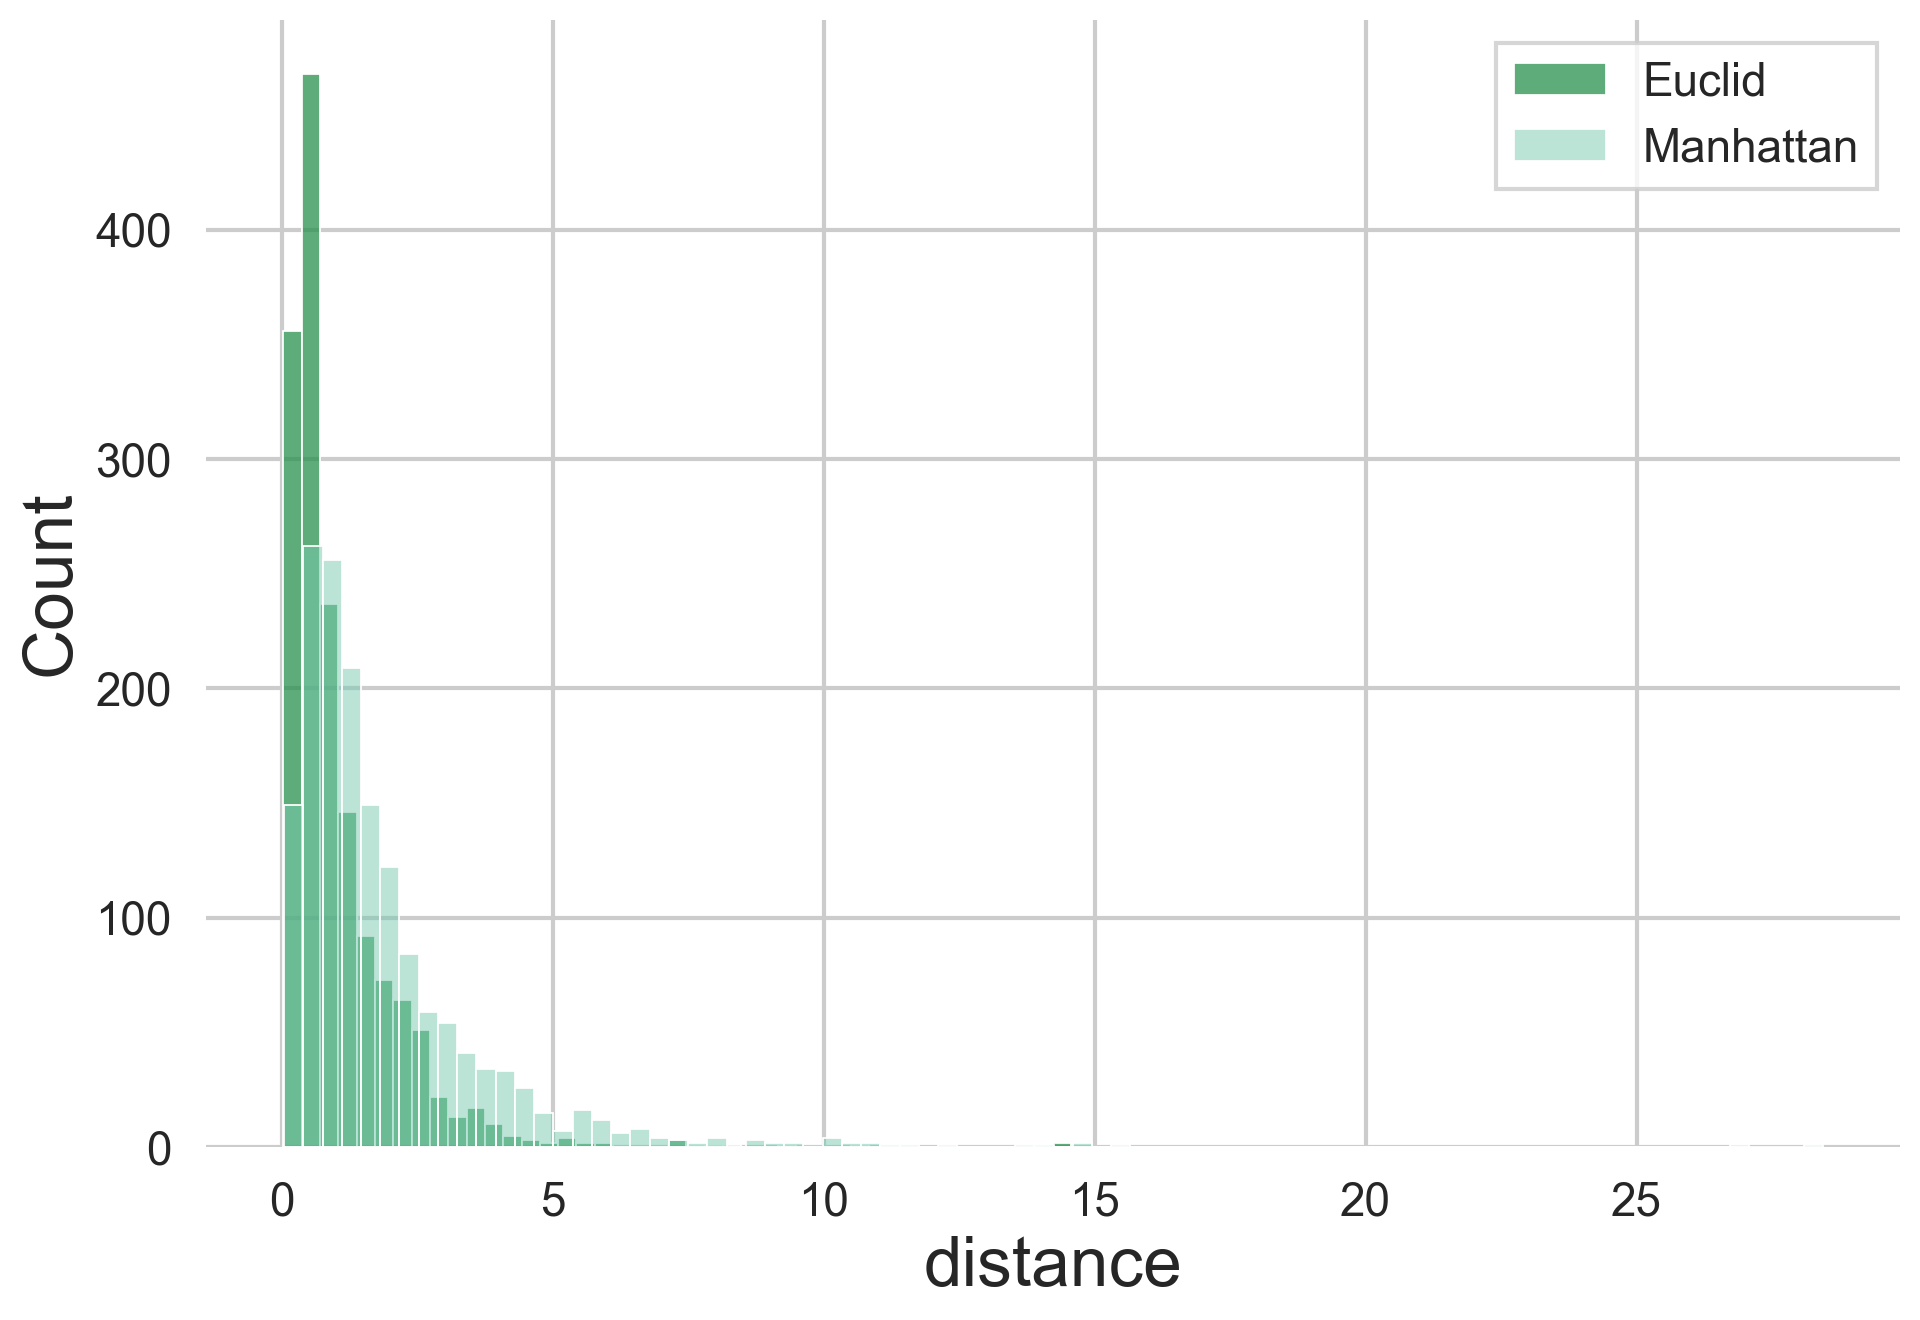

In [56]:
sns.histplot(data=div_dist_temporal_euclid, x='distance', label='Euclid')
sns.histplot(data=div_dist_temporal_manhattan, x='distance', alpha=0.5, label='Manhattan')
plt.legend()
plt.show()

### Переходим к PCA

In [57]:
X_scaled_df

byproducts  compound_feed_calf_replacements  energy_source  fat_oils  \
0      -0.442359                         0.006582      -0.197938  0.197524   
1      -0.442359                         0.264452       0.003359  0.434782   
2      -0.442359                         0.076183       0.153380  0.063079   
3      -0.442359                        -0.520589      -0.300277 -0.109291   
4      -0.442359                         0.165584       1.206982  0.427897   
...          ...                              ...            ...       ...   
1725   -0.377934                        -0.373844      -1.256511 -0.601151   
1726   -0.332237                        -0.336643      -1.443690 -0.601151   
1727   -0.366526                        -0.032340      -1.213063 -0.601151   
1728   -0.360463                        -1.568015      -1.263358 -0.601151   
1729   -0.442359                        -1.568015      -1.613958 -0.601151   

      feed_additives_probiotics  forage_bulk  medications  minerals_buffers  \
0                      0.252260    -0.688754    -0.417355         -0.270725   
1                      2.767508    -0.830473    -0.777979         -0.370921   
2                      3.386527    -1.231897    -0.474335          0.681429   
3                     -0.387452    -1.354695    -0.777979         -0.226020   
4                      2.164747    -0.151982     0.334490          1.385727   
...                         ...          ...          ...               ...   
1725                  -0.370616    -1.642454    -0.200974         -0.659817   
1726                  -0.387452    -2.293252    -0.345322         -0.745797   
1727                  -0.387452    -1.996386    -0.777979         -0.745797   
1728                  -0.387452    -0.376218    -0.777979         -0.745797   
1729                  -0.387452     2.166507     0.725114          1.321531   

      premix_feed  protein_source  wet_ingredients_water  yeast_products  
0       -0.150189        0.514075              -0.780617        7.603493  
1       -0.677669        1.222948               1.825176       -0.246525  
2       -0.182496        0.443496              -0.117194       10.390957  
3       -0.122578       -0.177779              -0.059523       -0.246525  
4        0.117105        2.296470               2.047337       -0.246525  
...           ...             ...                    ...             ...  
1725     0.270908       -1.168809               0.148406       -0.246525  
1726    -0.101711       -1.560905               0.930313       -0.246525  
1727    -0.032759       -1.232696              -2.031823       -0.246525  
1728     0.406750       -1.108522              -2.031823       -0.246525  
1729    -2.660458        0.328654               0.755449       -0.246525  

[1730 rows x 12 columns]

In [58]:
# центр
center1 = X_scaled_df.mean(axis=0).values.reshape(1, -1)

monthly_vectors['dist_to_center_euclid'] = pairwise_distances(
    X_scaled_df.values, center1, metric='euclidean'
)[:, 0]

monthly_vectors['dist_to_center_manhattan'] = pairwise_distances(
    X_scaled_df.values, center1, metric='manhattan'
)[:, 0]

# центр
center2 = X_div_scaled_df.mean(axis=0).values.reshape(1, -1)

monthly_div_vectors['dist_to_center_euclid'] = pairwise_distances(
    X_div_scaled_df.values, center2, metric='euclidean'
)[:, 0]

monthly_div_vectors['dist_to_center_manhattan'] = pairwise_distances(
    X_div_scaled_df.values, center2, metric='manhattan'
)[:, 0]

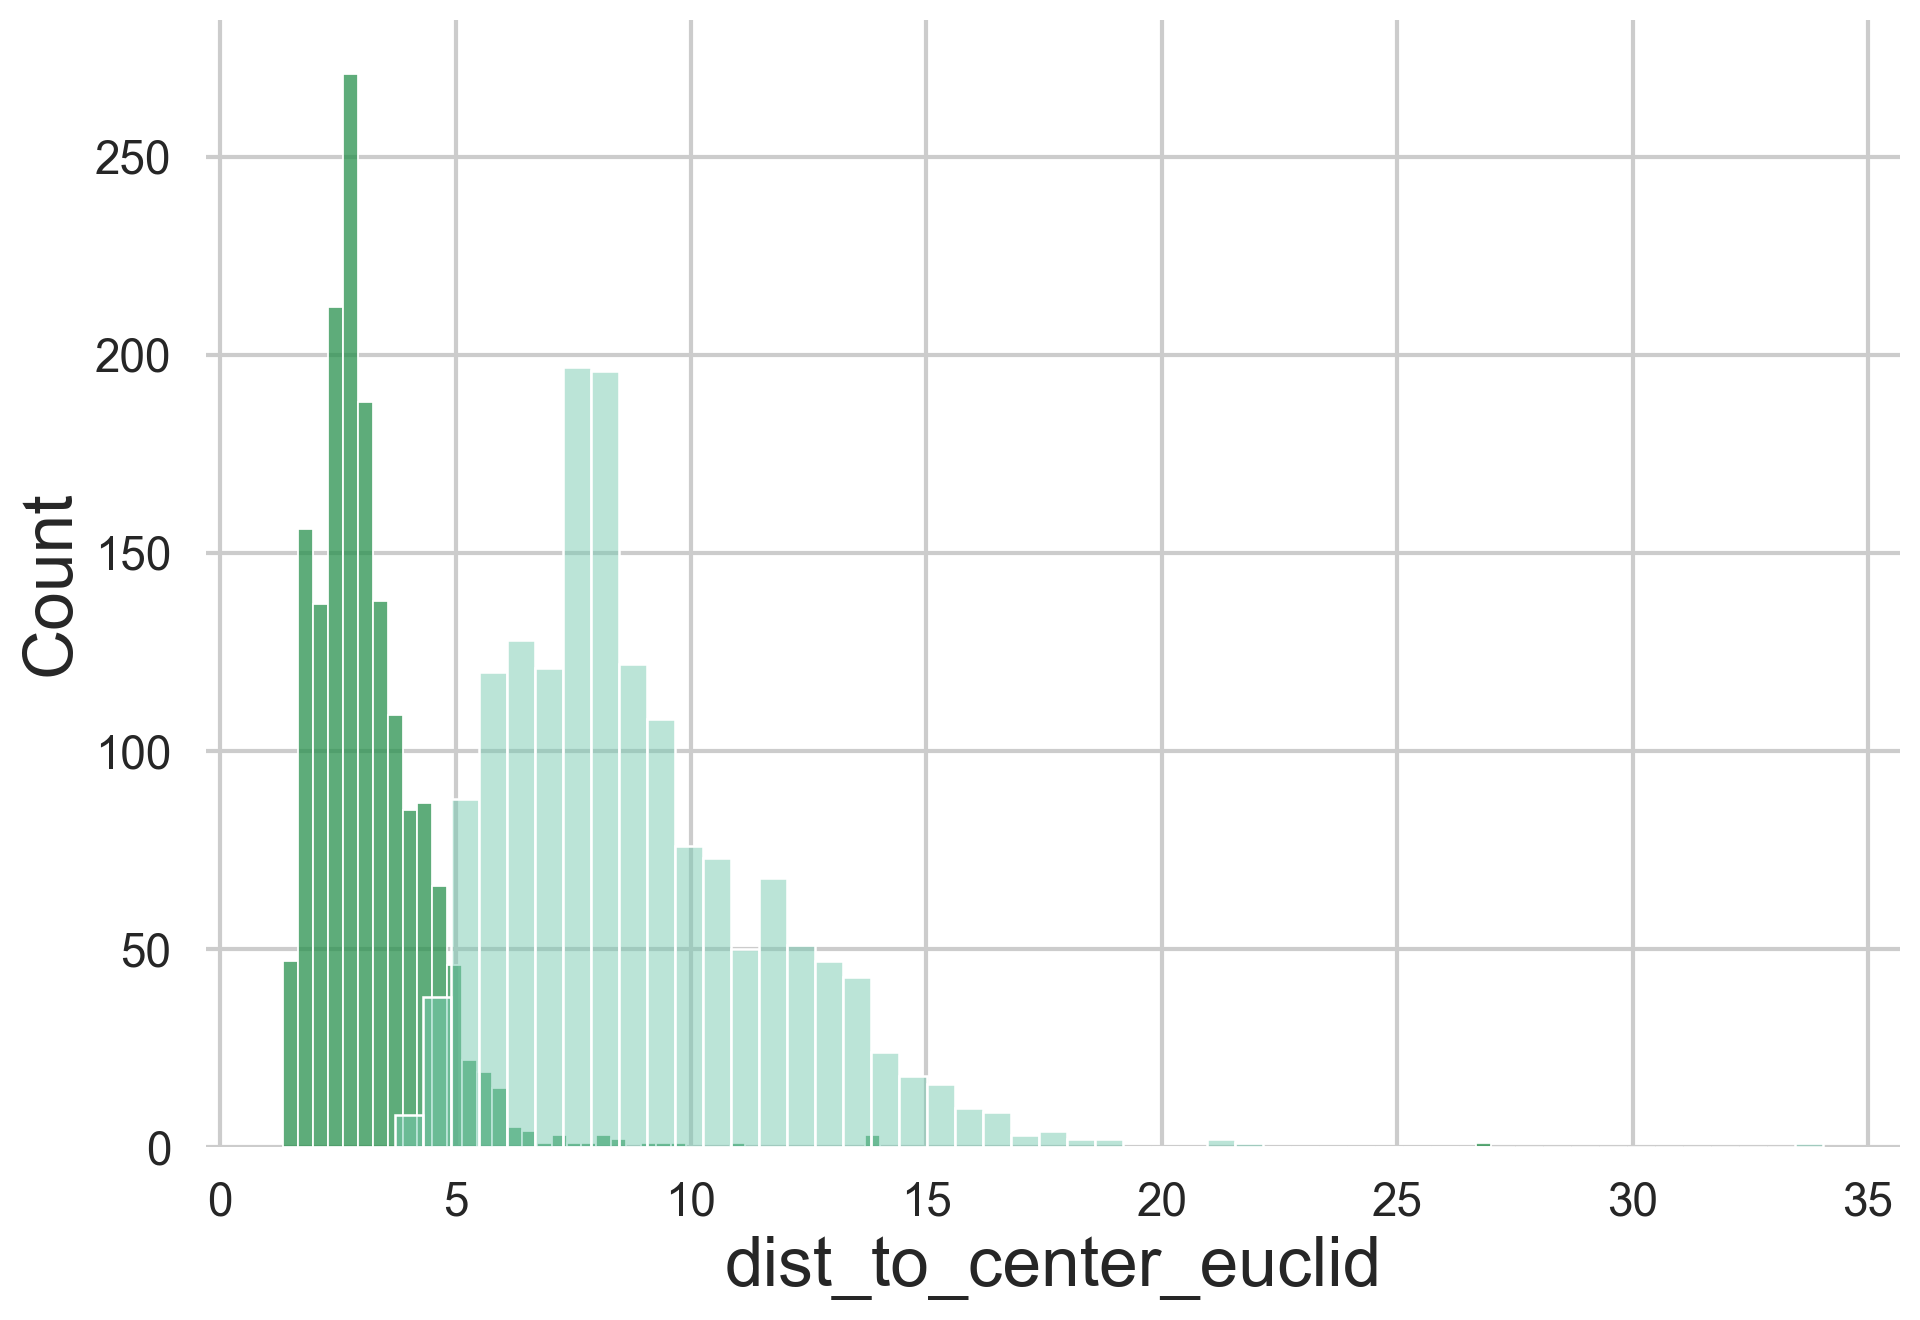

In [59]:
sns.histplot(data=monthly_div_vectors, x='dist_to_center_euclid', label='Euclid')
sns.histplot(data=monthly_div_vectors, x='dist_to_center_manhattan', alpha=0.5, label='Manhattan')
plt.show()

In [60]:
u = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

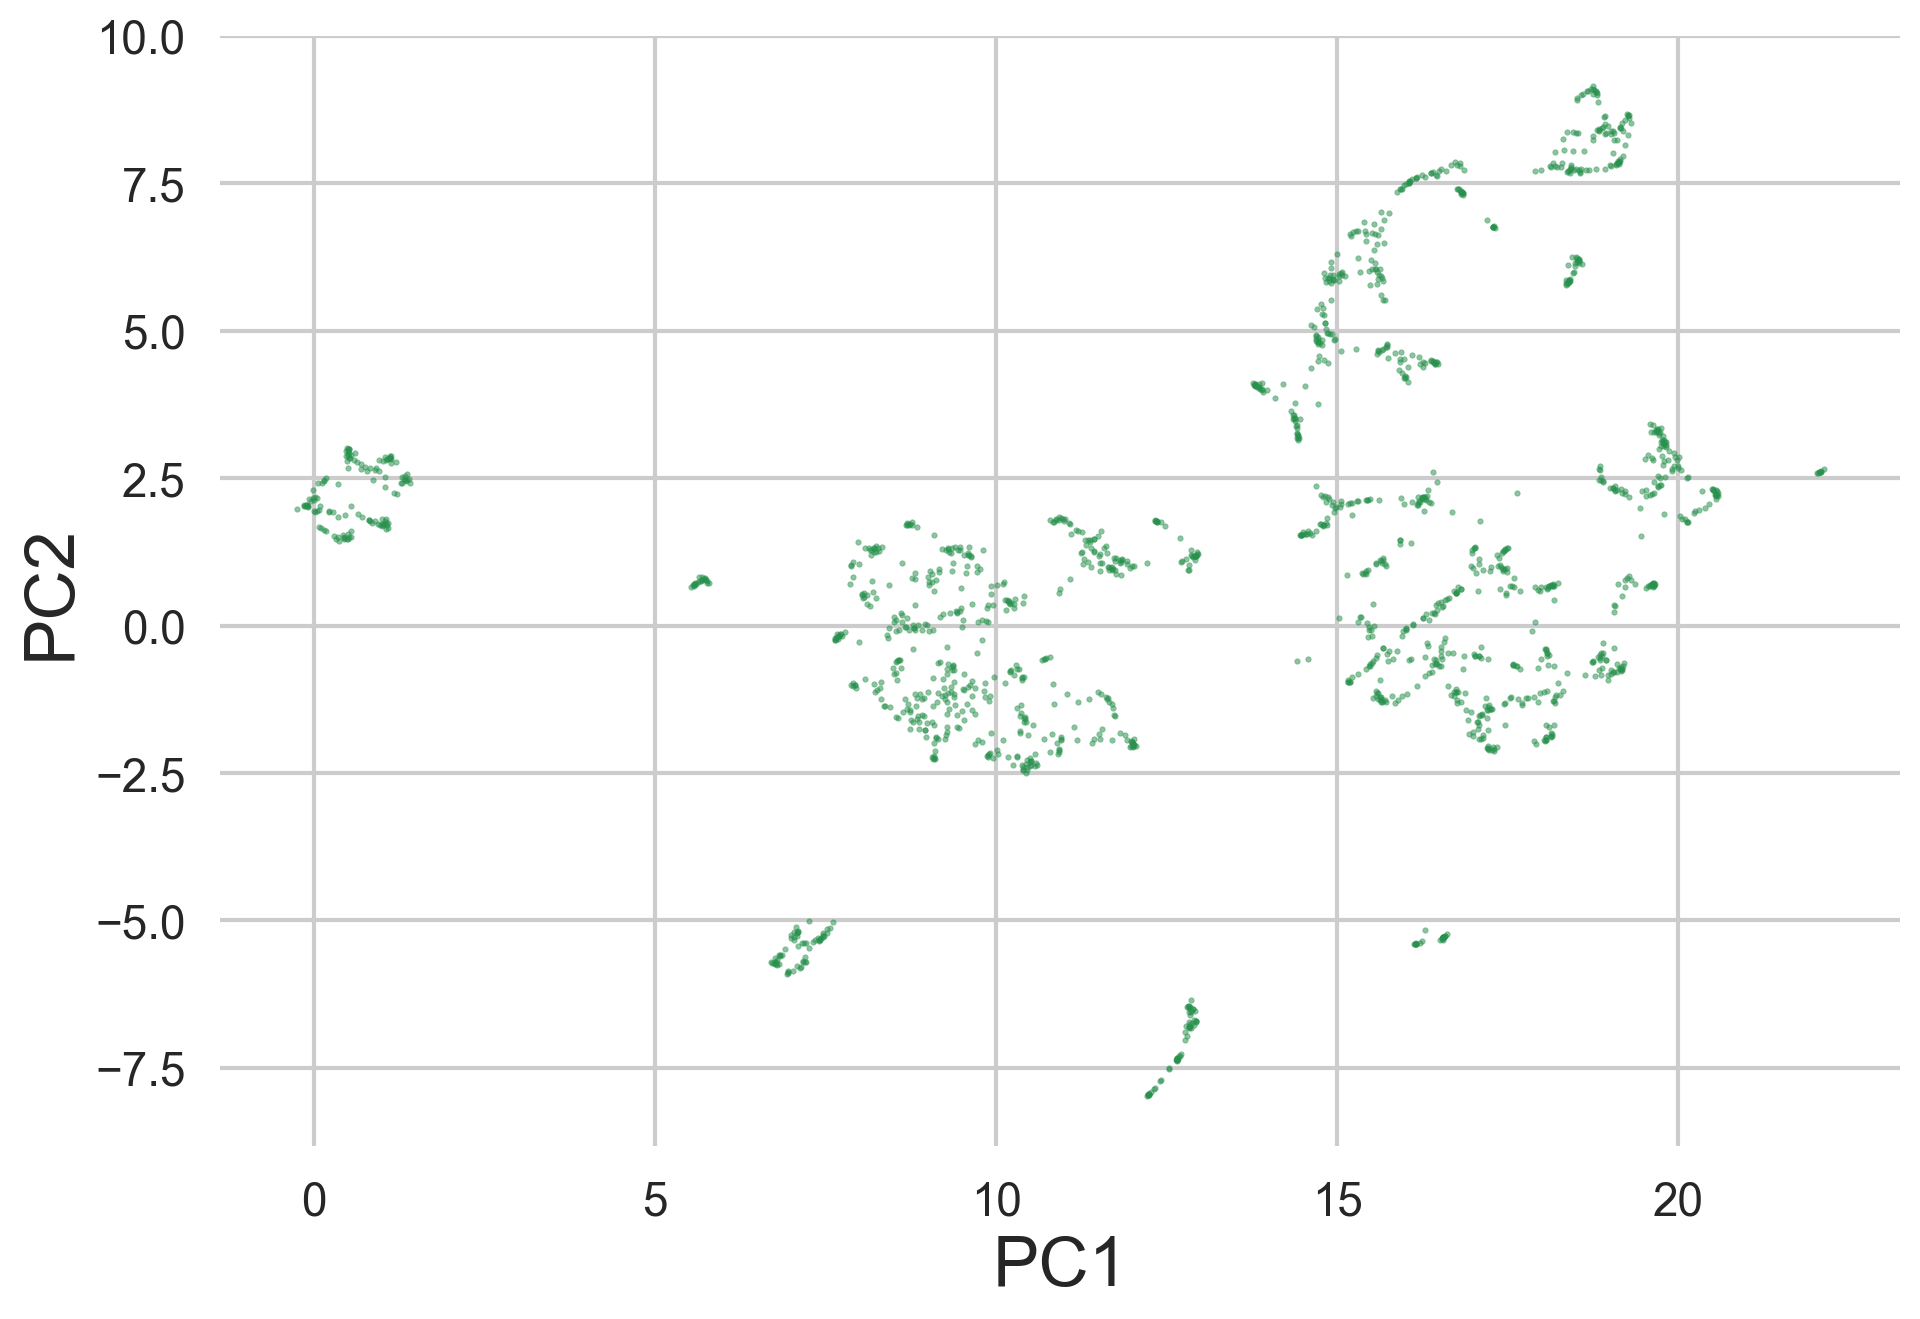

In [61]:
U = u.fit_transform(X_scaled)

monthly_vectors['um1'] = U[:, 0]
monthly_vectors['um2'] = U[:, 1]
# простое отображение получившейся плоскости
plt.scatter(monthly_vectors['um1'], monthly_vectors['um2'], alpha=0.6, s=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

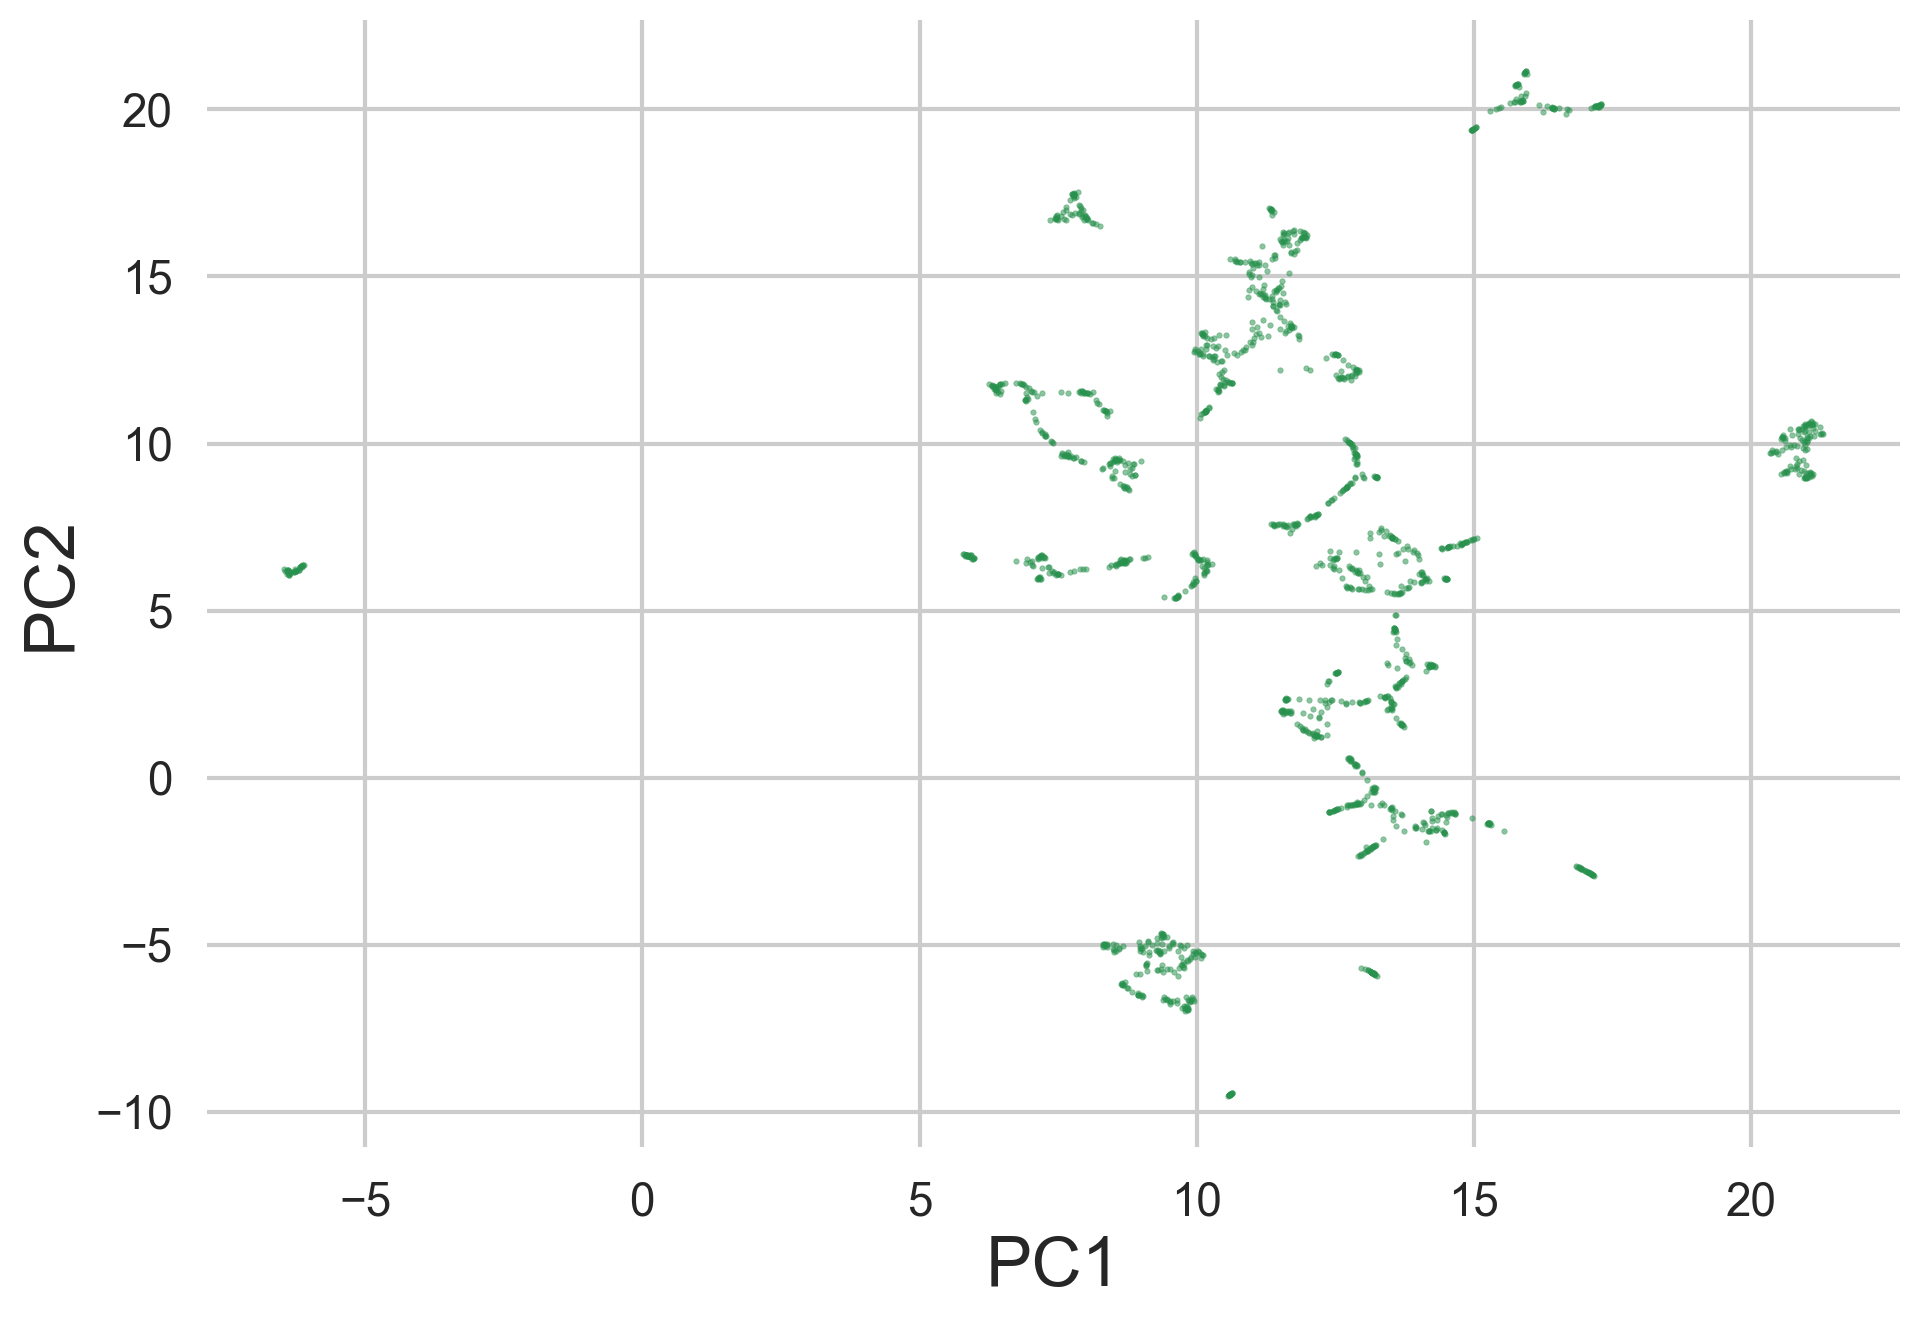

In [62]:
U_div = u.fit_transform(X_div_scaled)

monthly_div_vectors['um1'] = U_div[:, 0]
monthly_div_vectors['um2'] = U_div[:, 1]
# простое отображение получившейся плоскости
plt.scatter(monthly_div_vectors['um1'], monthly_div_vectors['um2'], alpha=0.6, s=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [63]:
monthly_vectors

ingredient_group year_month           FarmName  byproducts  \
0                   2022-01         ЖК Добрино    0.000000   
1                   2022-01         ЖК Коршево    0.000000   
2                   2022-02        ЖК Бодеевка    0.000000   
3                   2022-02  ЖК Верхний Икорец    0.000000   
4                   2022-02         ЖК Высокое    0.000000   
...                     ...                ...         ...   
1725                2025-10        РМ Кольцово    0.721447   
1726                2025-10        РМ Пеньково    1.233179   
1727                2025-10          РМ Поляна    0.849197   
1728                2025-10        РМ Торопово    0.917100   
1729                2025-10           ЭФ Родня    0.000000   

ingredient_group  compound_feed_calf_replacements  energy_source  fat_oils  \
0                                        2.443405       3.042668  0.100609   
1                                        2.843560       3.475203  0.130497   
2                                        2.551410       3.797562  0.083673   
3                                        1.625360       2.822767  0.061960   
4                                        2.690139       6.061484  0.129629   
...                                           ...            ...       ...   
1725                                     1.853074       0.768064  0.000000   
1726                                     1.910801       0.365862  0.000000   
1727                                     2.383007       0.861422  0.000000   
1728                                     0.000000       0.753350  0.000000   
1729                                     0.000000       0.000000  0.000000   

ingredient_group  feed_additives_probiotics  forage_bulk  medications  \
0                                  0.063965    20.326100     0.031507   
1                                  0.315463    19.497481     0.000000   
2                                  0.377359    17.150380     0.026529   
3                                  0.000000    16.432382     0.000000   
4                                  0.255193    23.464573     0.097194   
...                                     ...          ...          ...   
1725                               0.001683    14.749873     0.050412   
1726                               0.000000    10.944699     0.037800   
1727                               0.000000    12.680457     0.000000   
1728                               0.000000    22.153482     0.000000   
1729                               0.000000    37.020642     0.131322   

ingredient_group  minerals_buffers  premix_feed  protein_source  \
0                         0.051698     0.167850        2.909530   
1                         0.040794     0.132580        3.603738   
2                         0.155312     0.165690        2.840411   
3                         0.056563     0.169696        2.231988   
4                         0.231954     0.185723        4.655053   
...                            ...          ...             ...   
1725                      0.009356     0.196007        1.261460   
1726                      0.000000     0.171092        0.877475   
1727                      0.000000     0.175702        1.198894   
1728                      0.000000     0.205090        1.320500   
1729                      0.224968     0.000000        2.727945   

ingredient_group  wet_ingredients_water  yeast_products  \
0                              2.693400        0.832498   
1                              8.302740        0.000000   
2                              4.121511        1.128109   
3                              4.245658        0.000000   
4                              8.780972        0.000000   
...                                 ...             ...   
1725                           4.693253        0.000000   
1726                           6.376418        0.000000   
1727                           0.000000        0.000000   
1728                           0.000000       

### Получаем ****monthly_vectors****, где um1, um2 - координаты конкретной фермы, конкретной физиологической группы в конкретный месяц (и данными про ингридиенты)

## Продолжение: прикольные графики и интересные идеи

In [64]:
import plotly.express as pe
# тяжело читать график
pe.scatter_3d(data_frame=monthly_vectors, x='year_month', y='um2', z='um1')

In [65]:
# тяжело читать график
pe.scatter_3d(data_frame=monthly_div_vectors, x='um1', y='um2', z='year_month')

In [66]:
monthly_vectors['pca_drift'] = np.nan

monthly_vectors_sorted = monthly_vectors.sort_values(
    ['FarmName', 'year_month']
)

for farm, df_fg in monthly_vectors_sorted.groupby(['FarmName']):
    idx = df_fg.index.tolist()
    for i in range(1, len(idx)):
        prev = idx[i-1]
        curr = idx[i]
        dx = monthly_vectors.loc[curr, 'um1'] - monthly_vectors.loc[prev, 'um1']
        dy = monthly_vectors.loc[curr, 'um2'] - monthly_vectors.loc[prev, 'um2']
        monthly_vectors.loc[curr, 'pca_drift'] = np.sqrt(dx*dx + dy*dy)

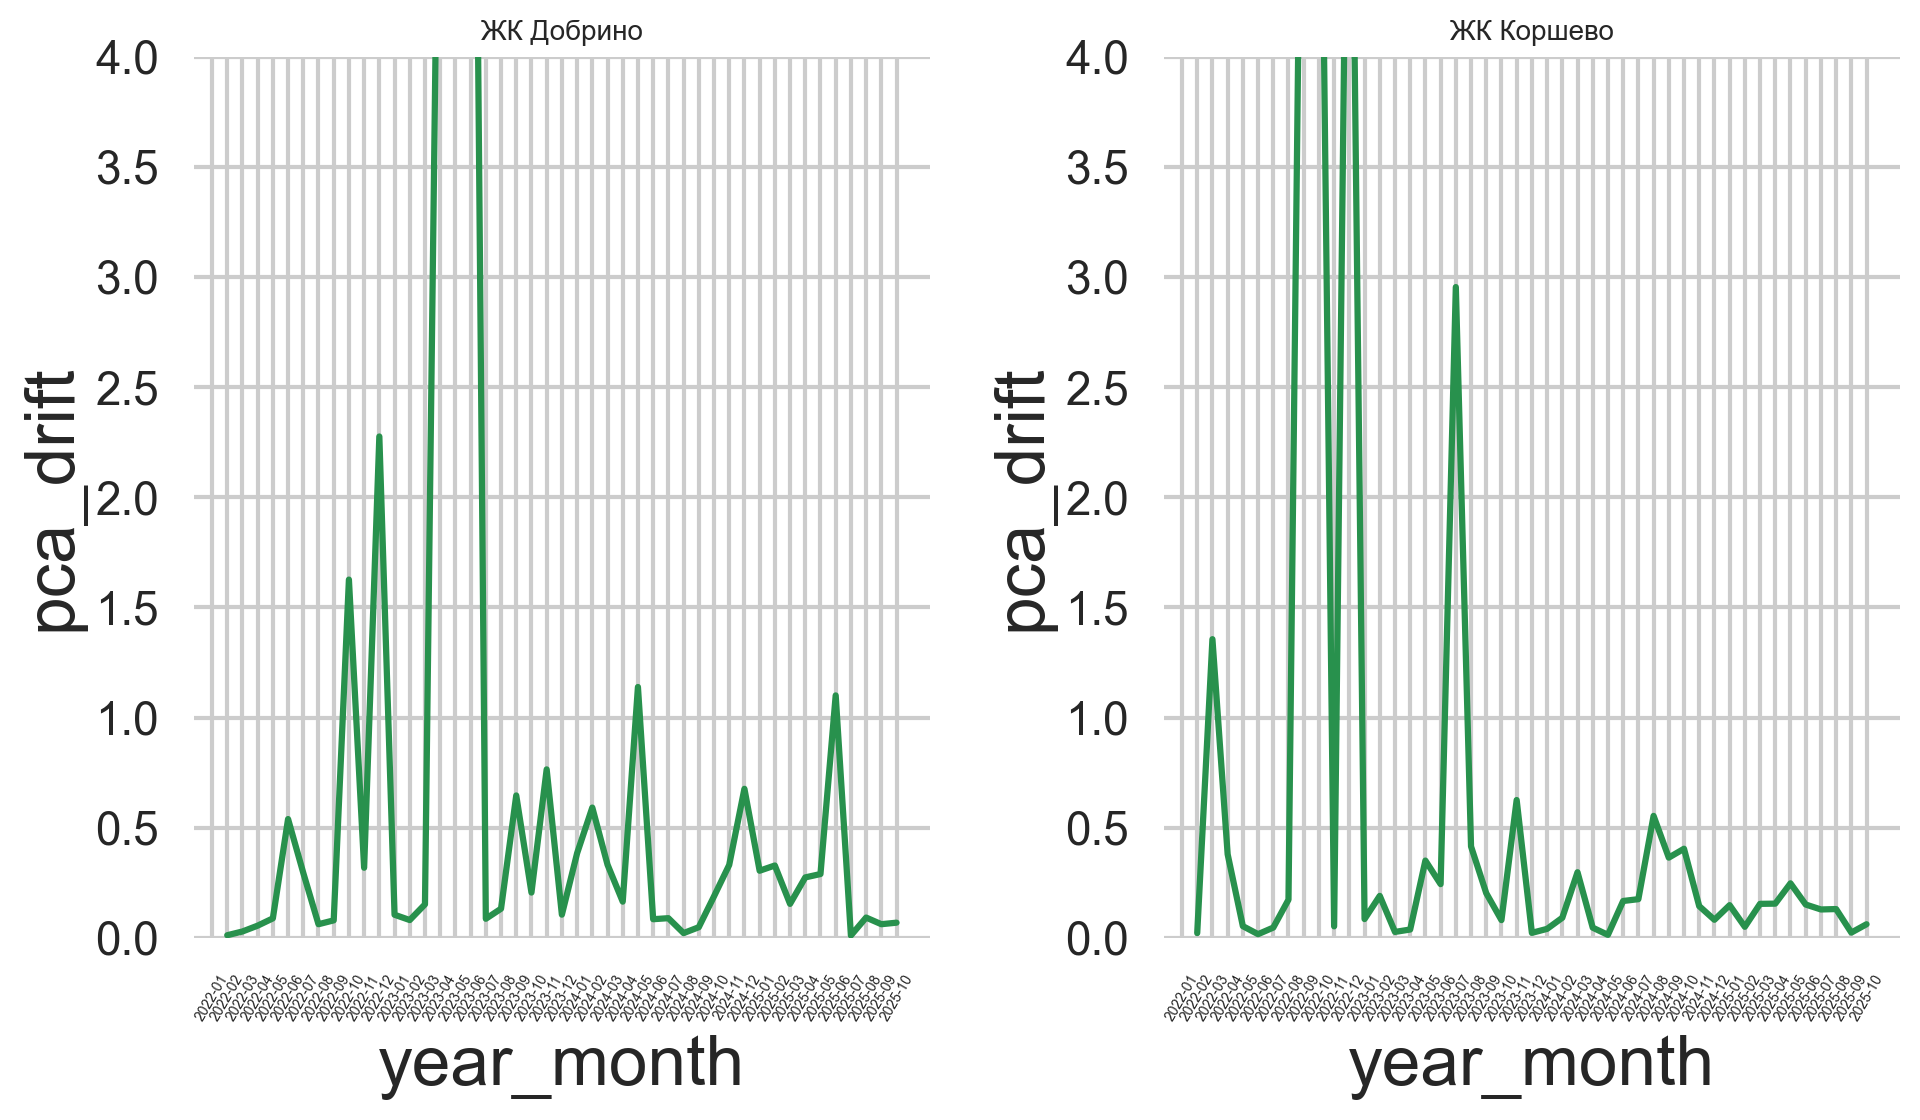

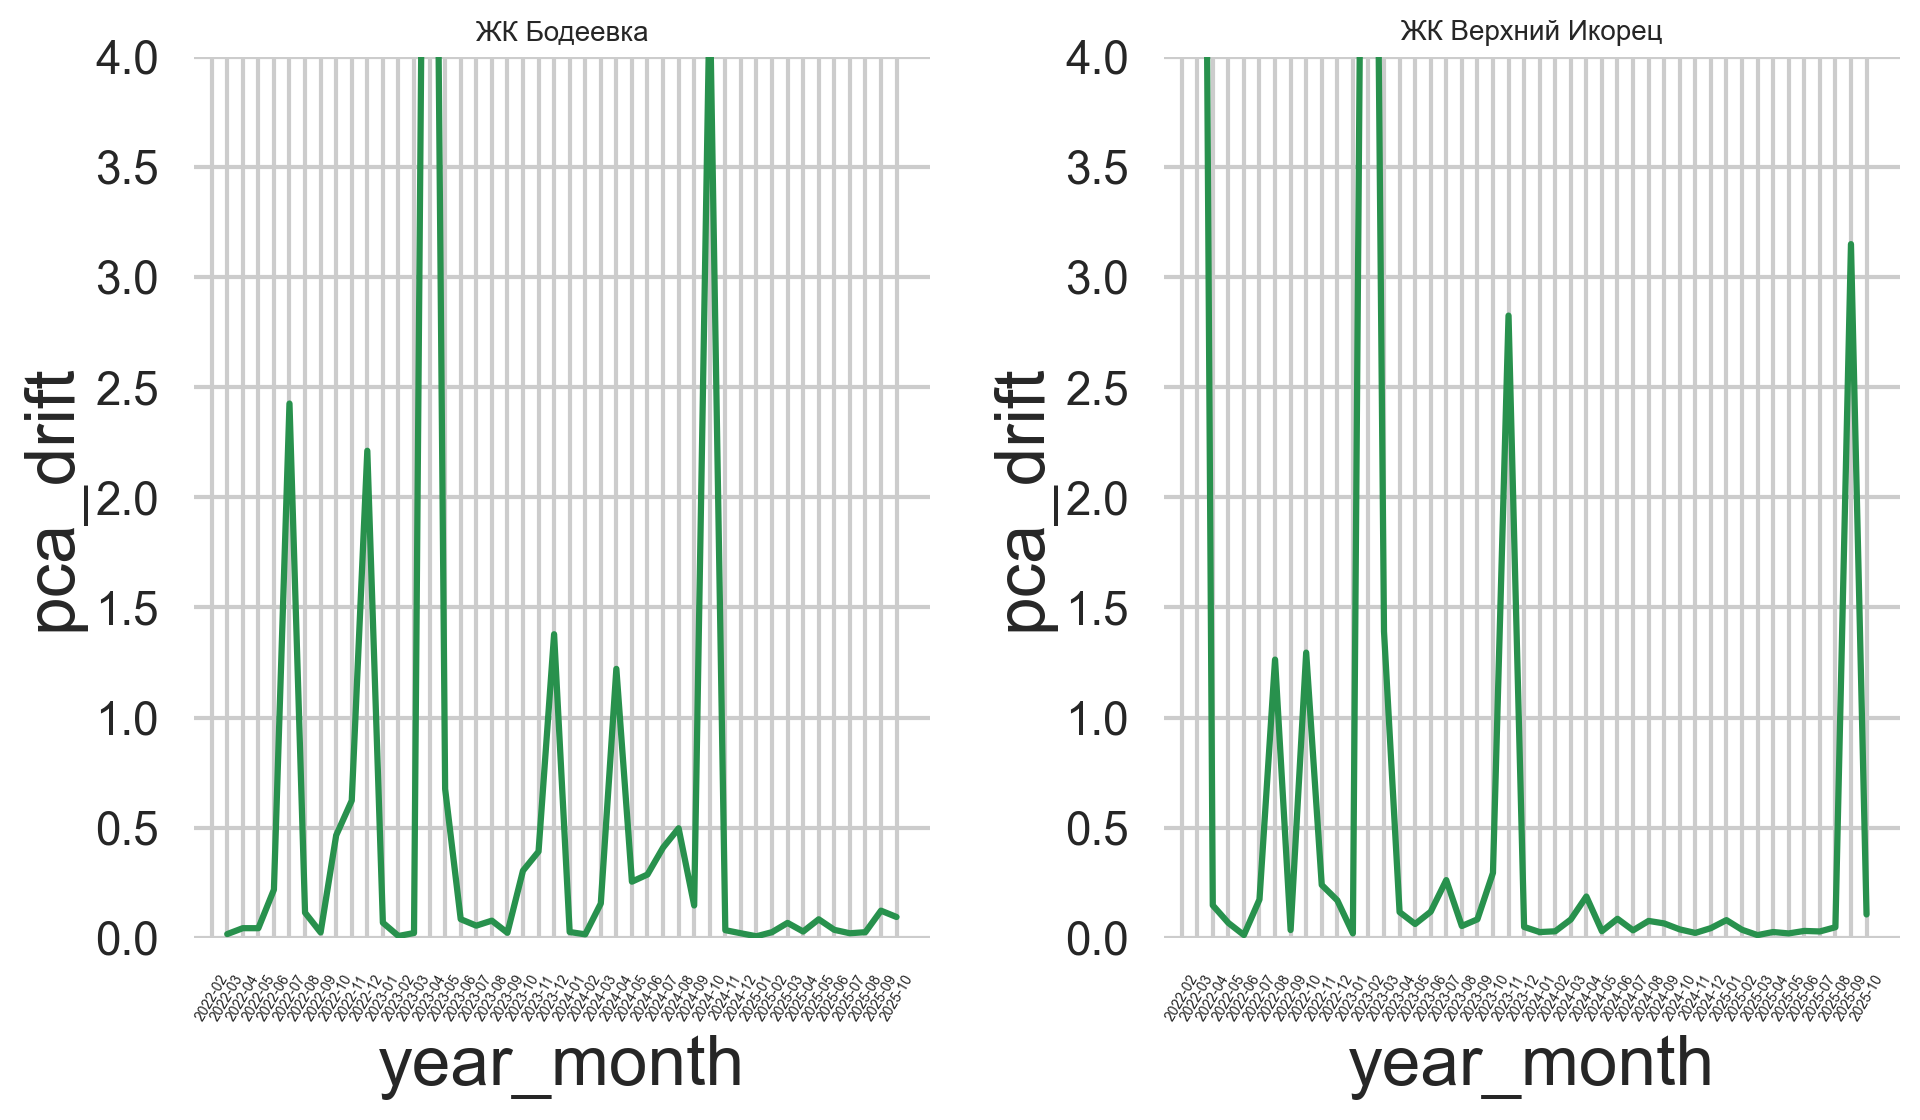

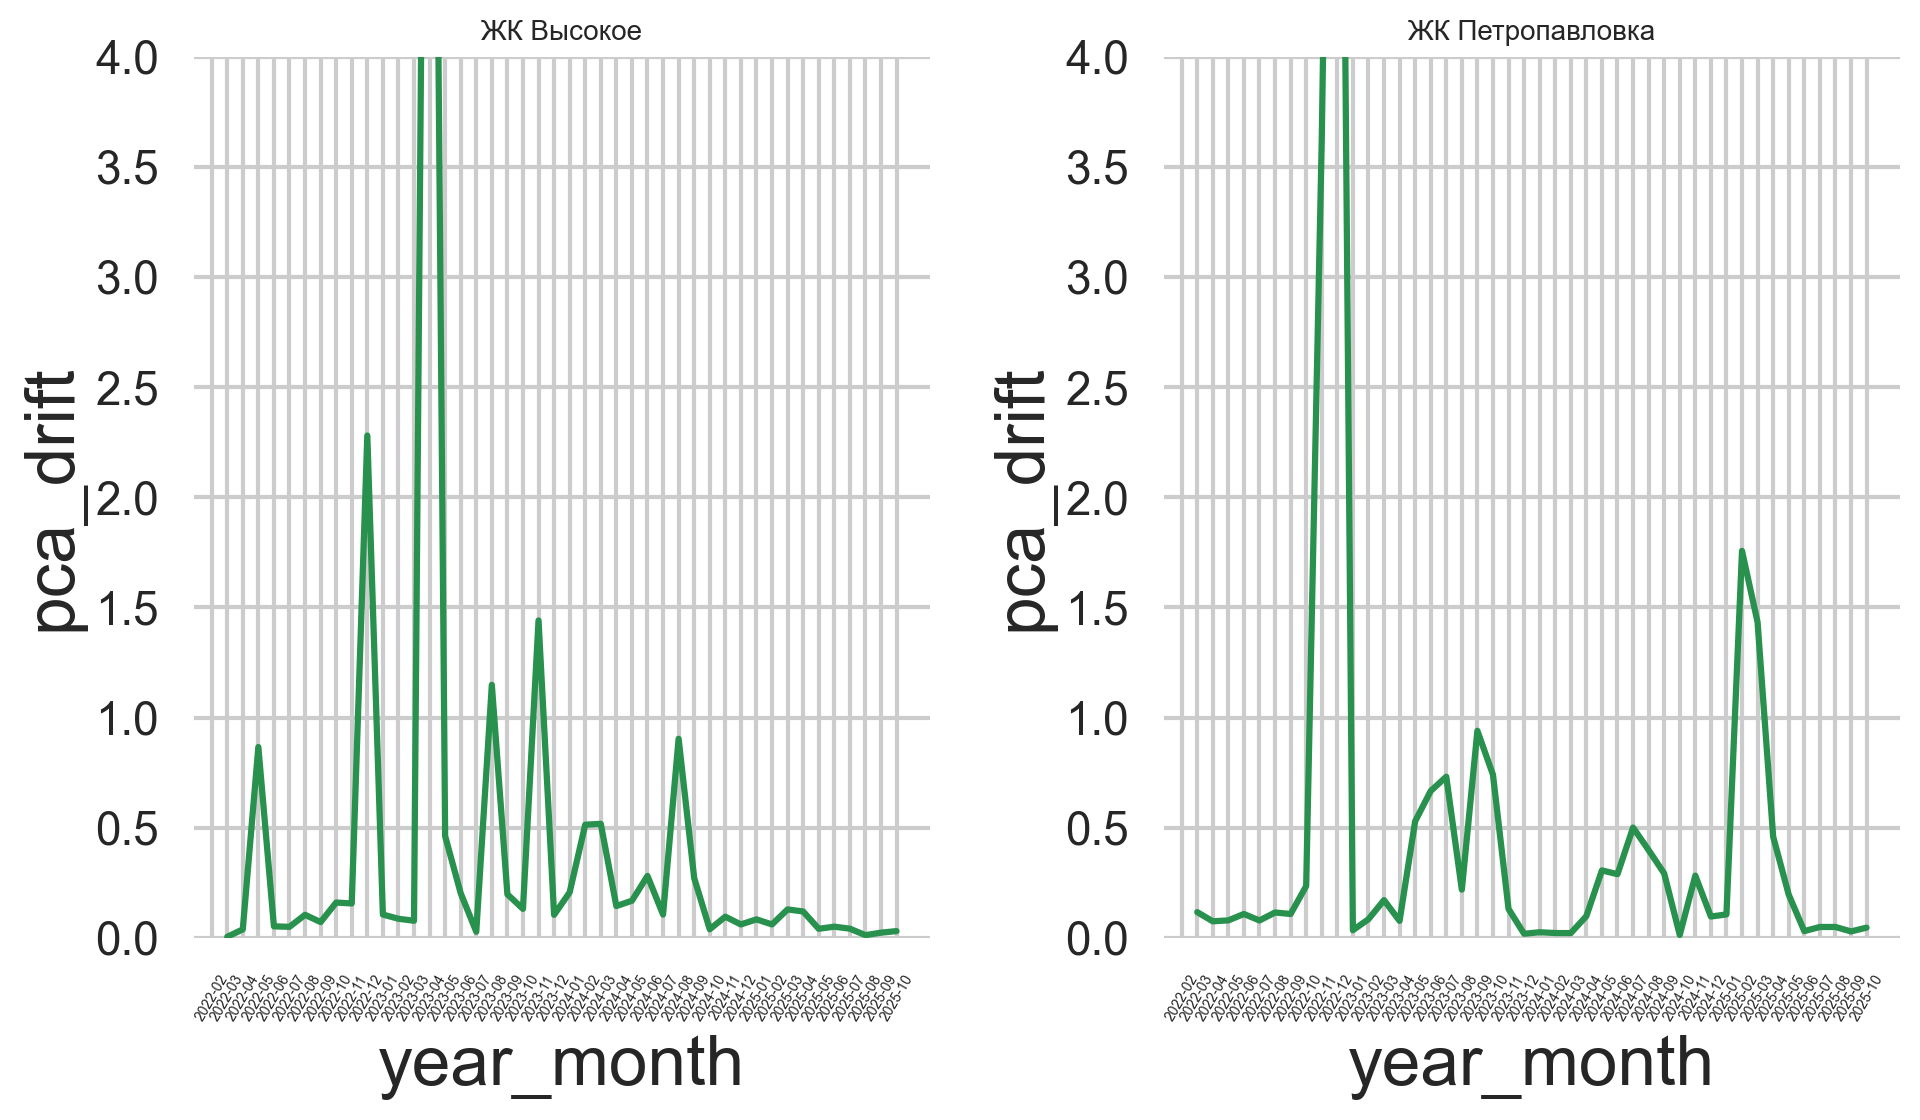

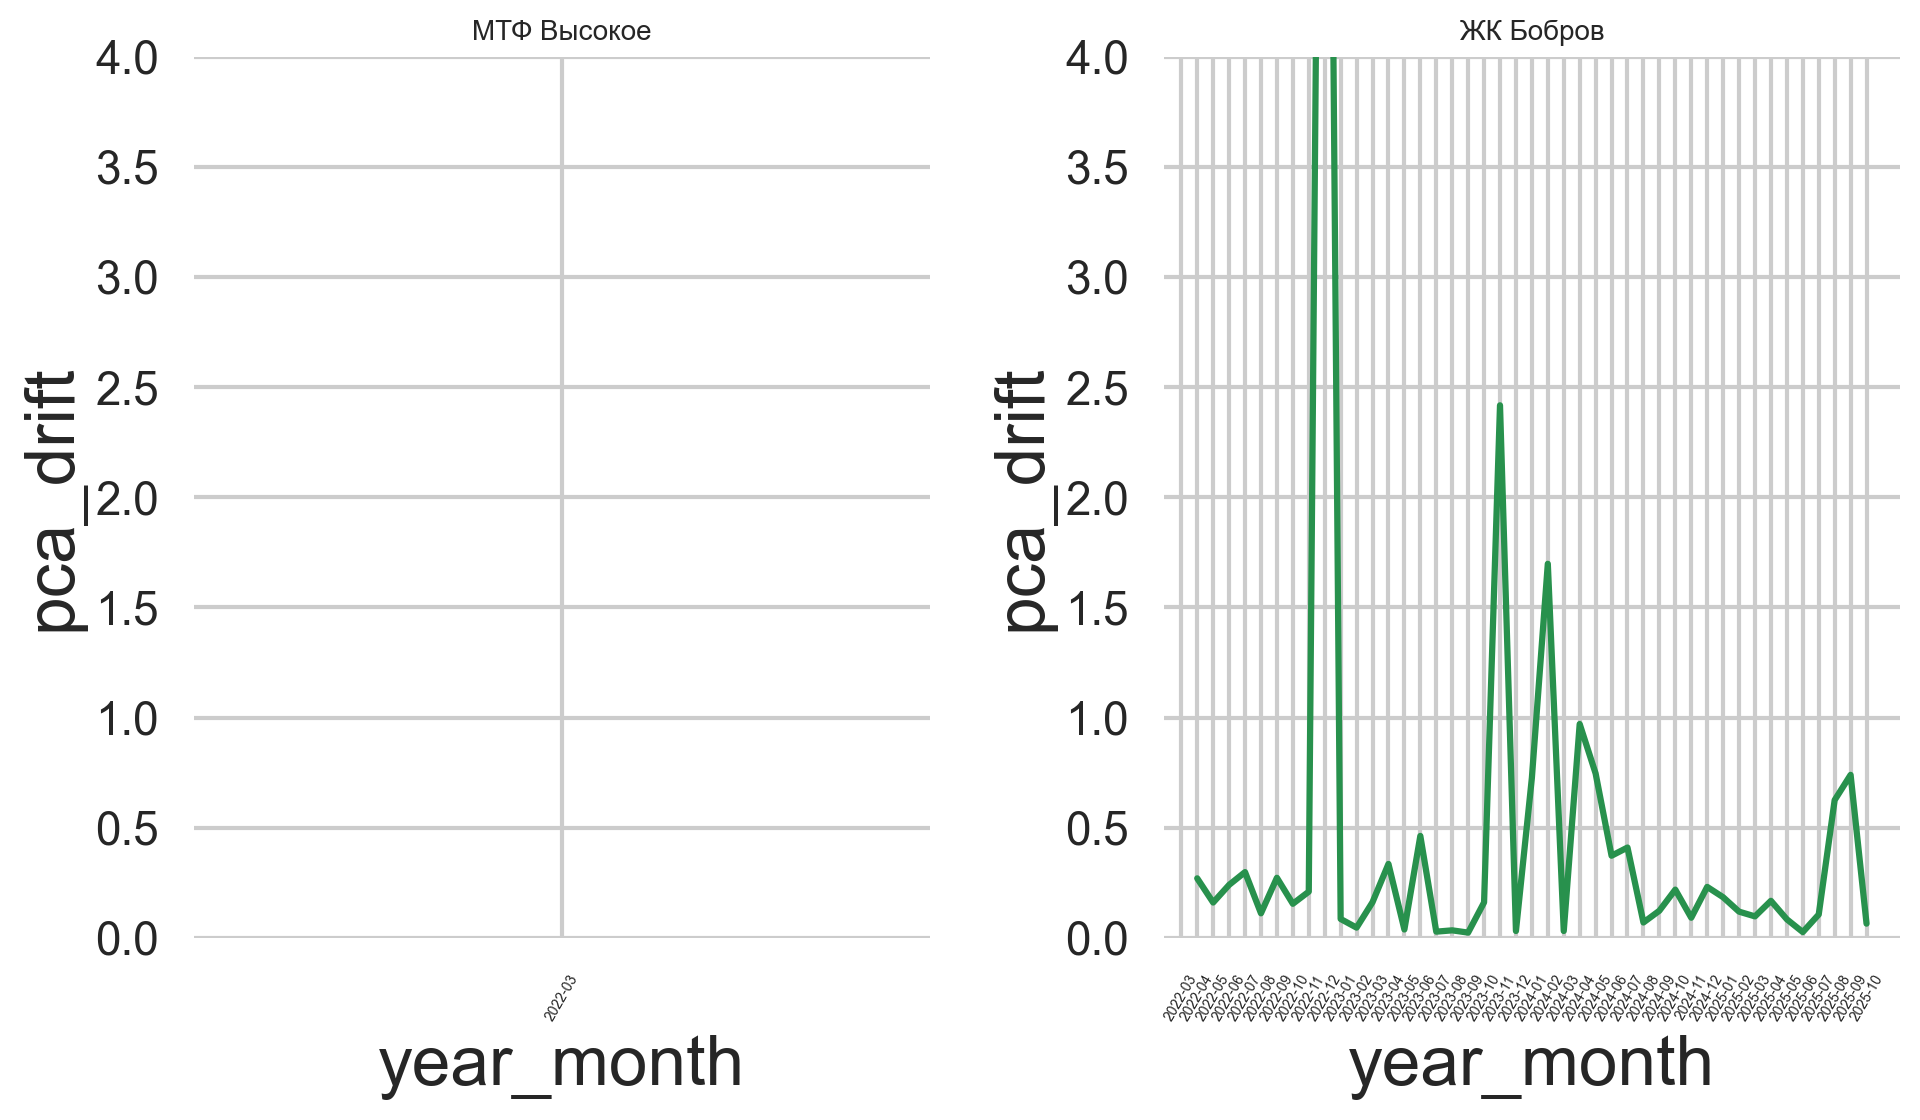

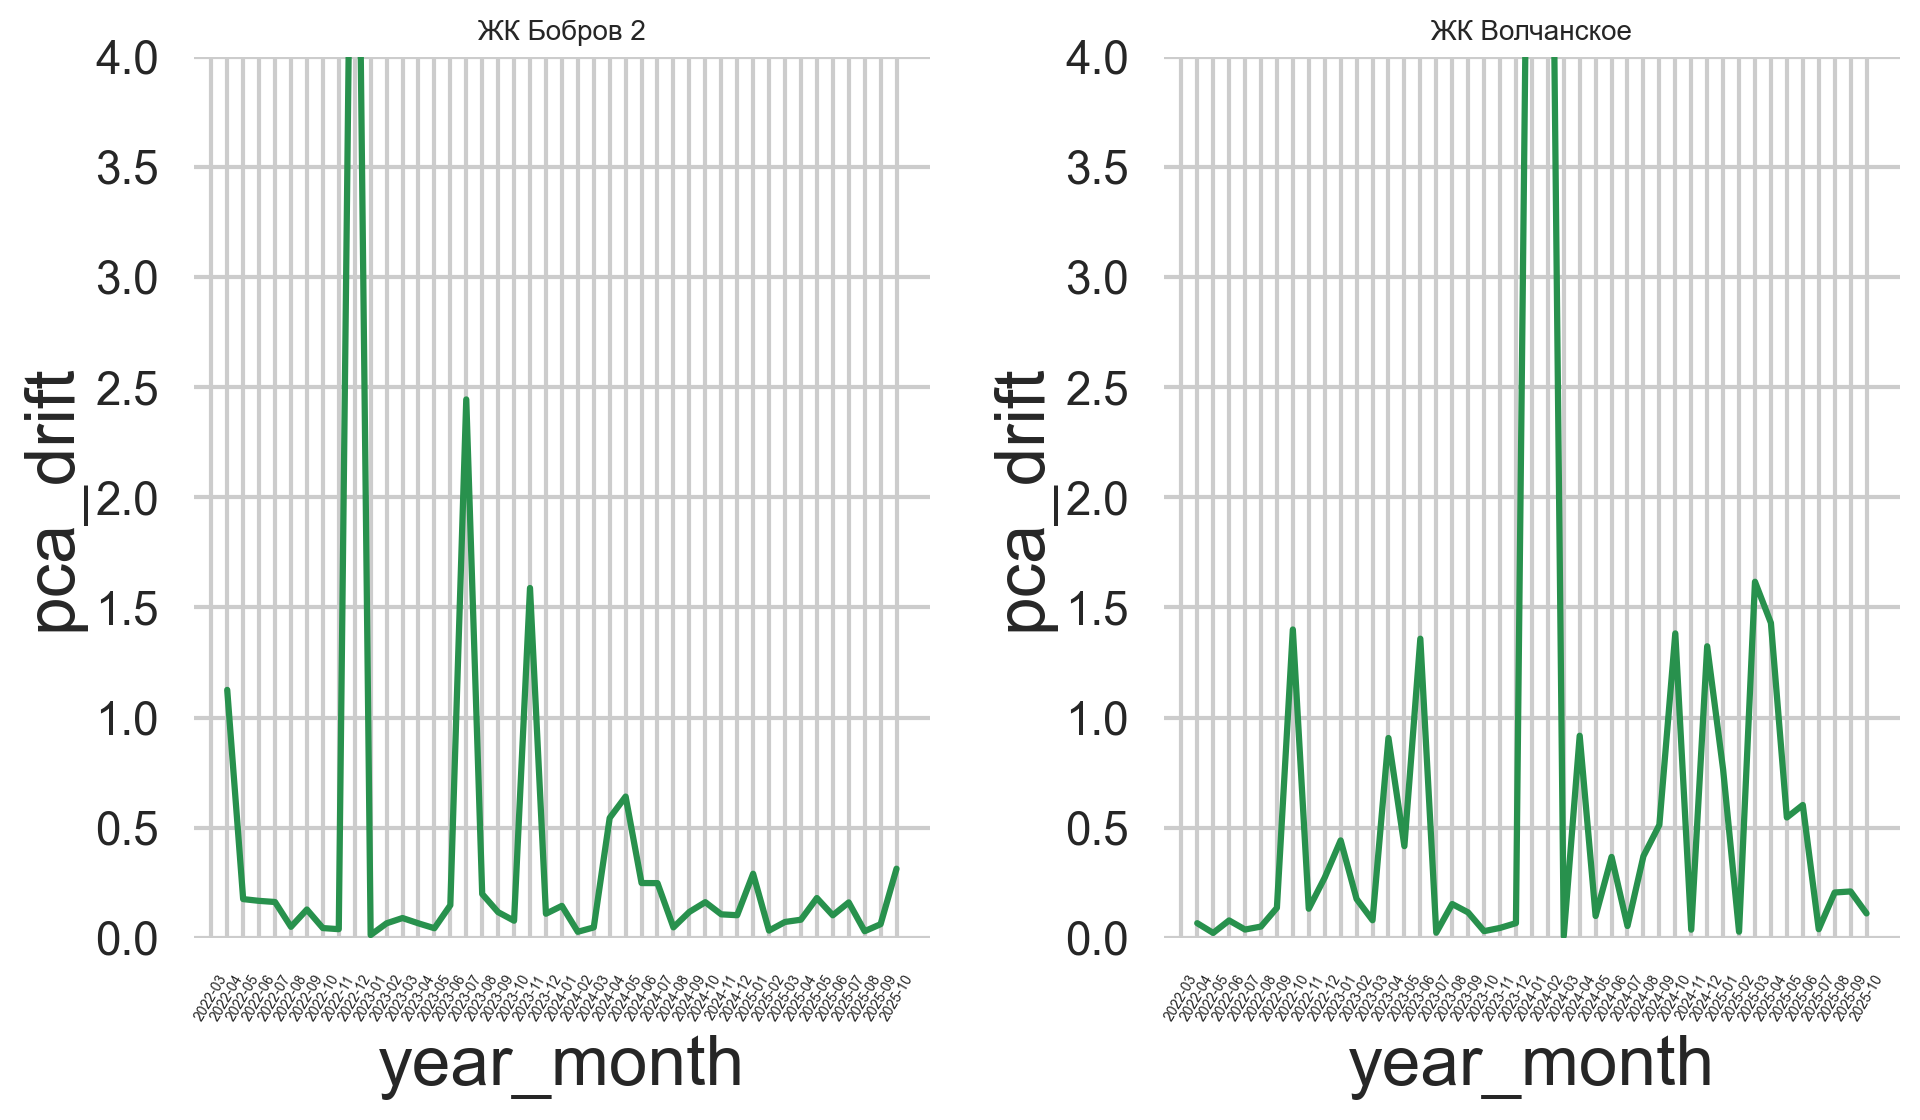

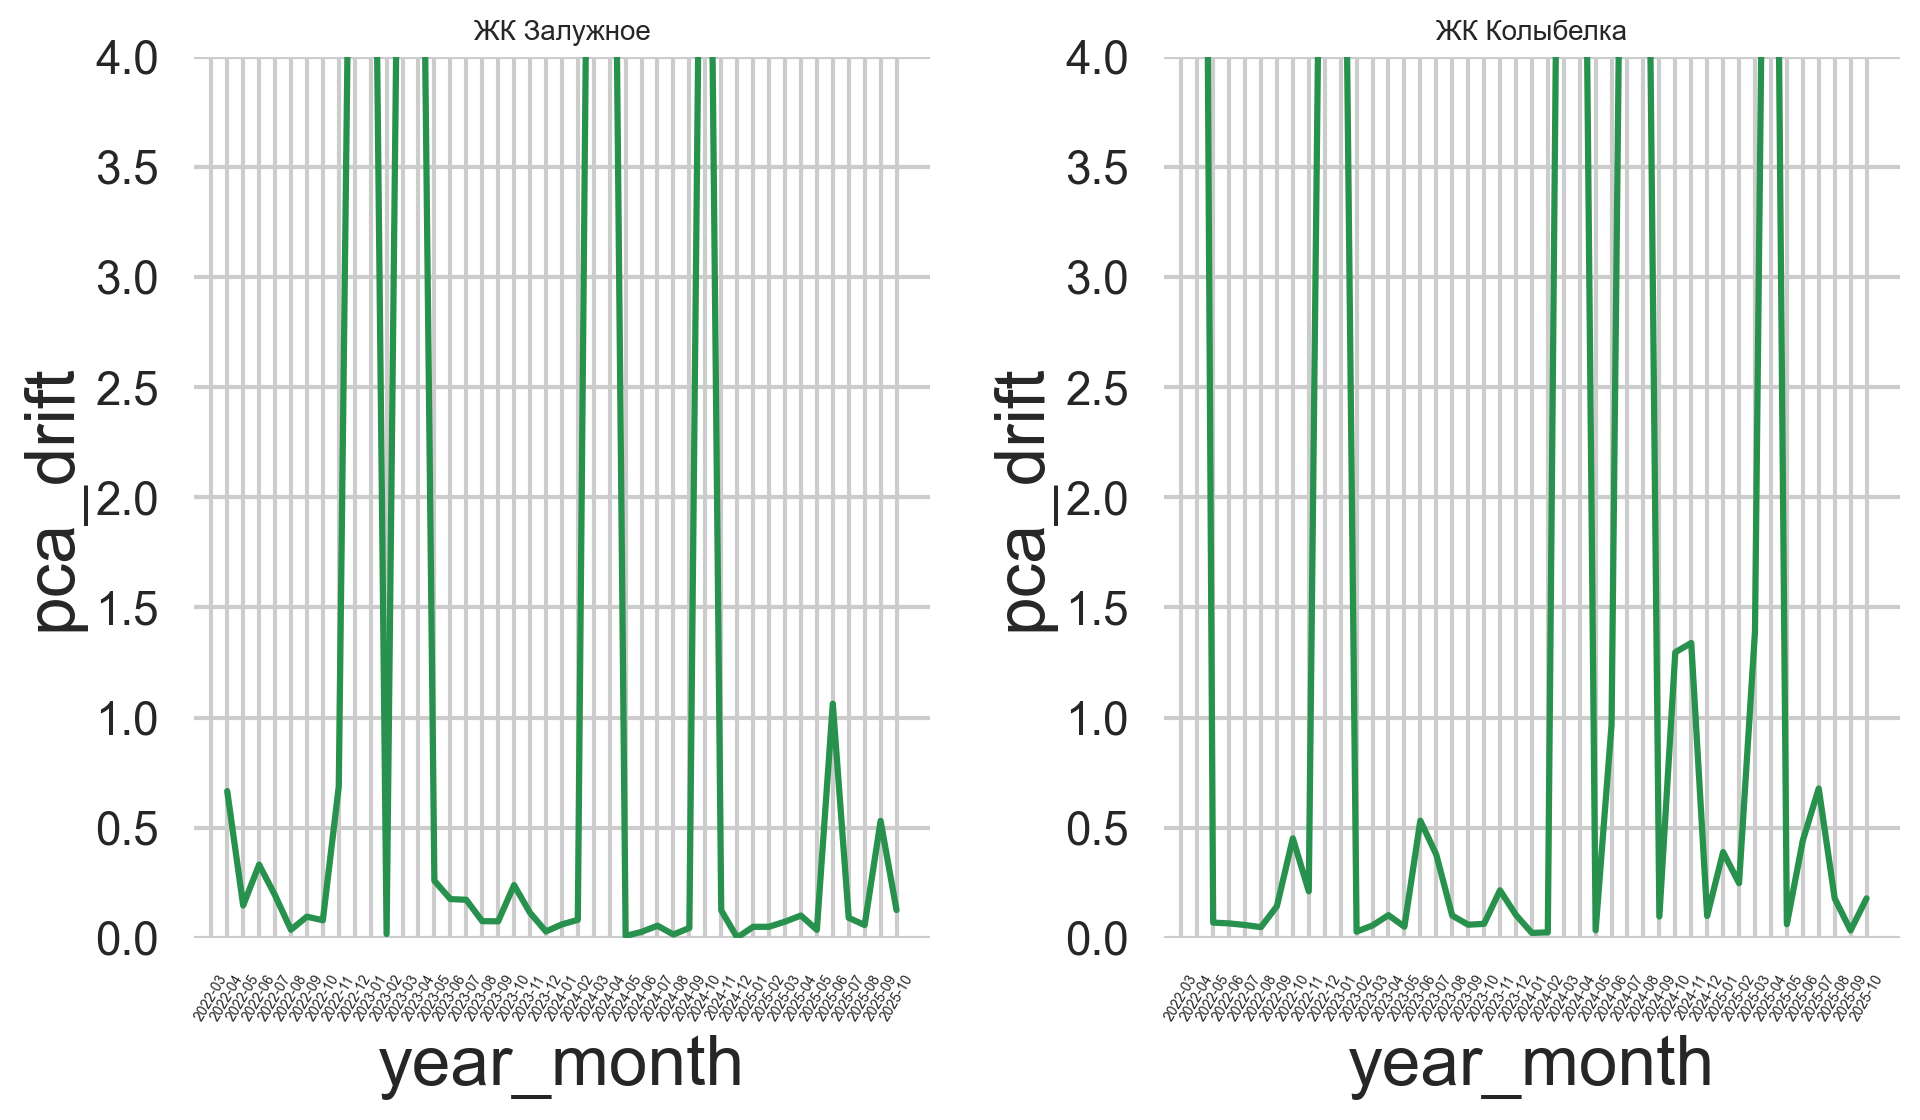

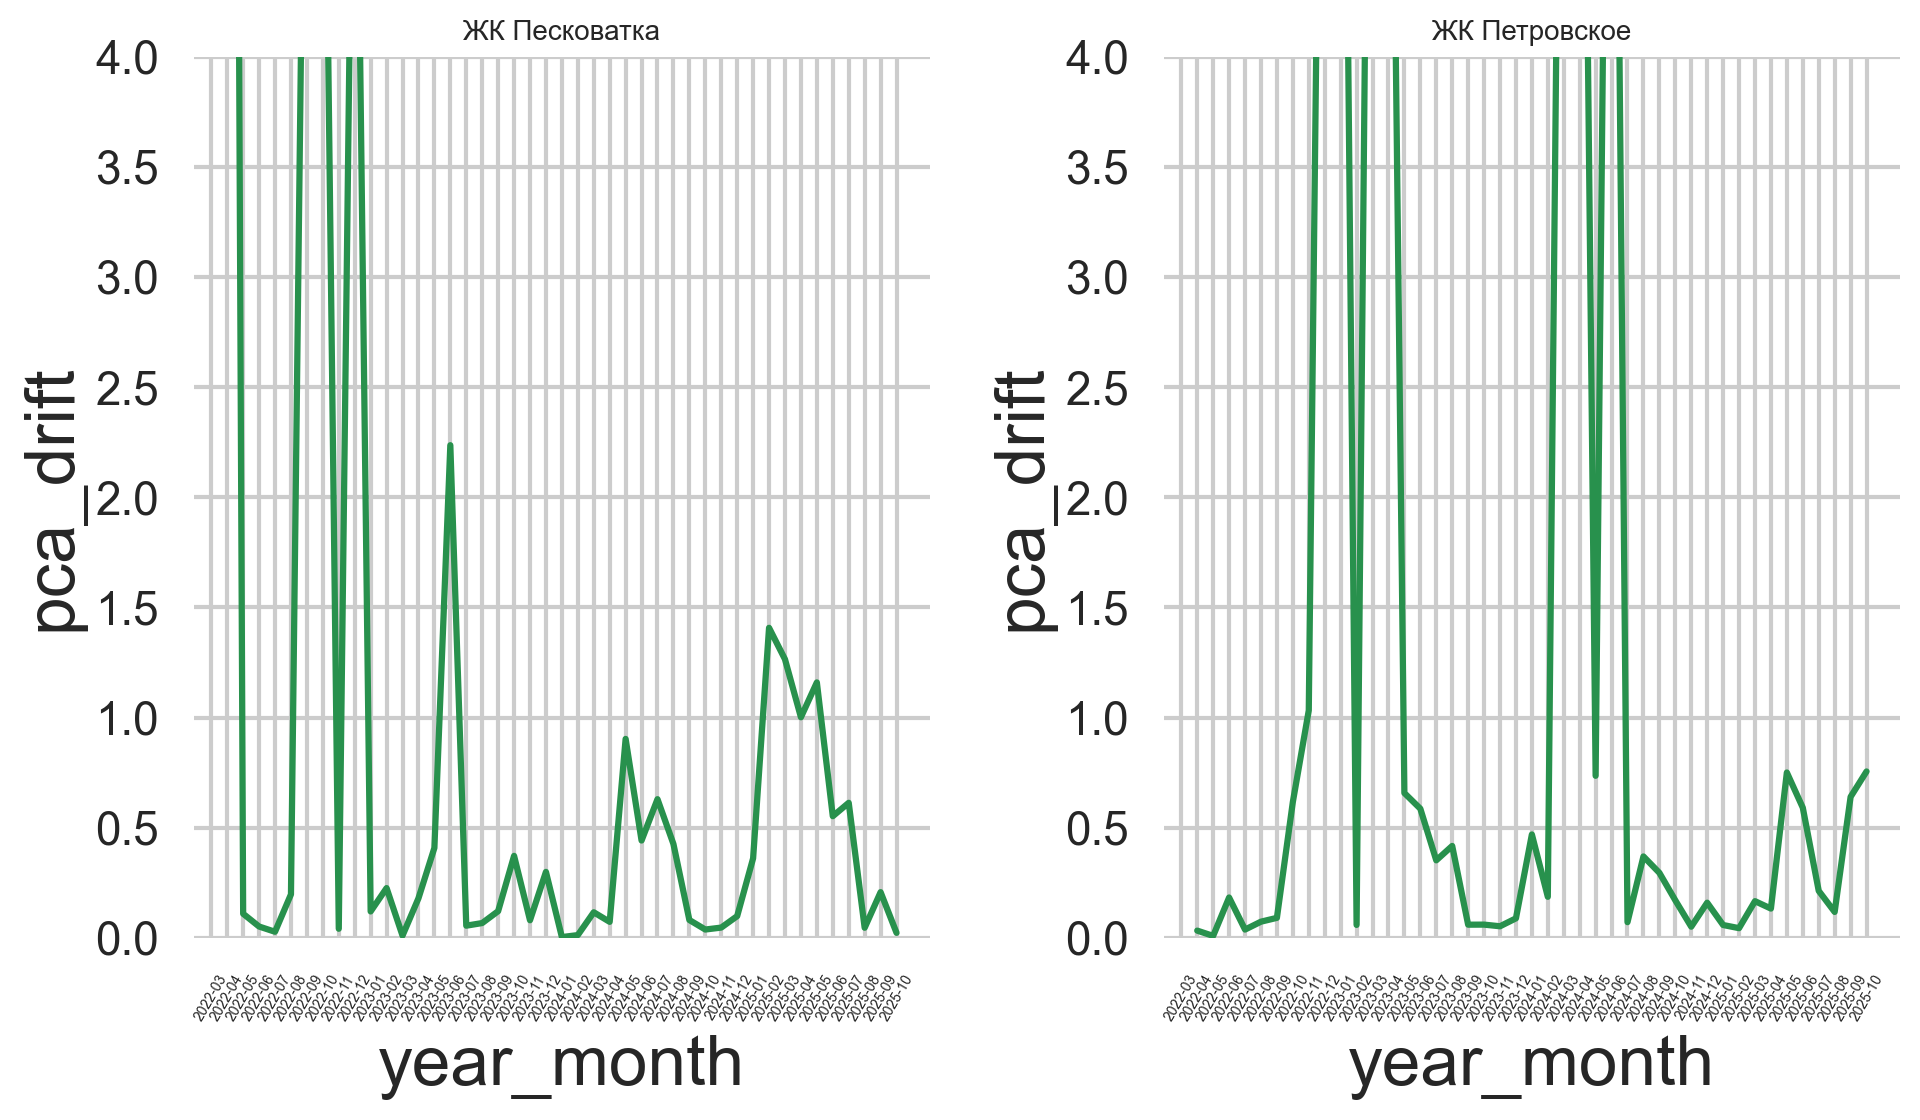

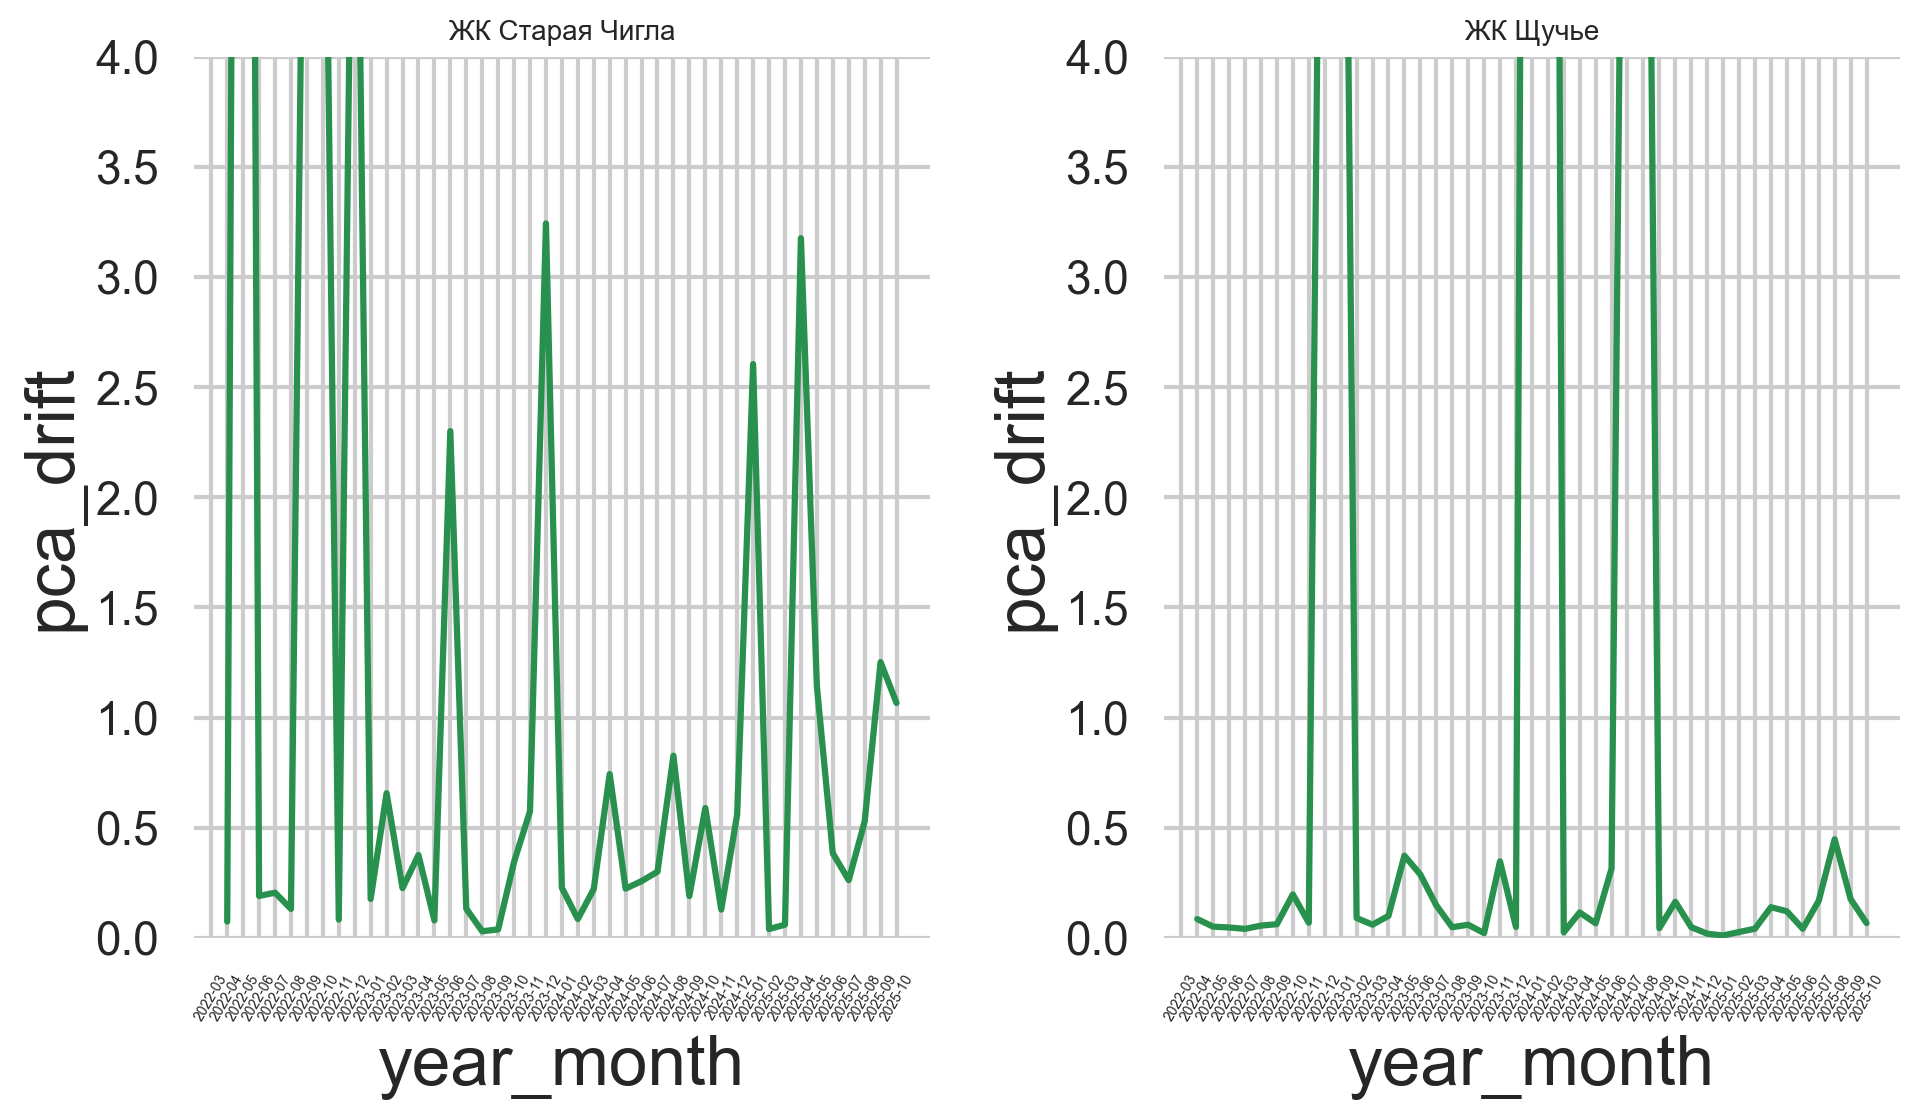

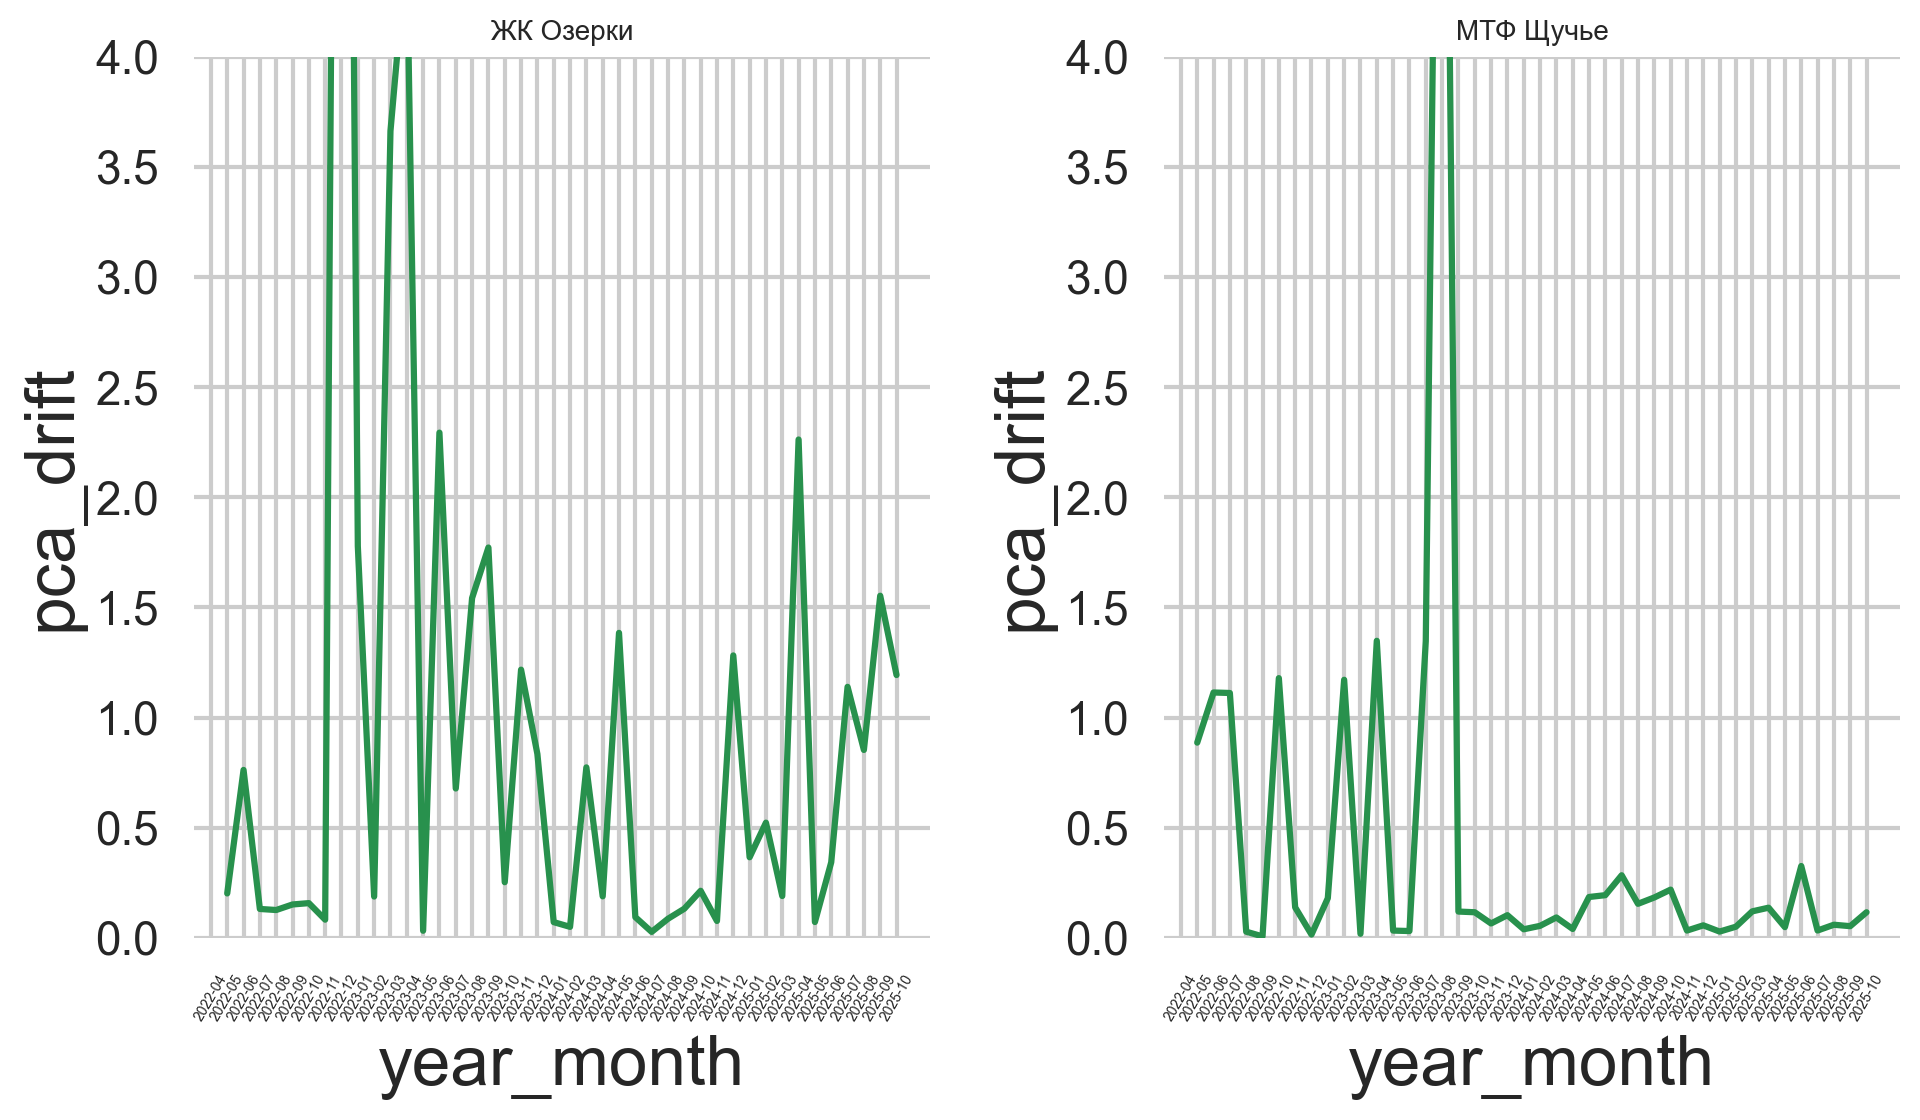

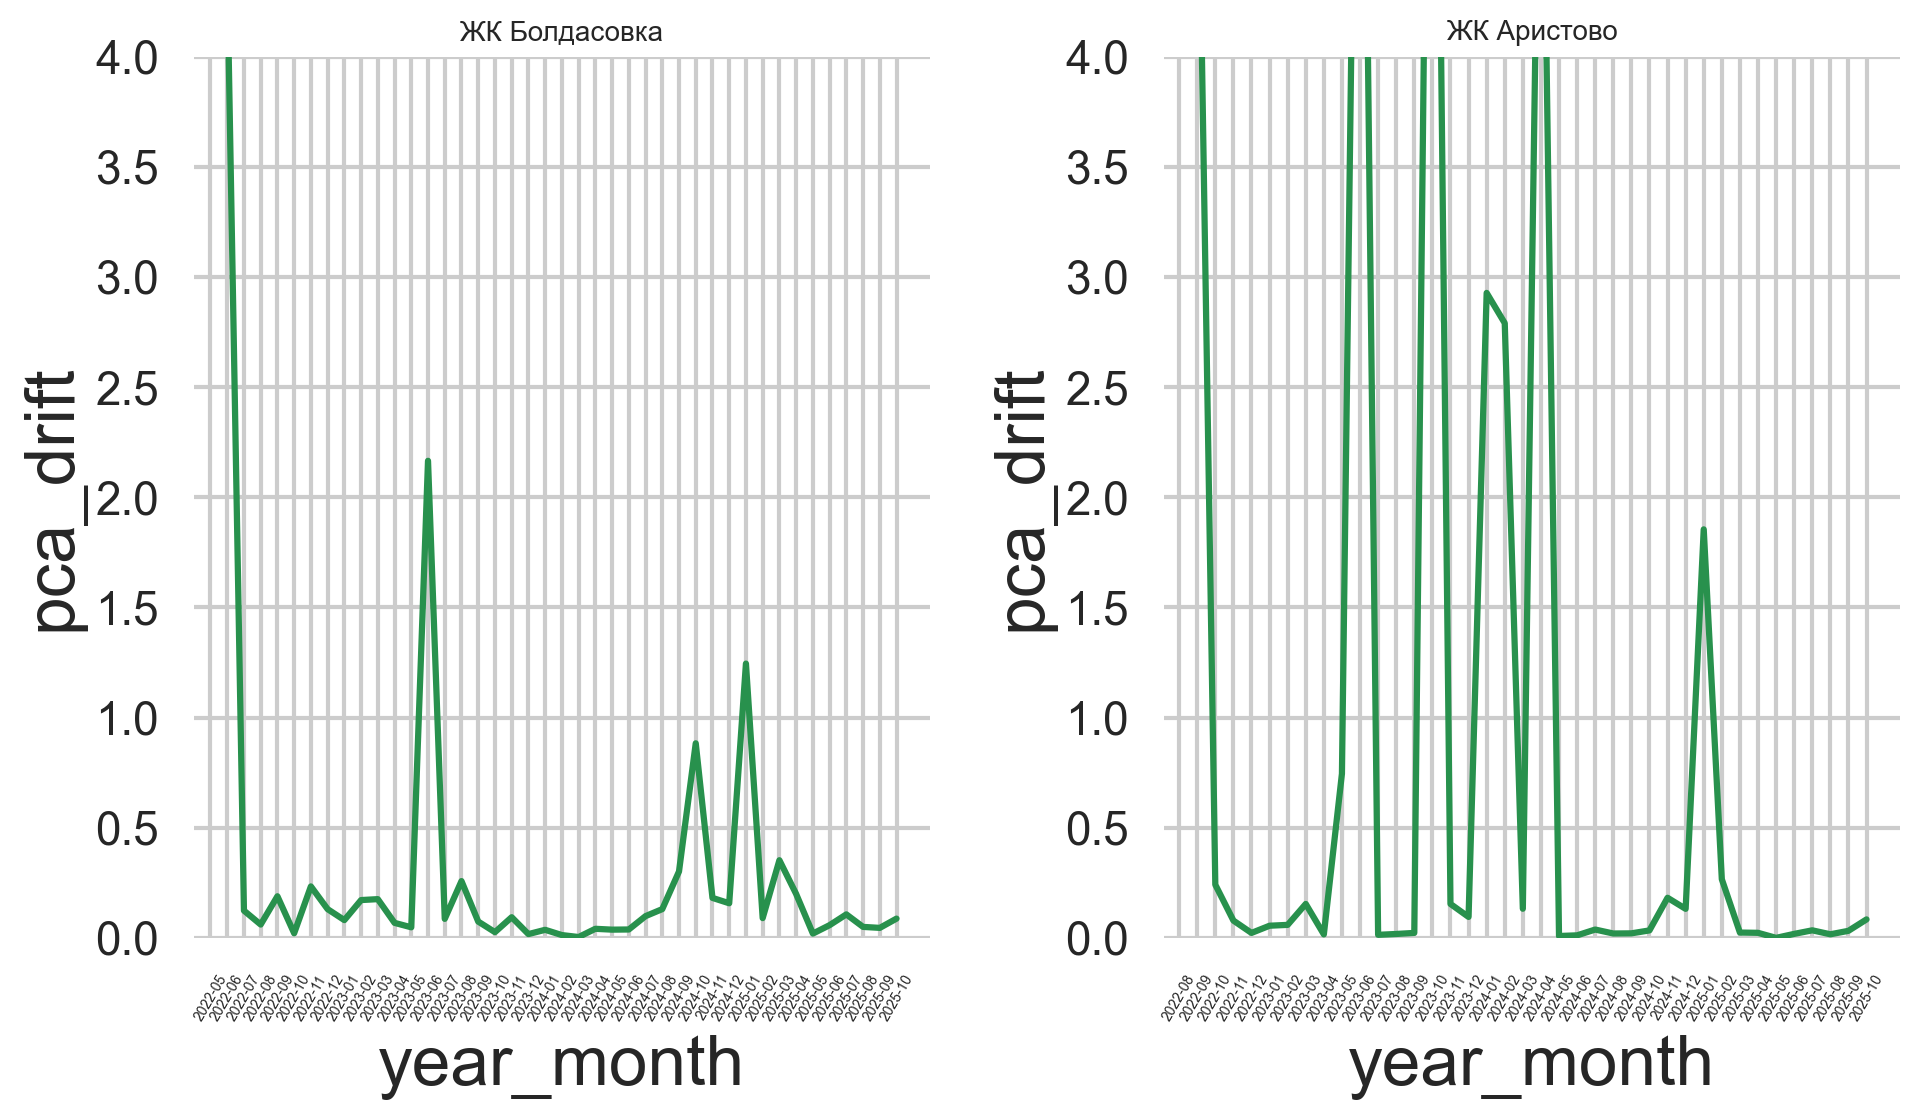

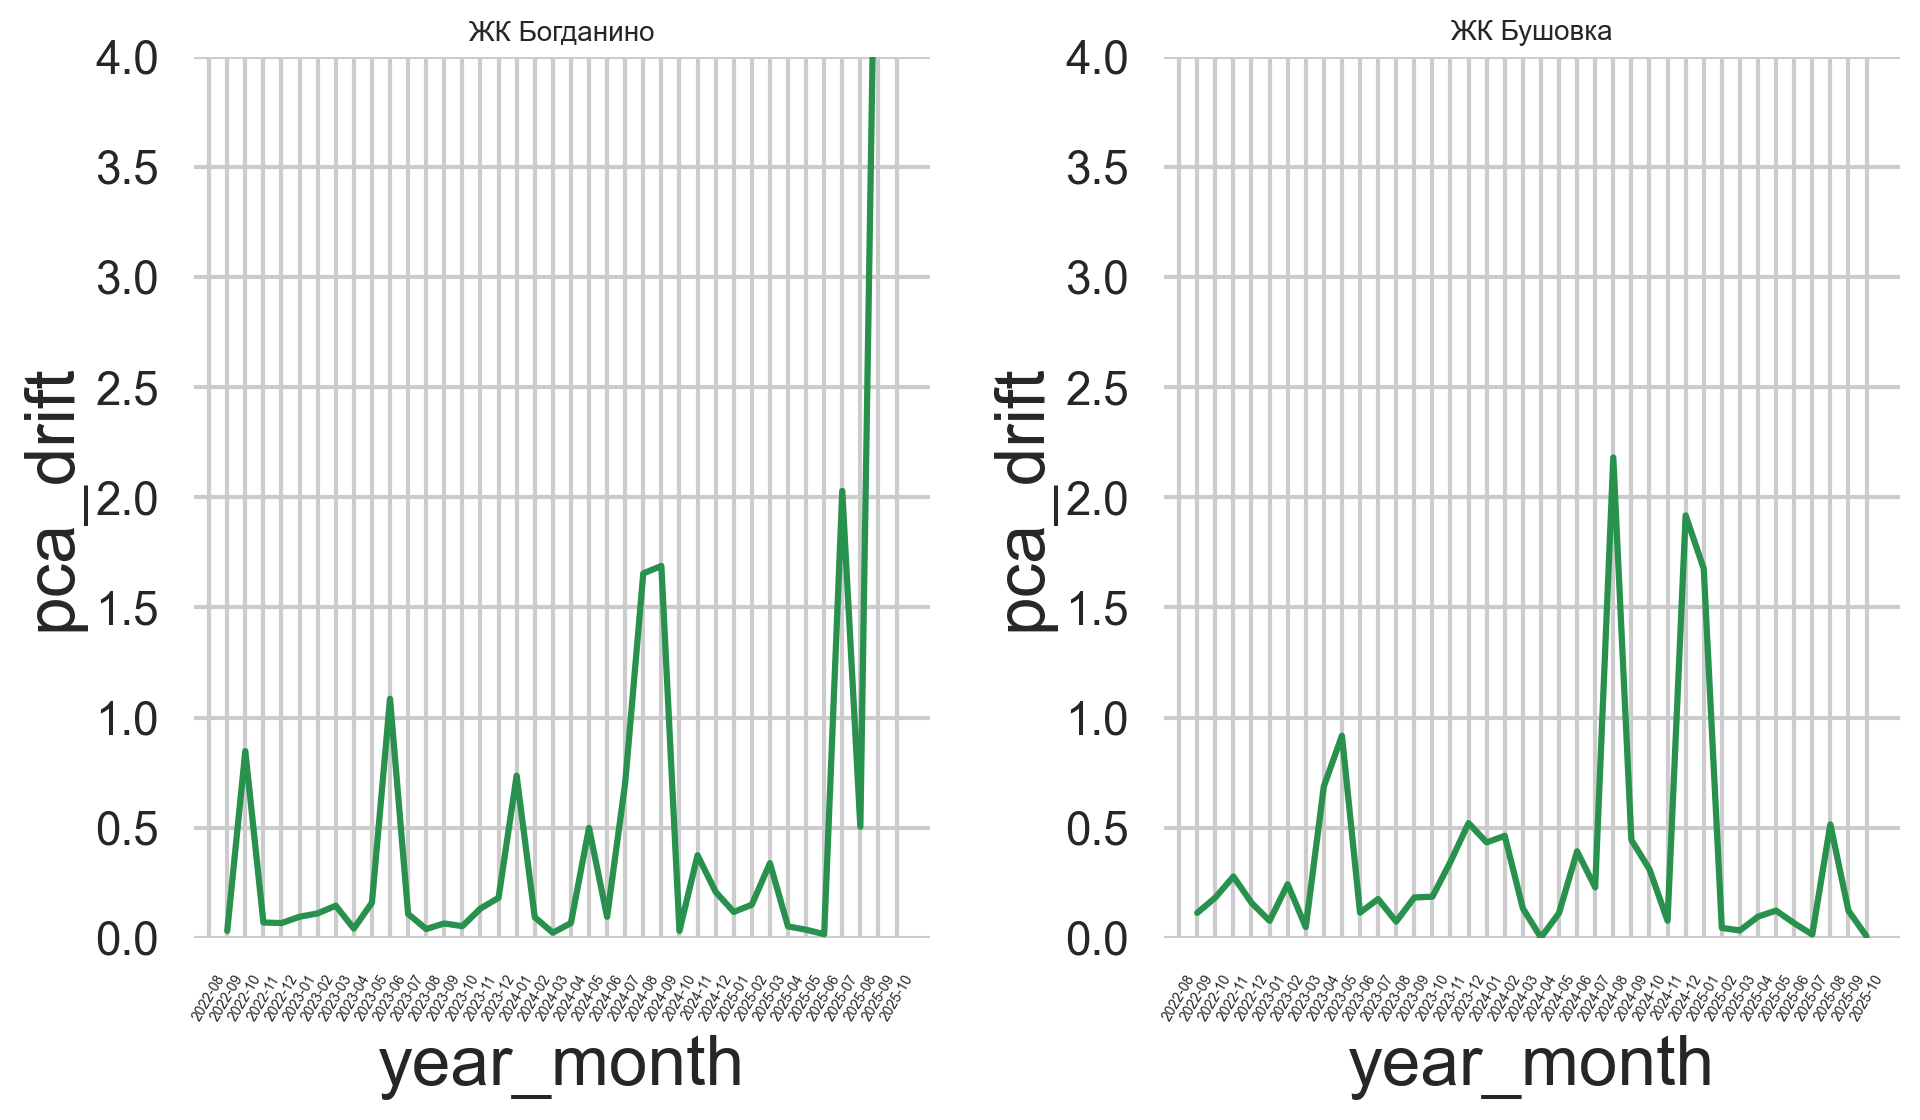

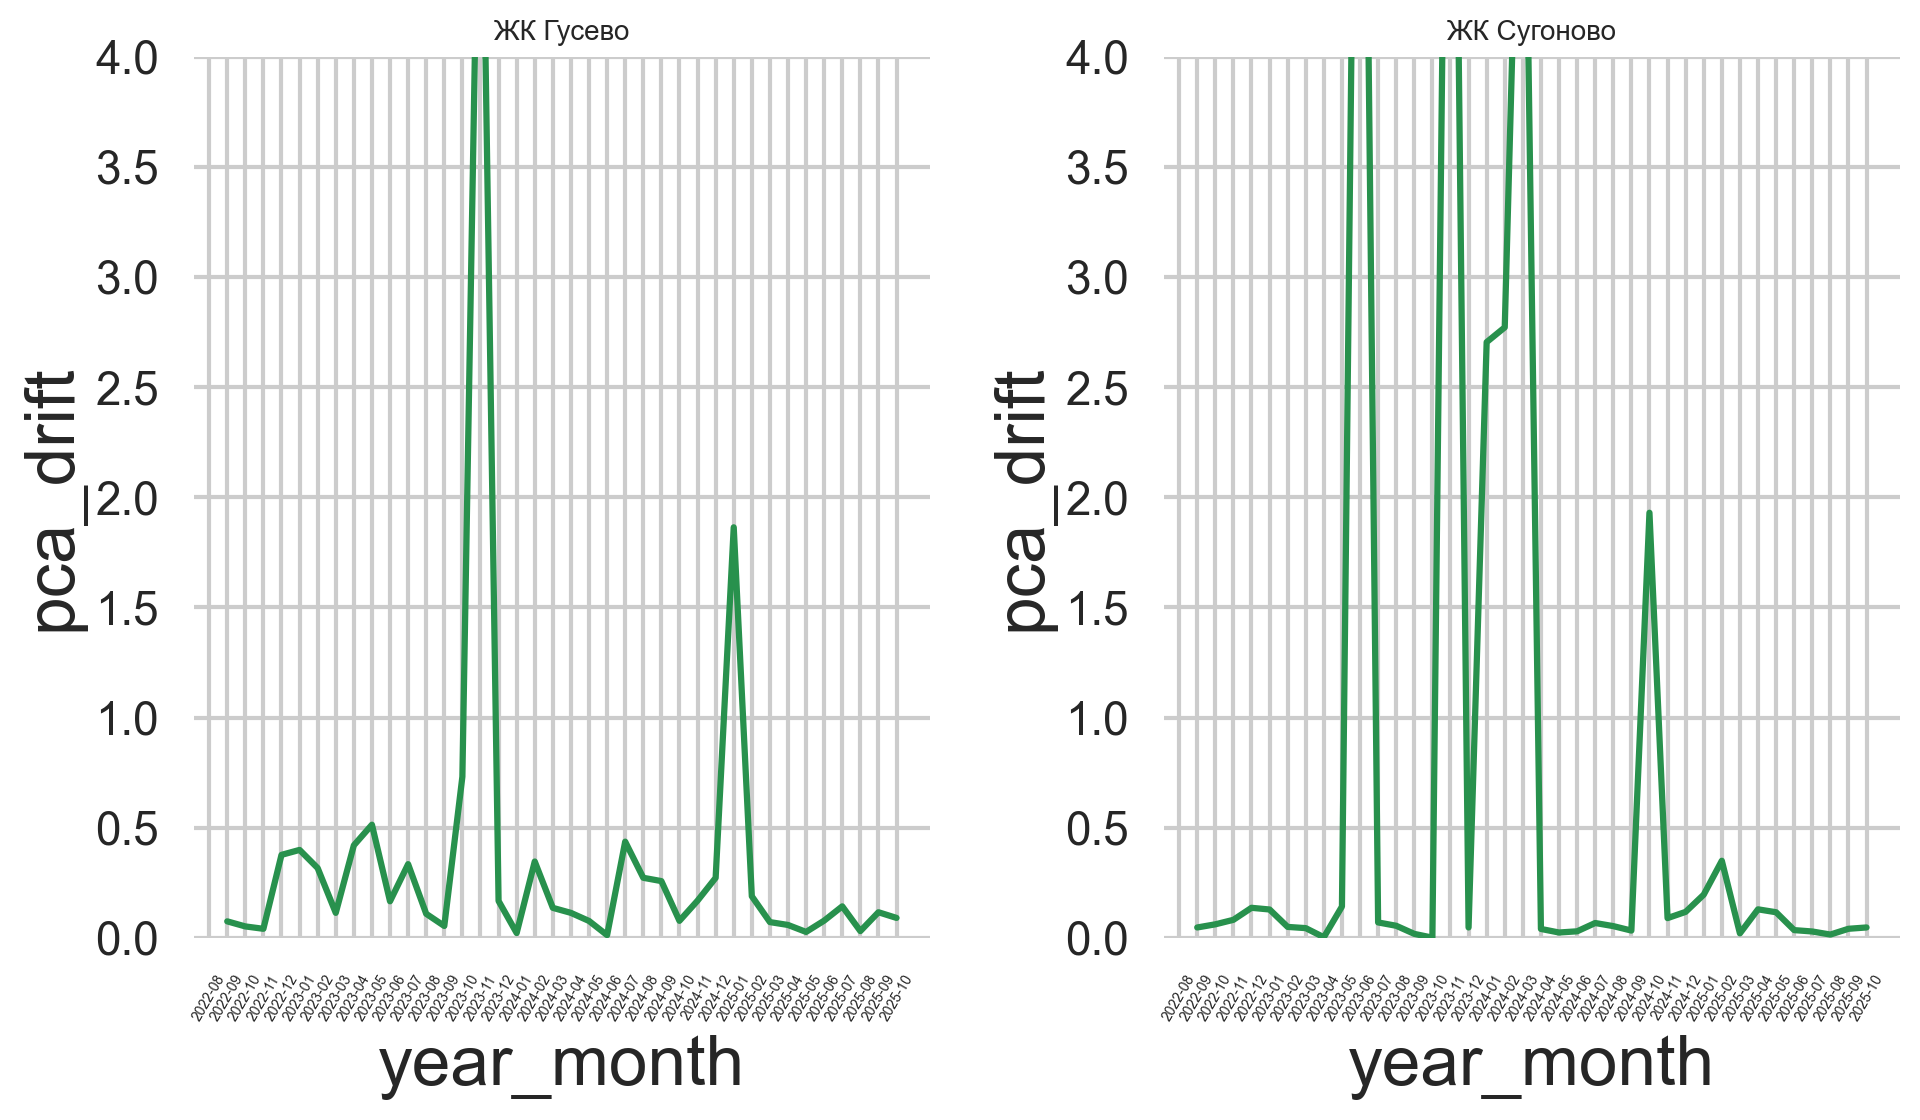

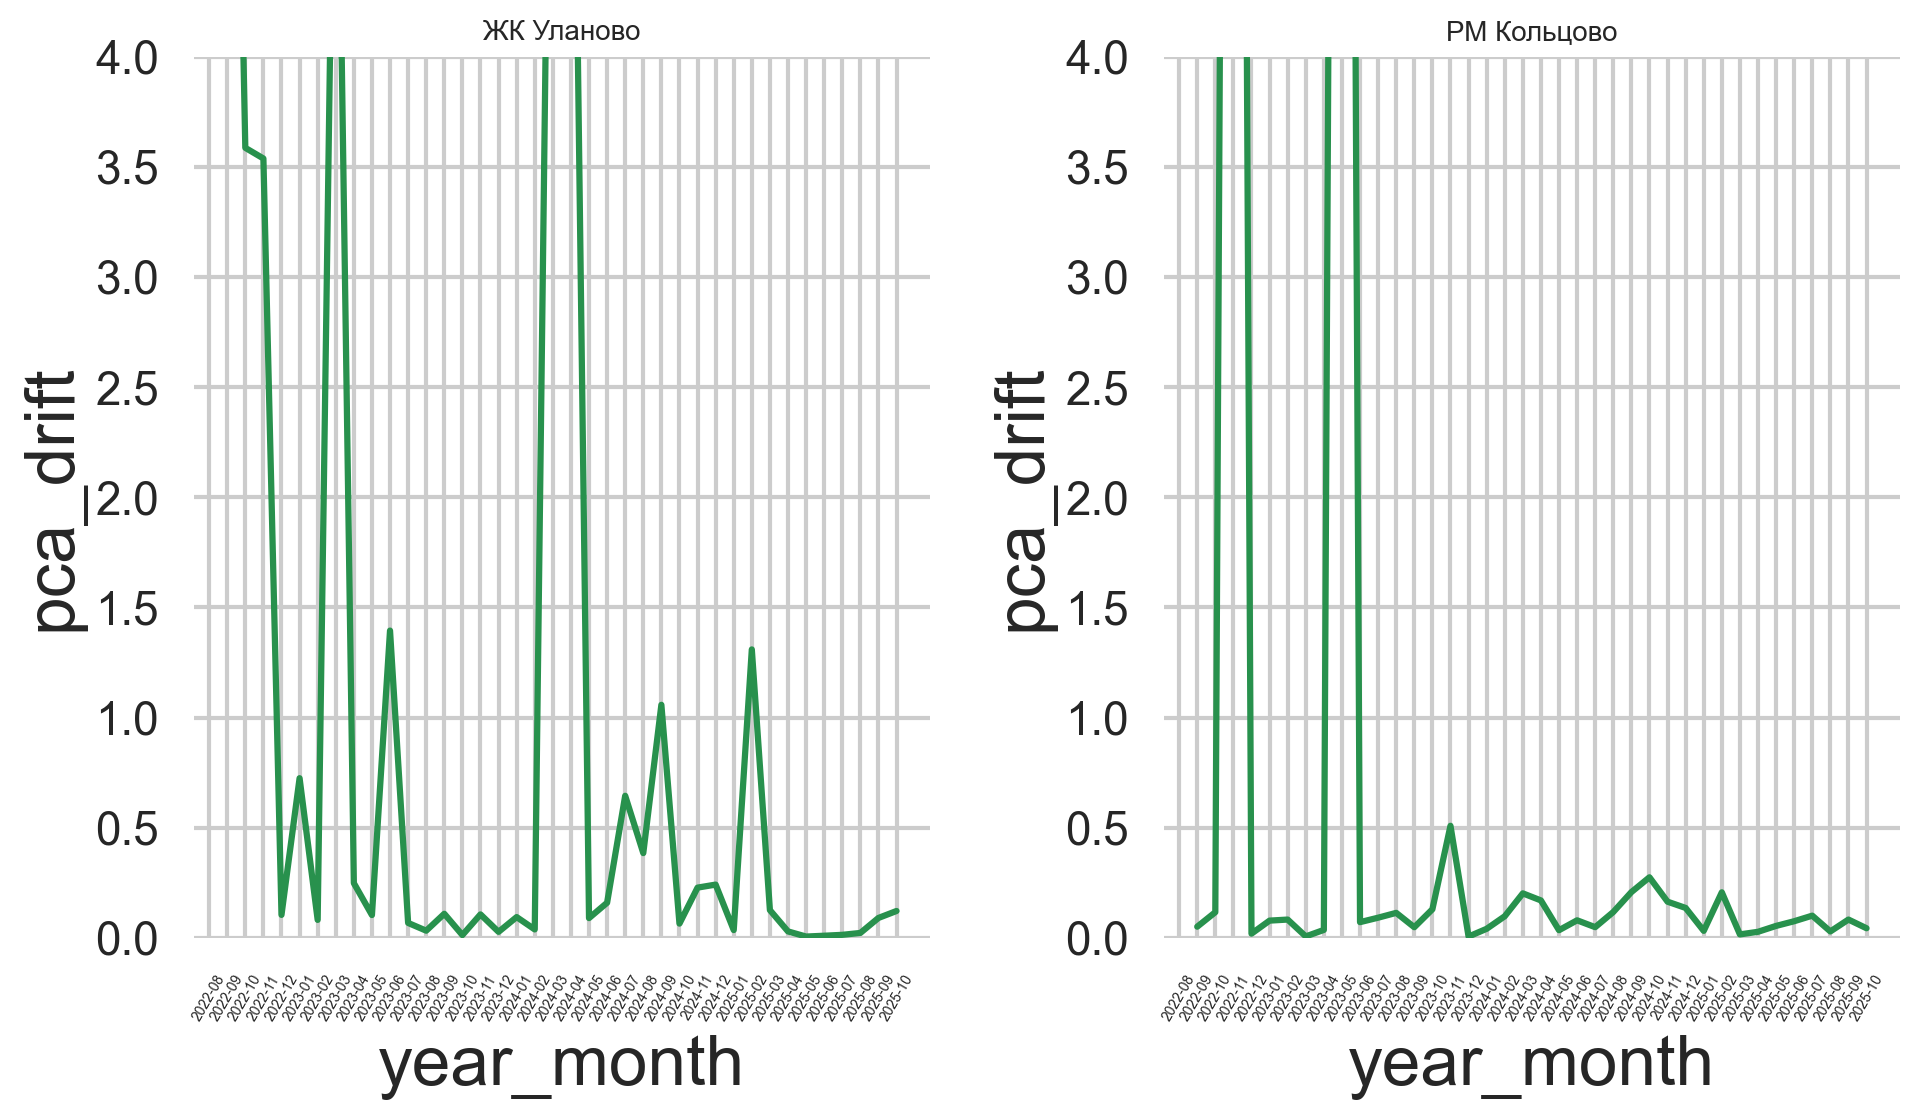

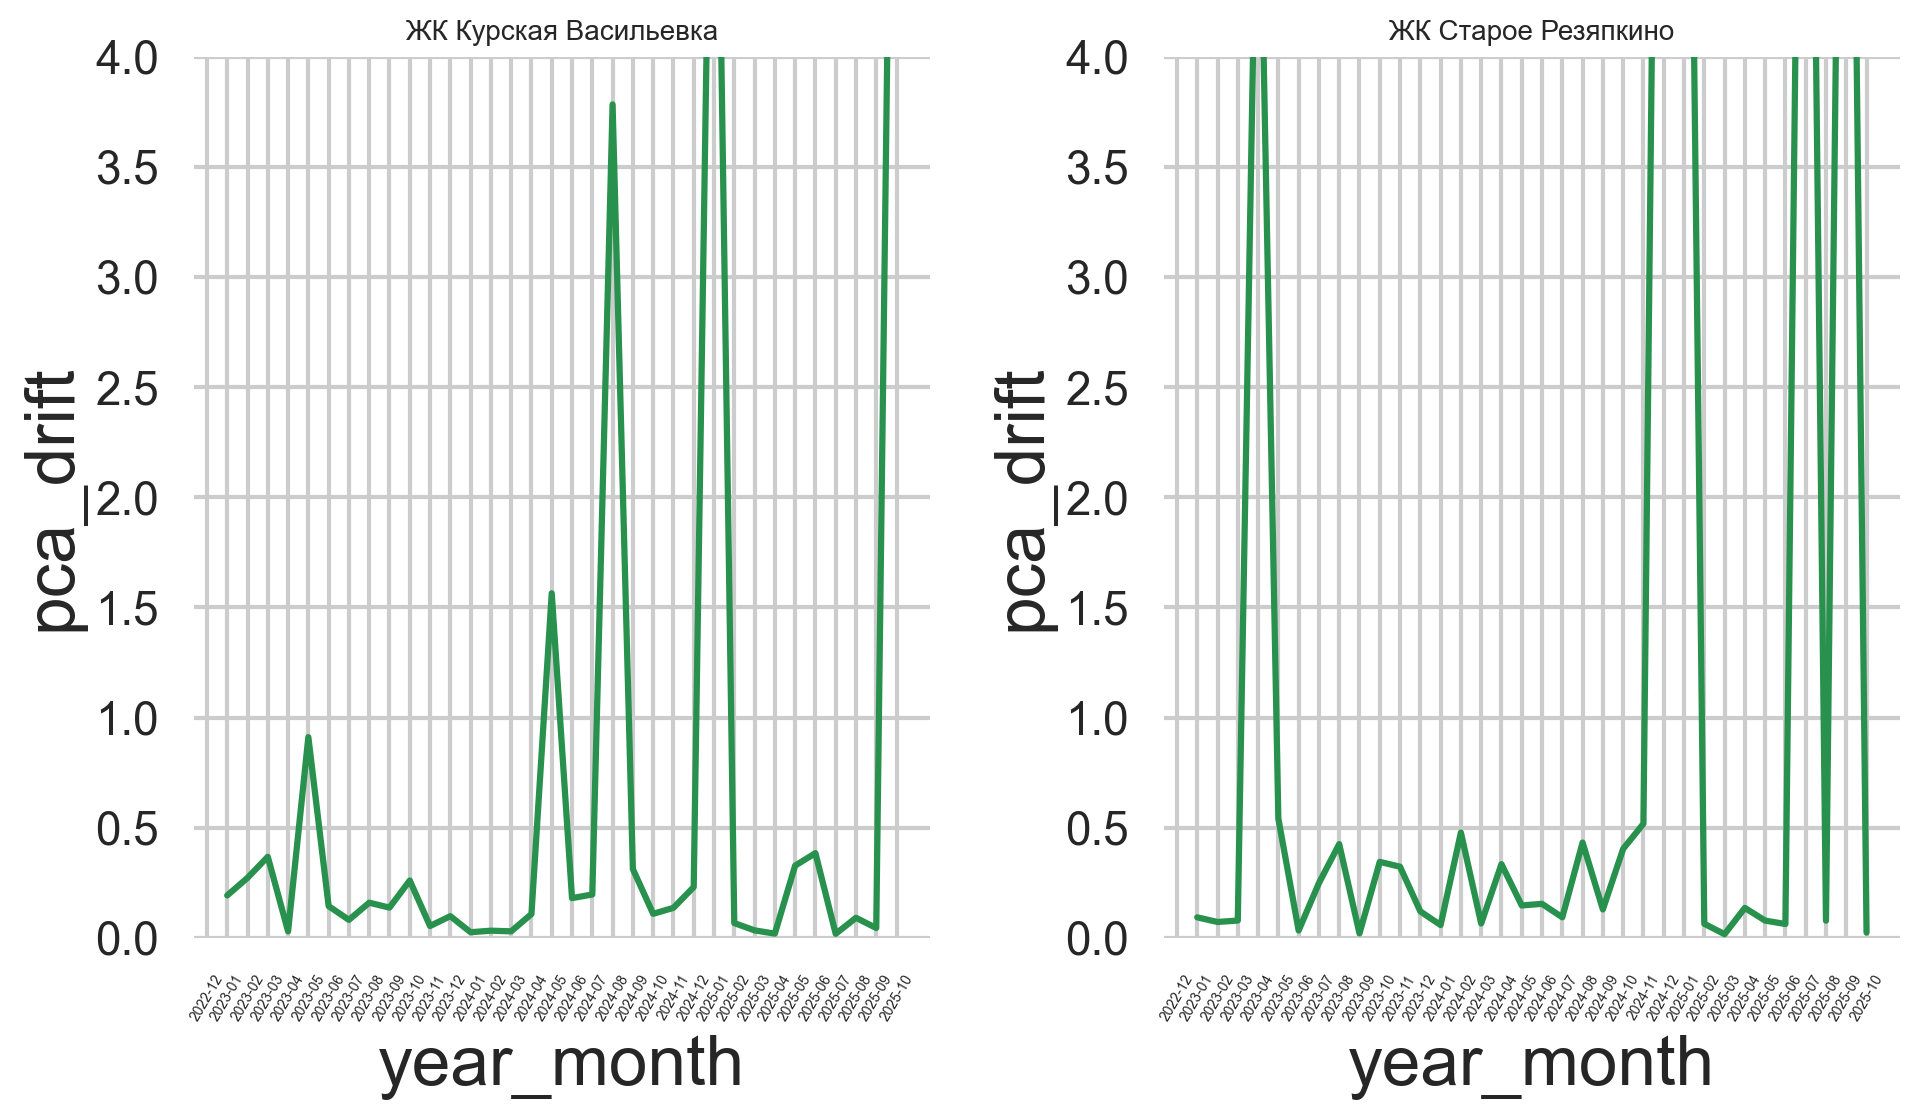

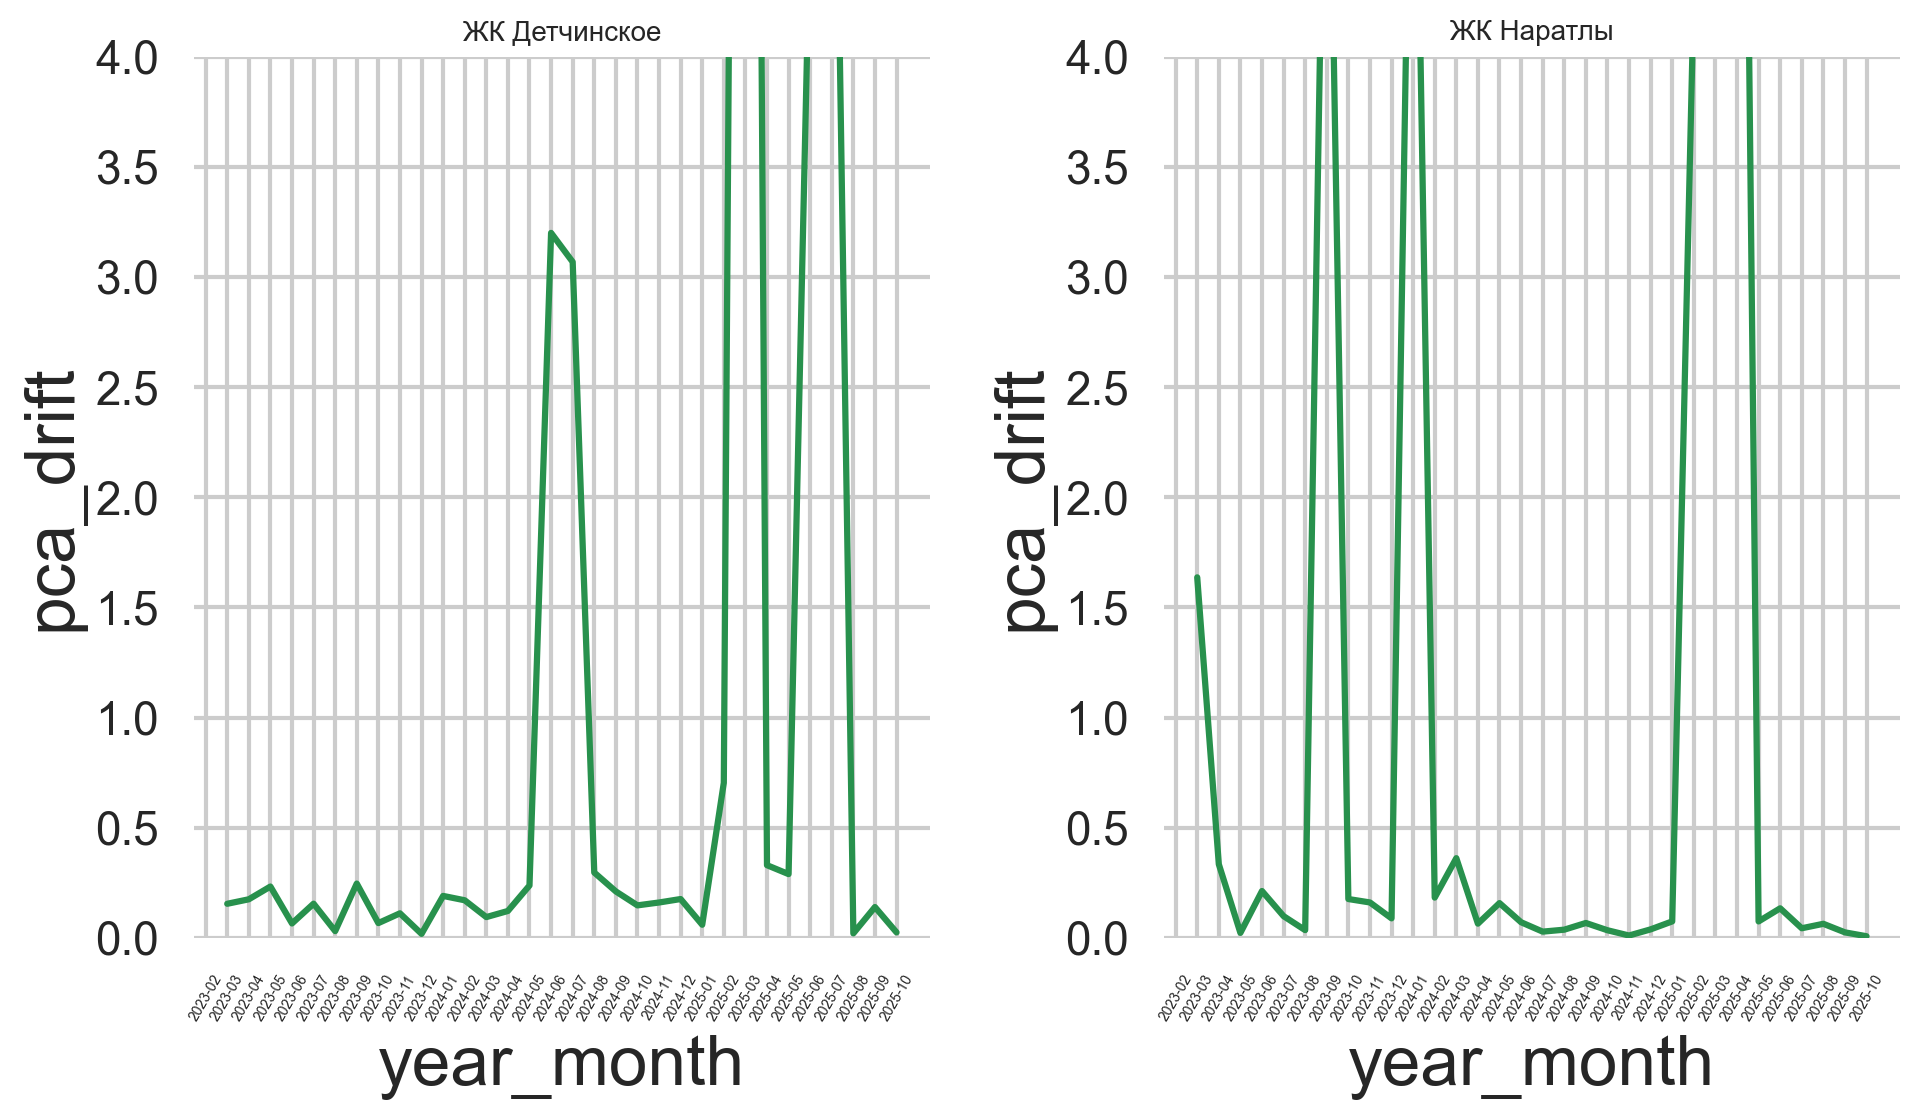

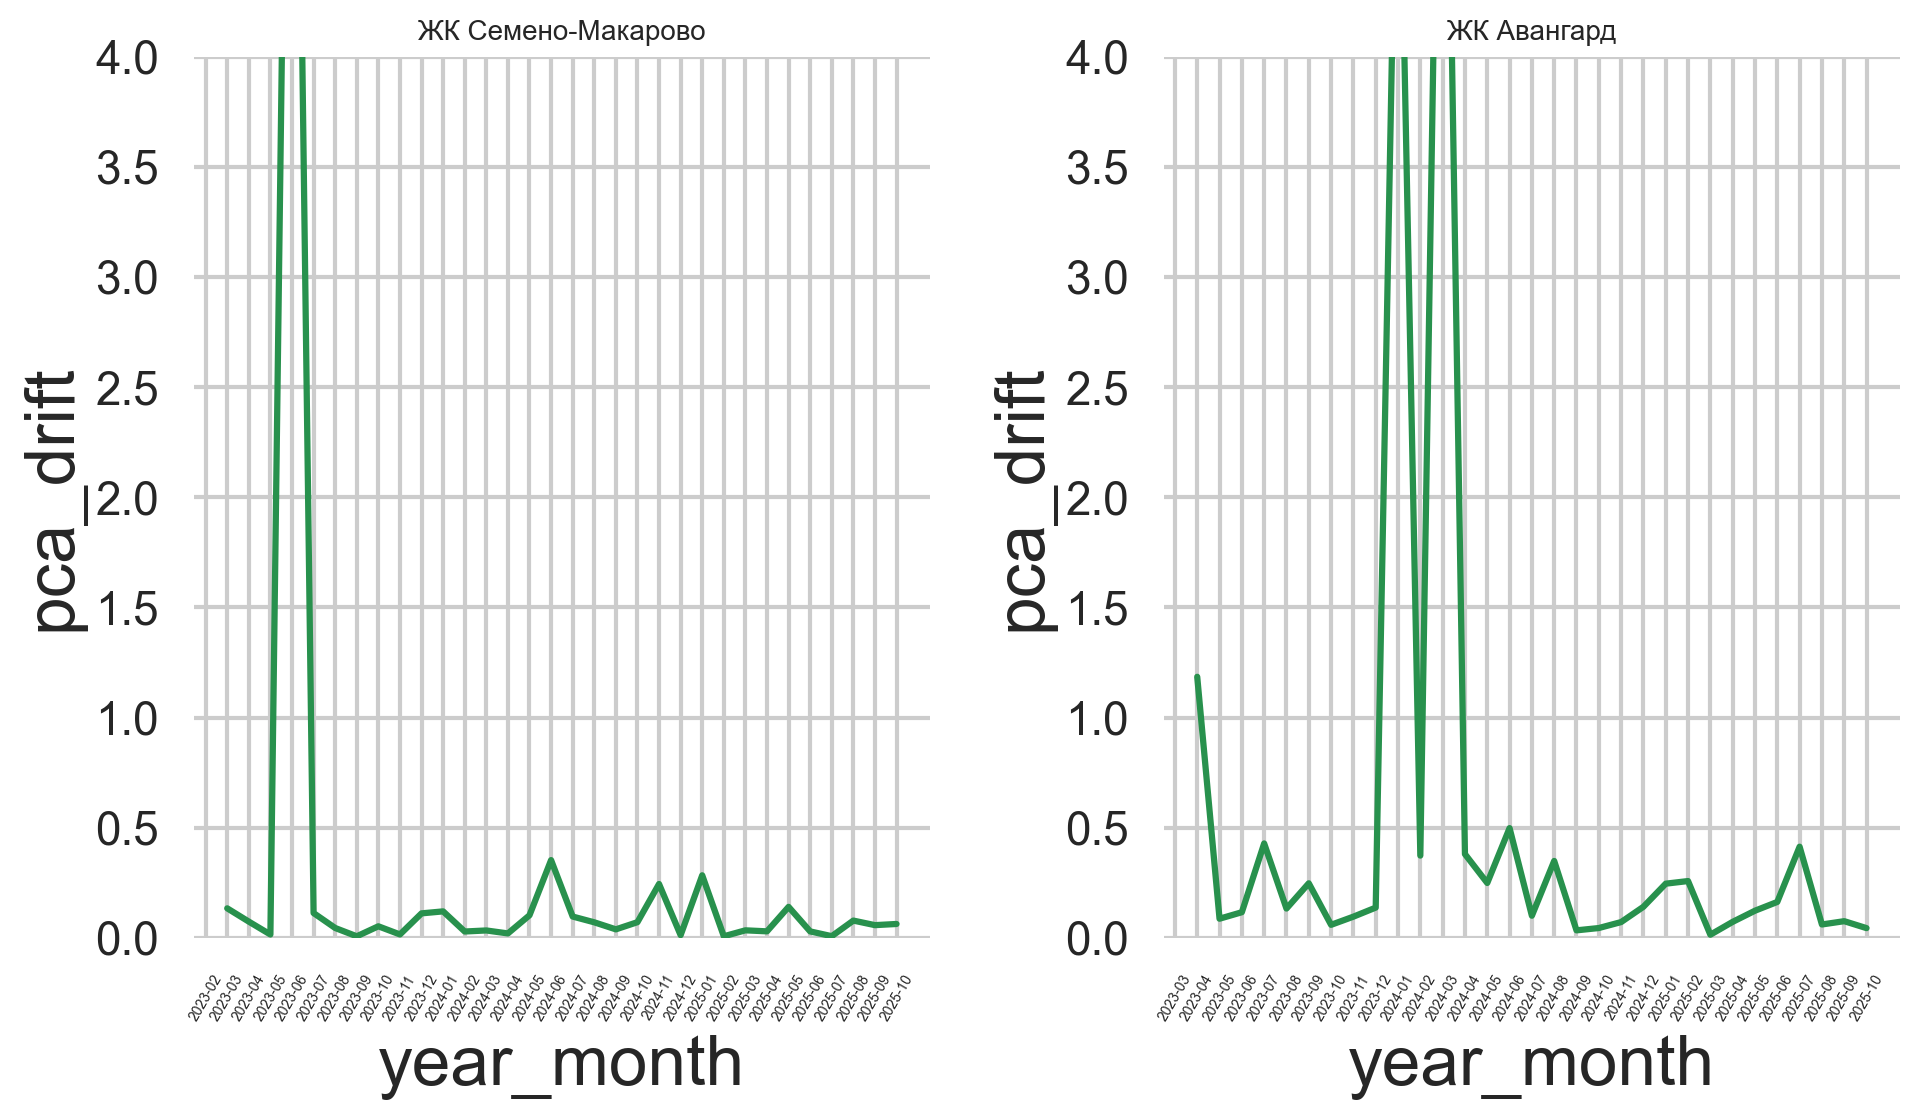

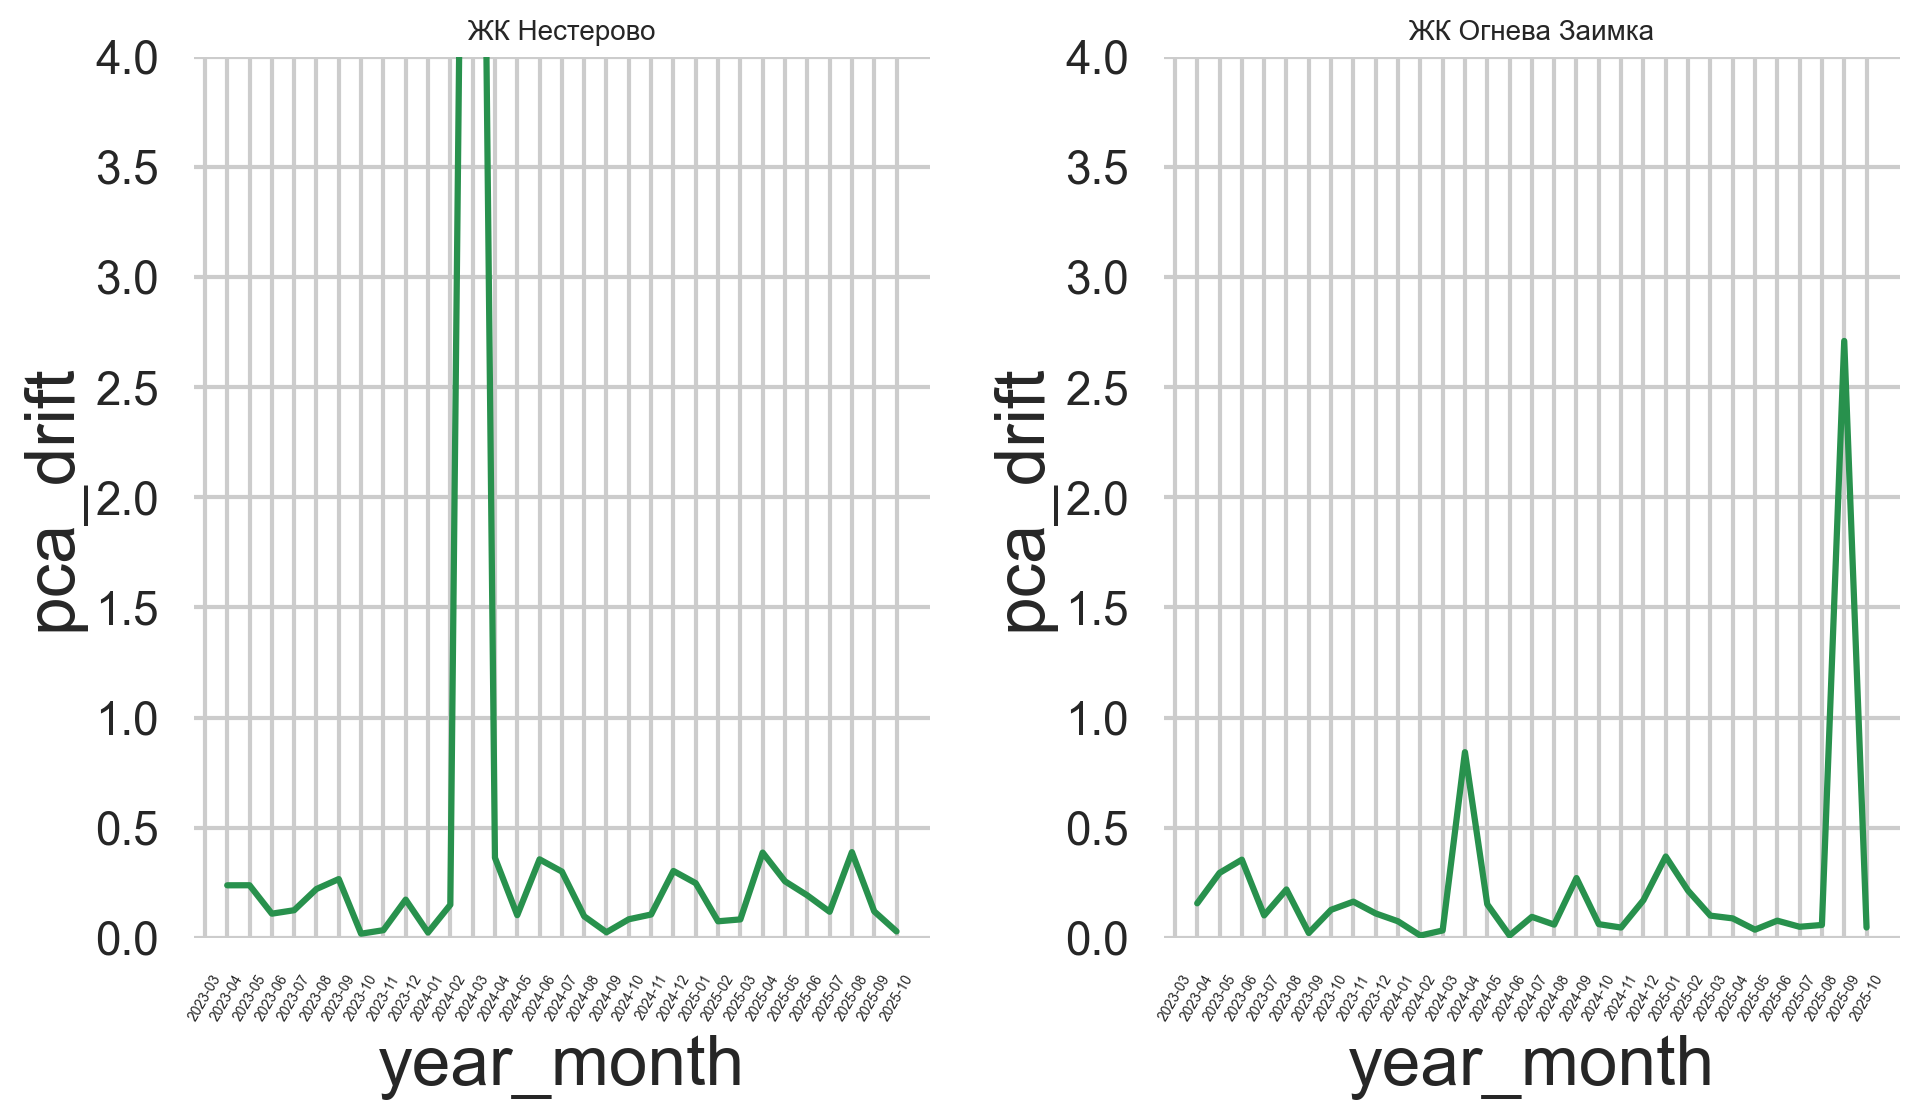

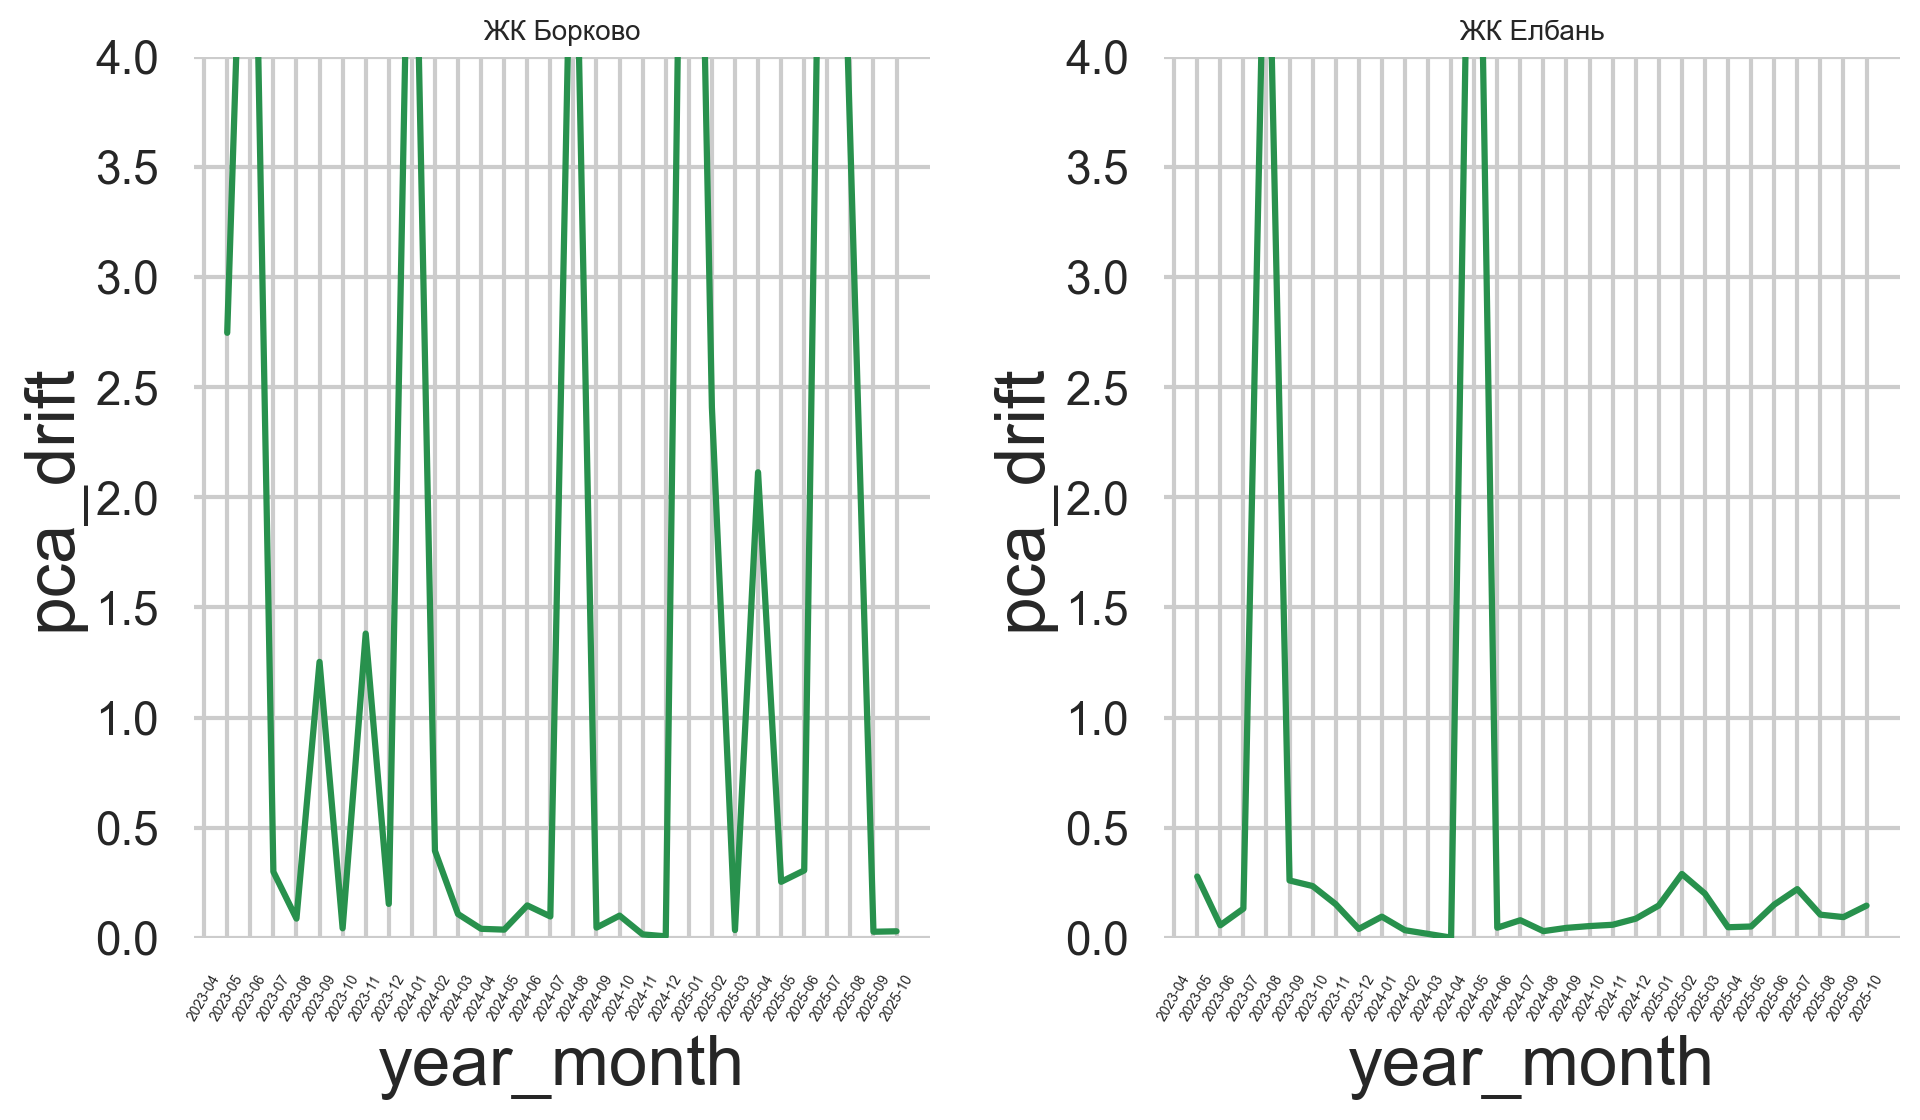

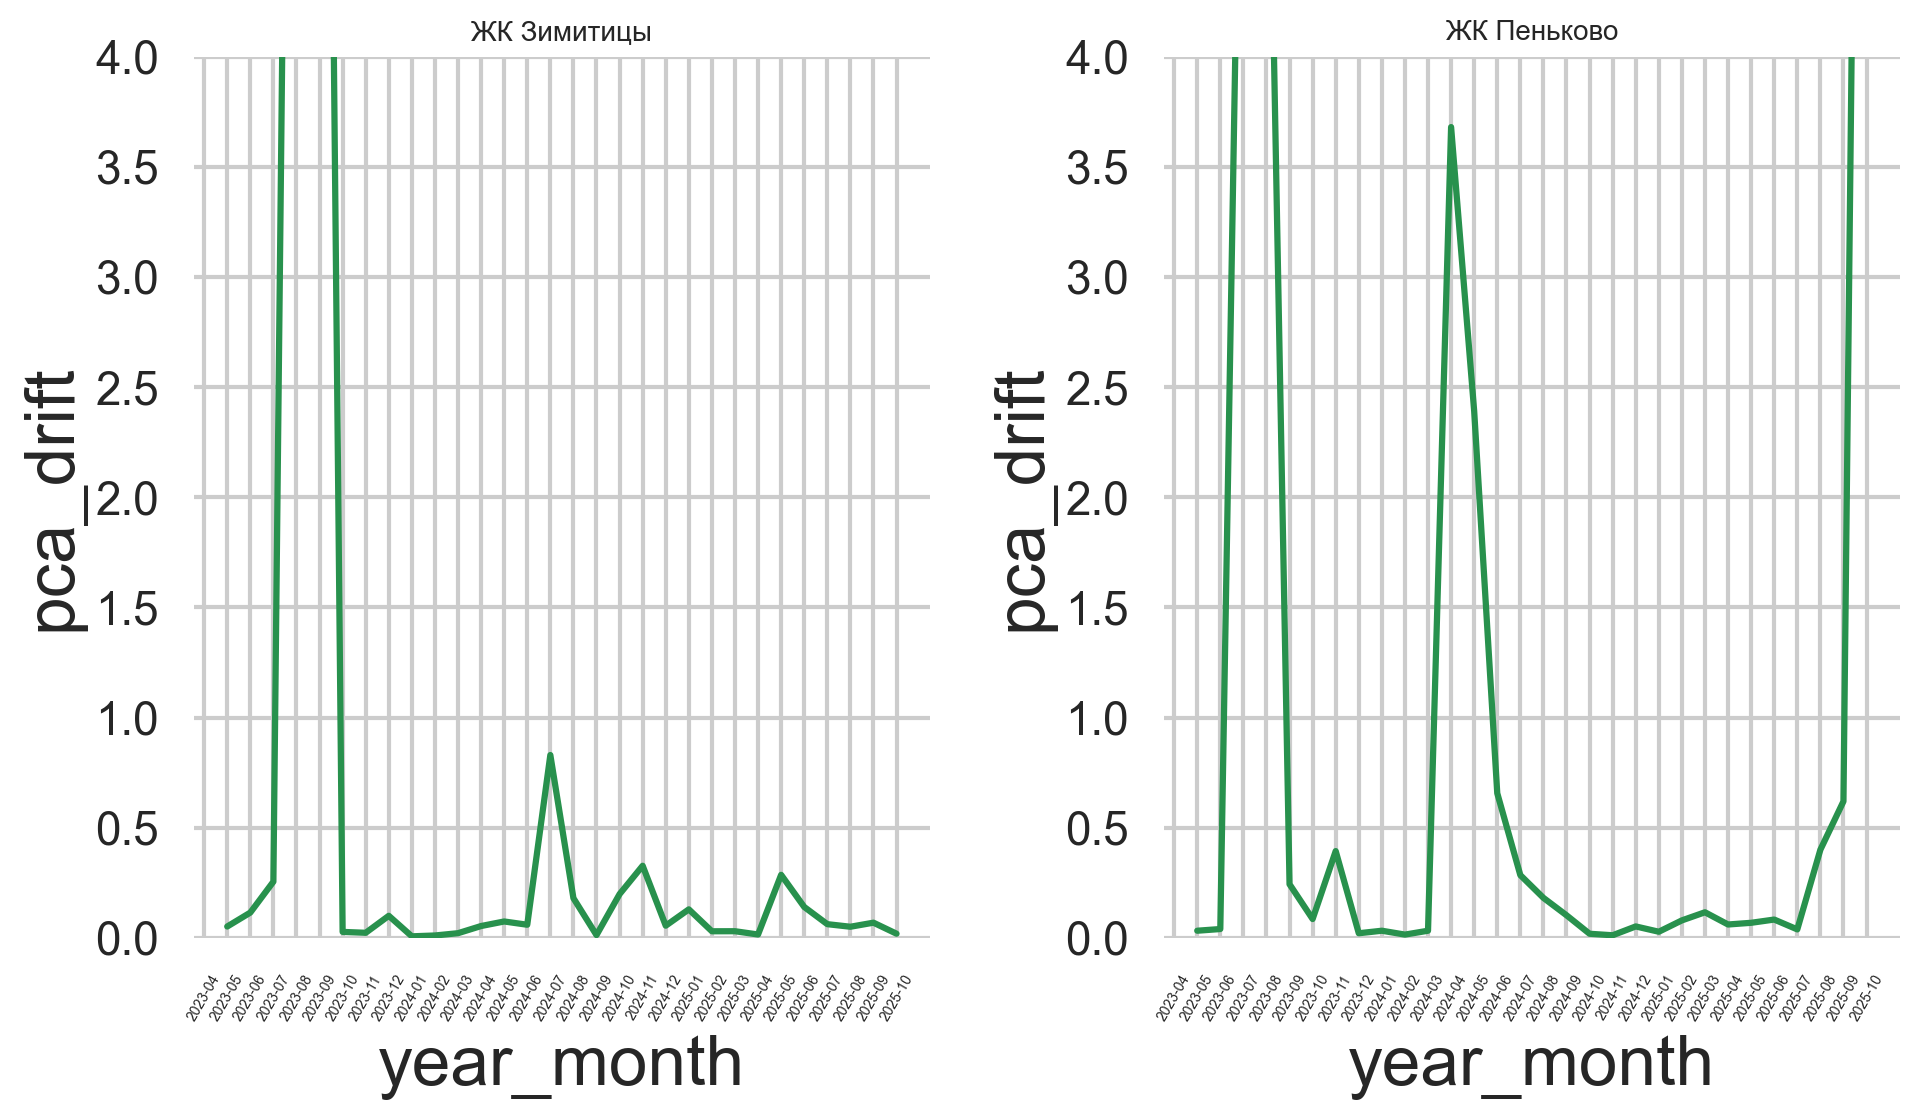

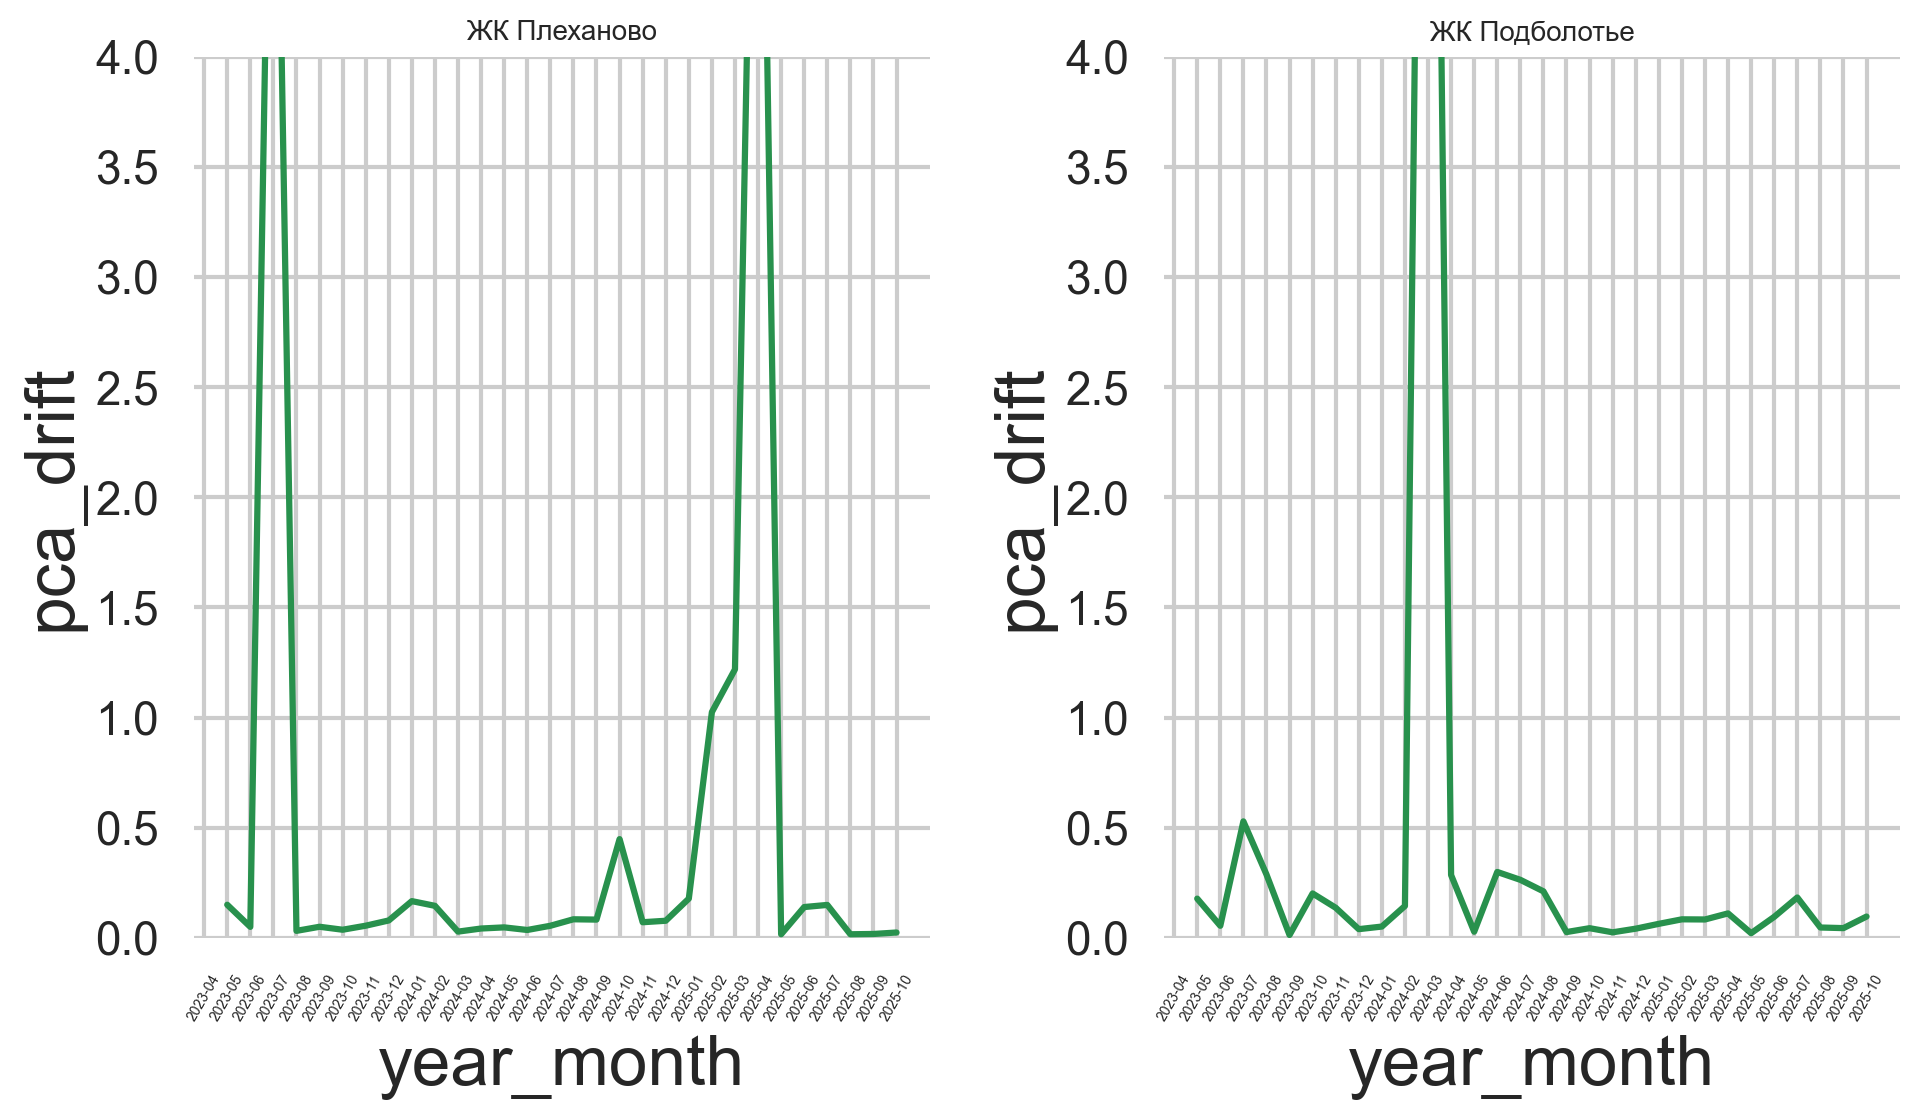

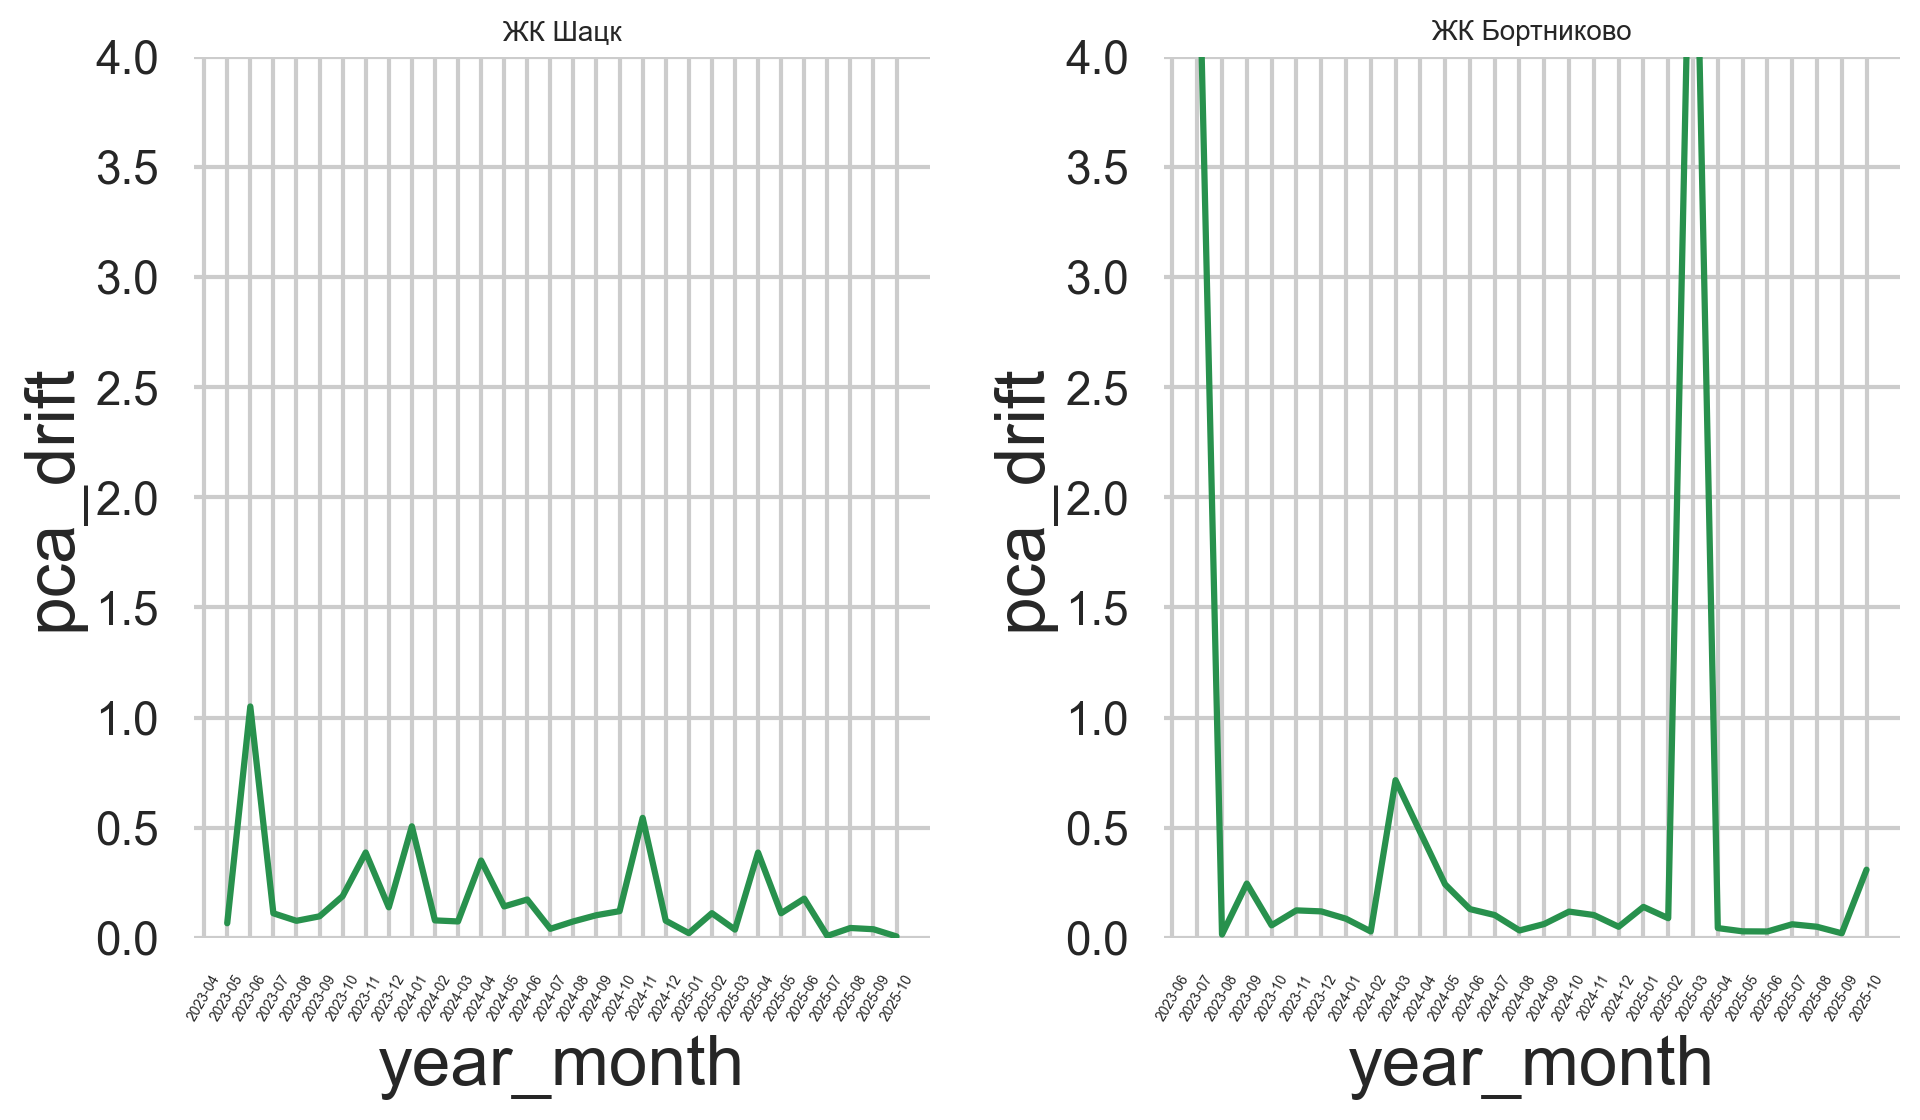

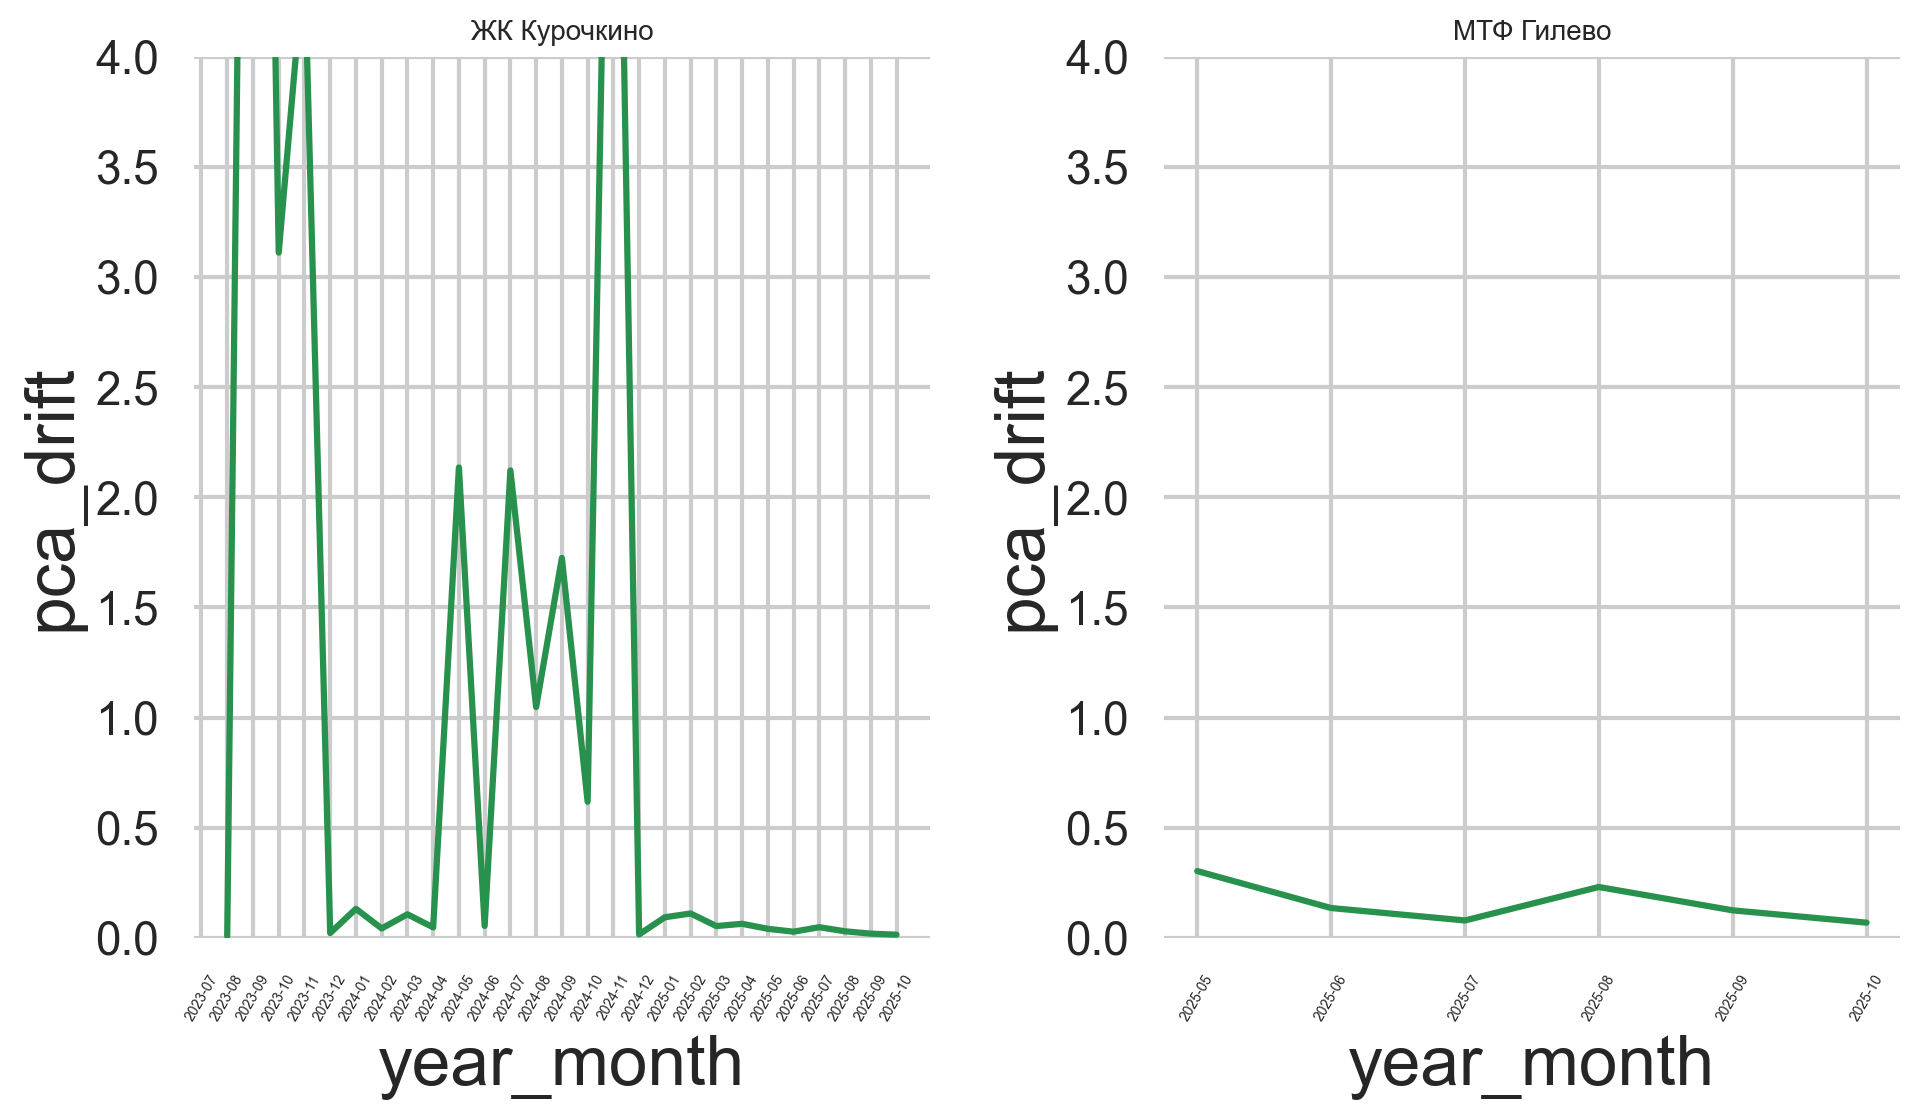

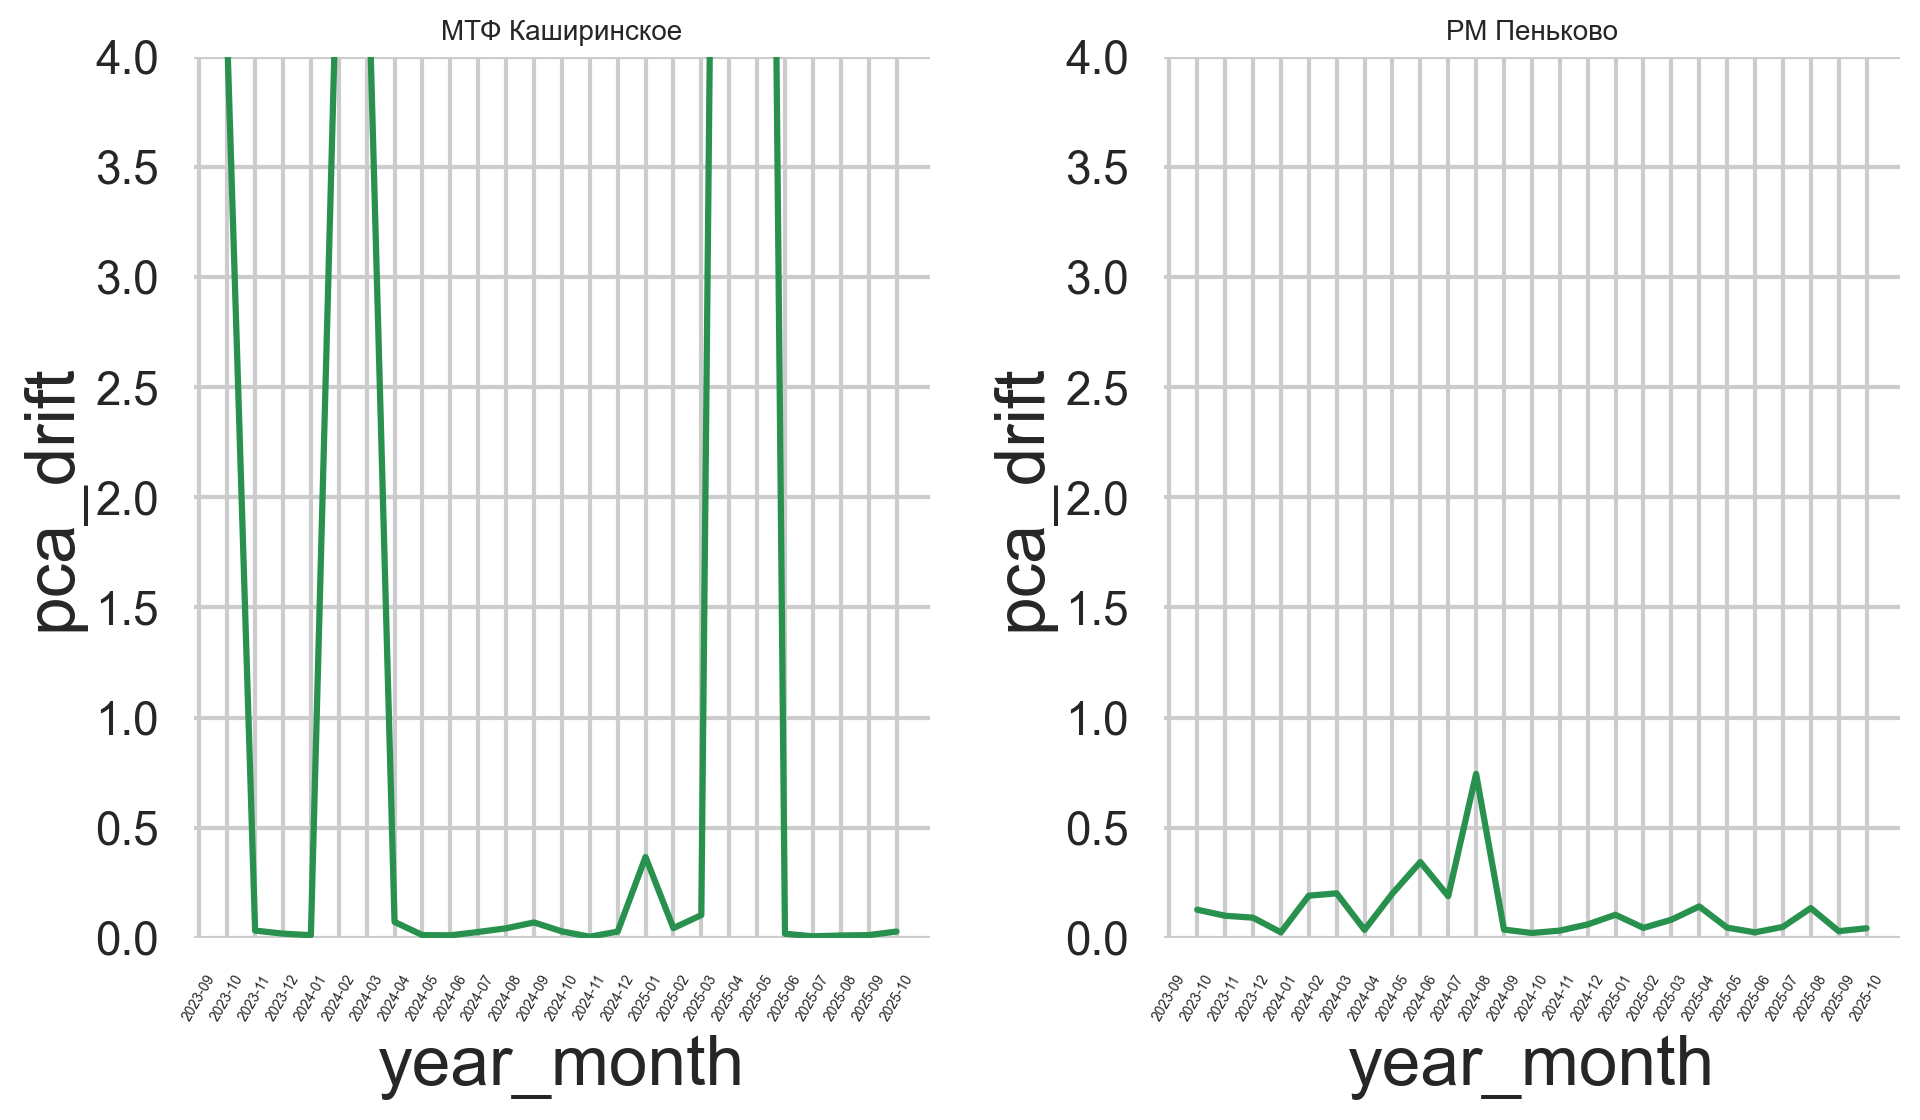

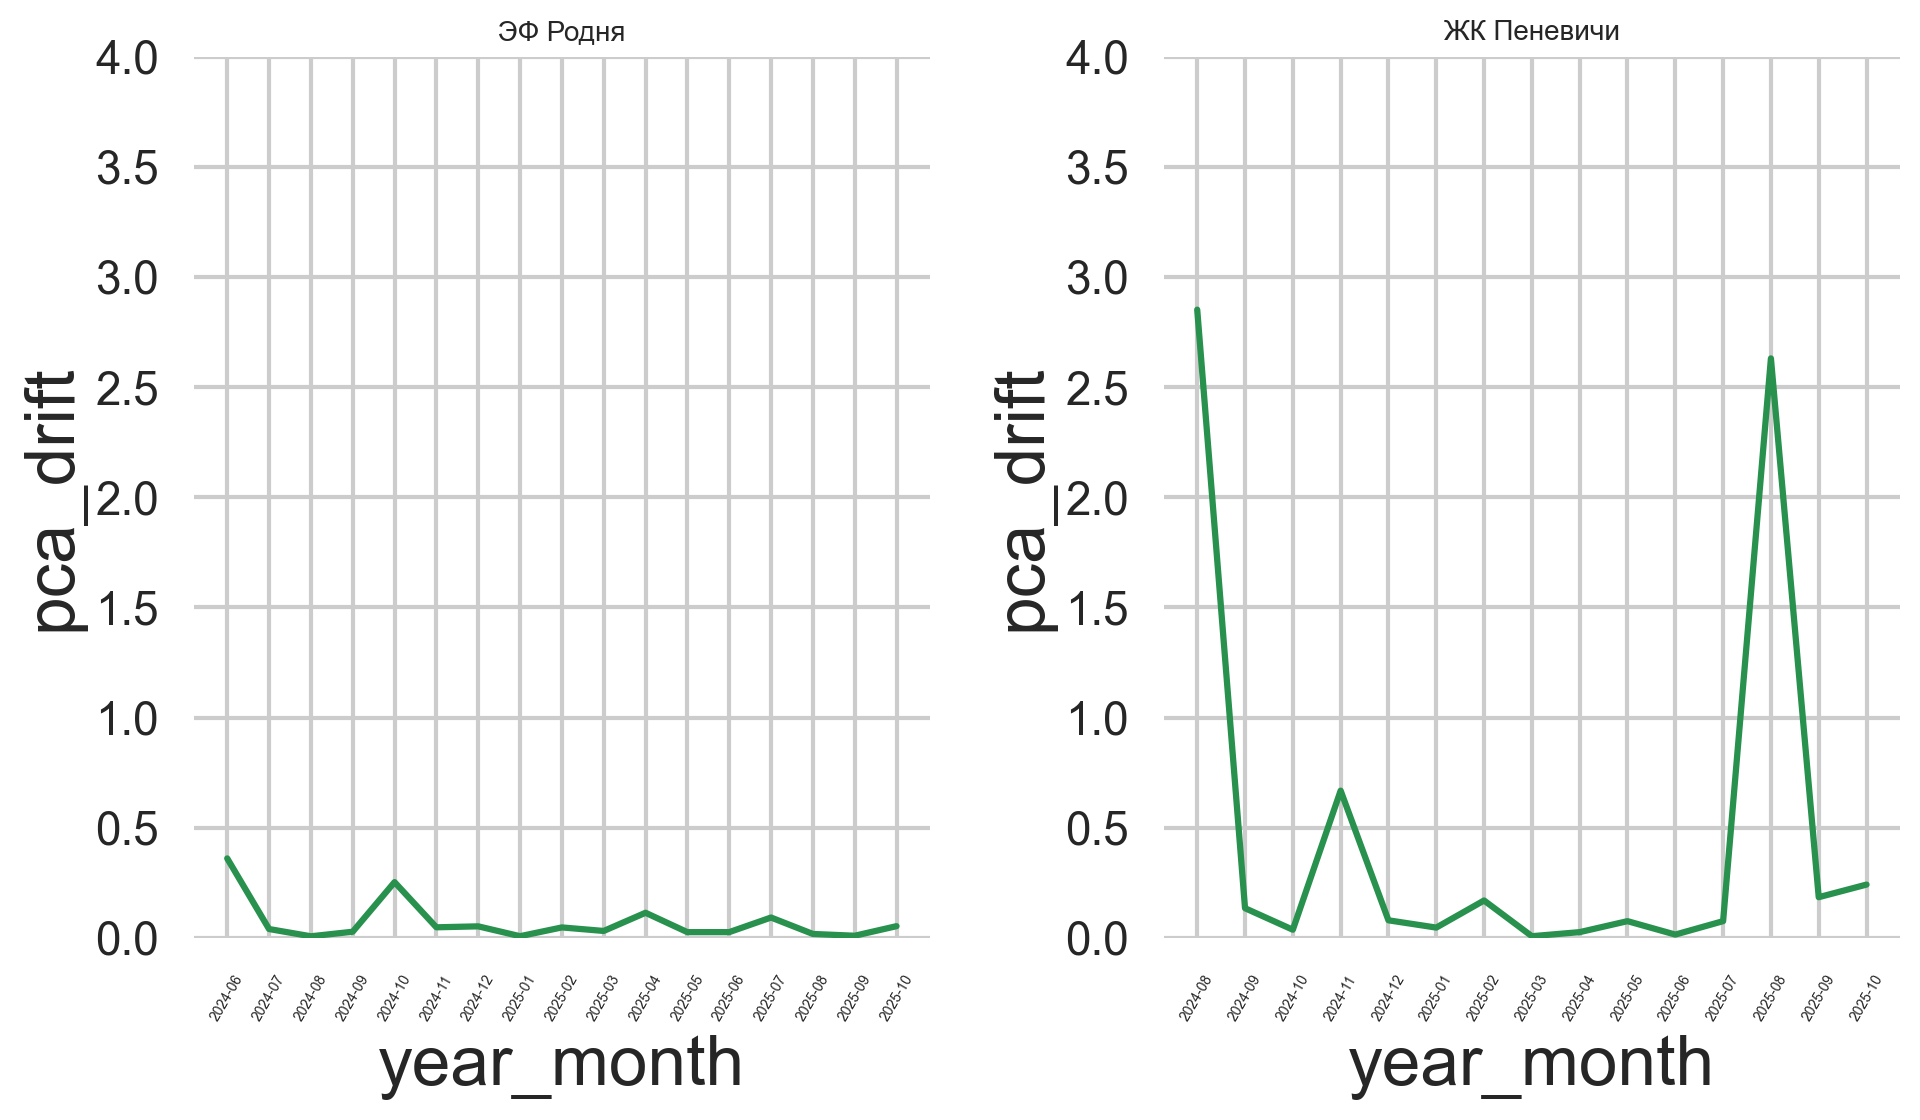

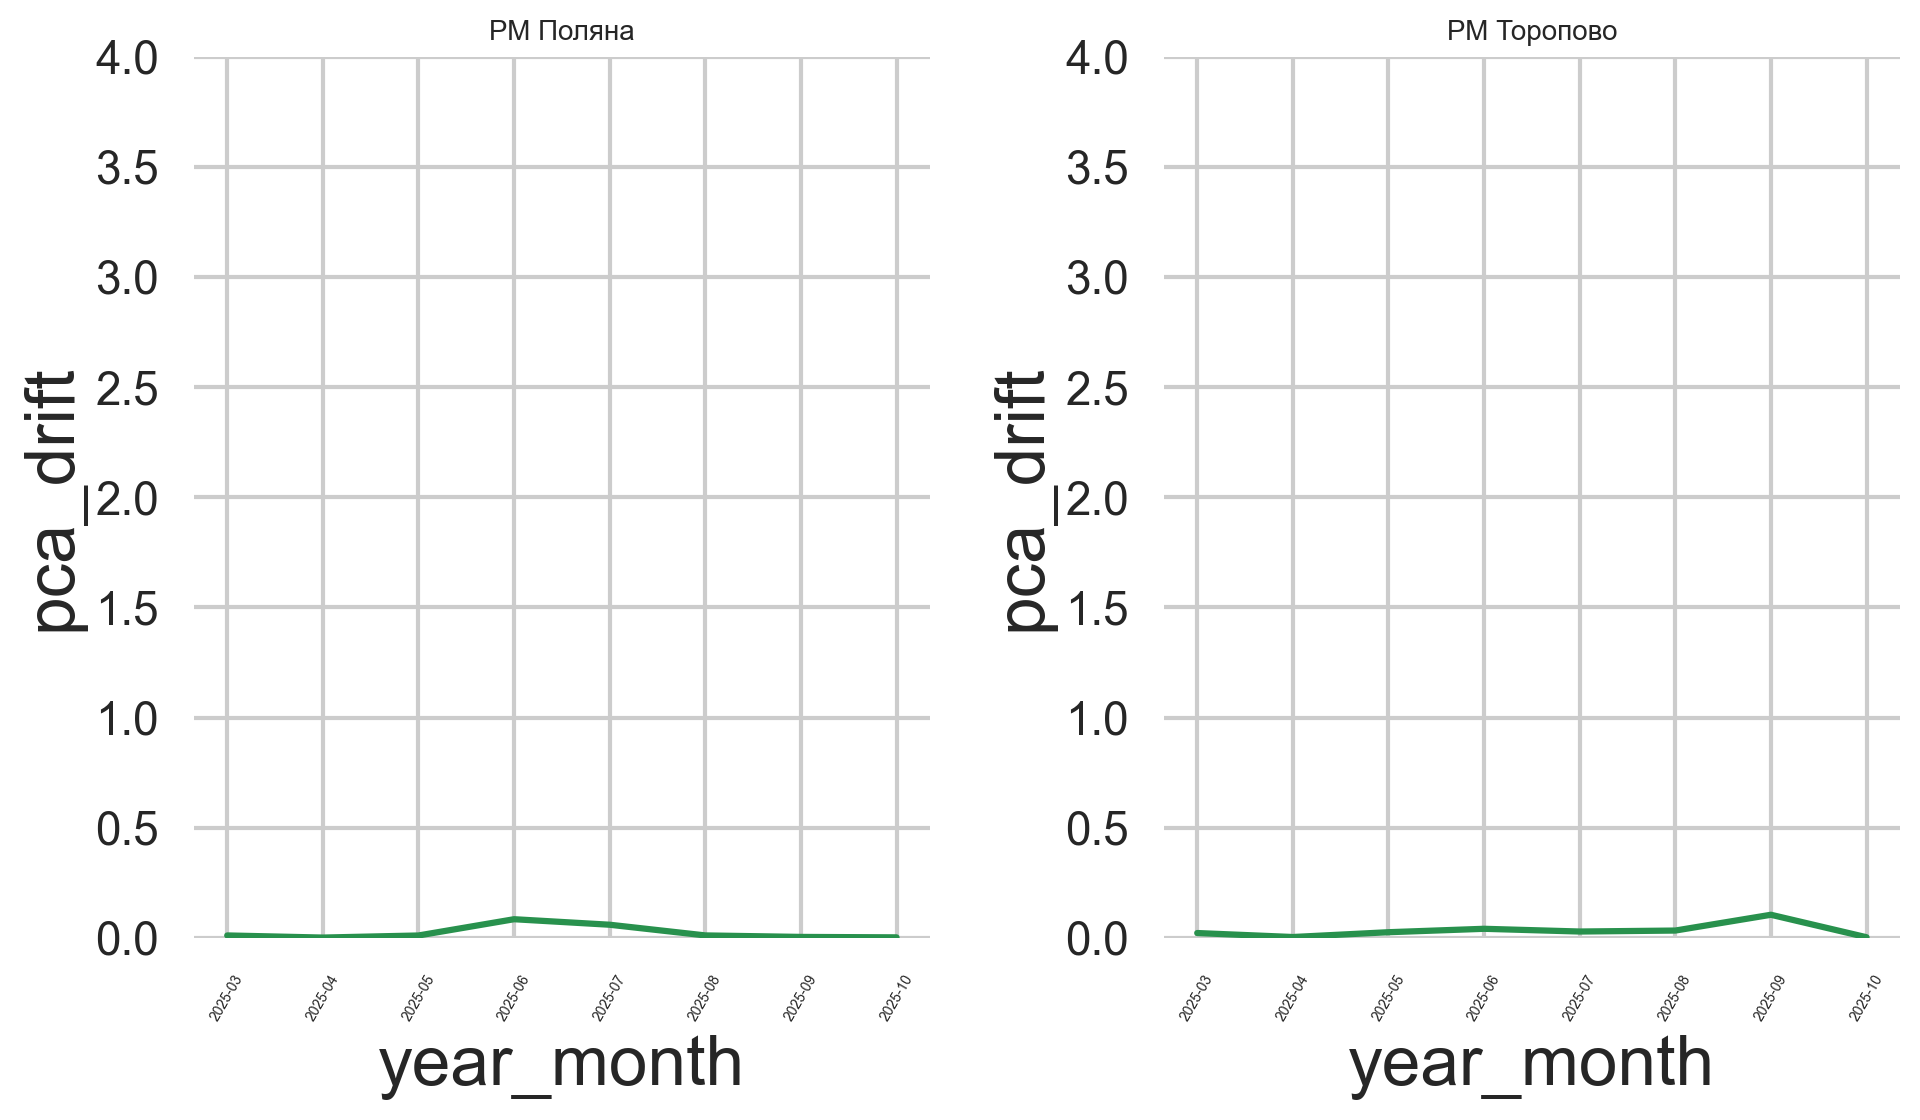

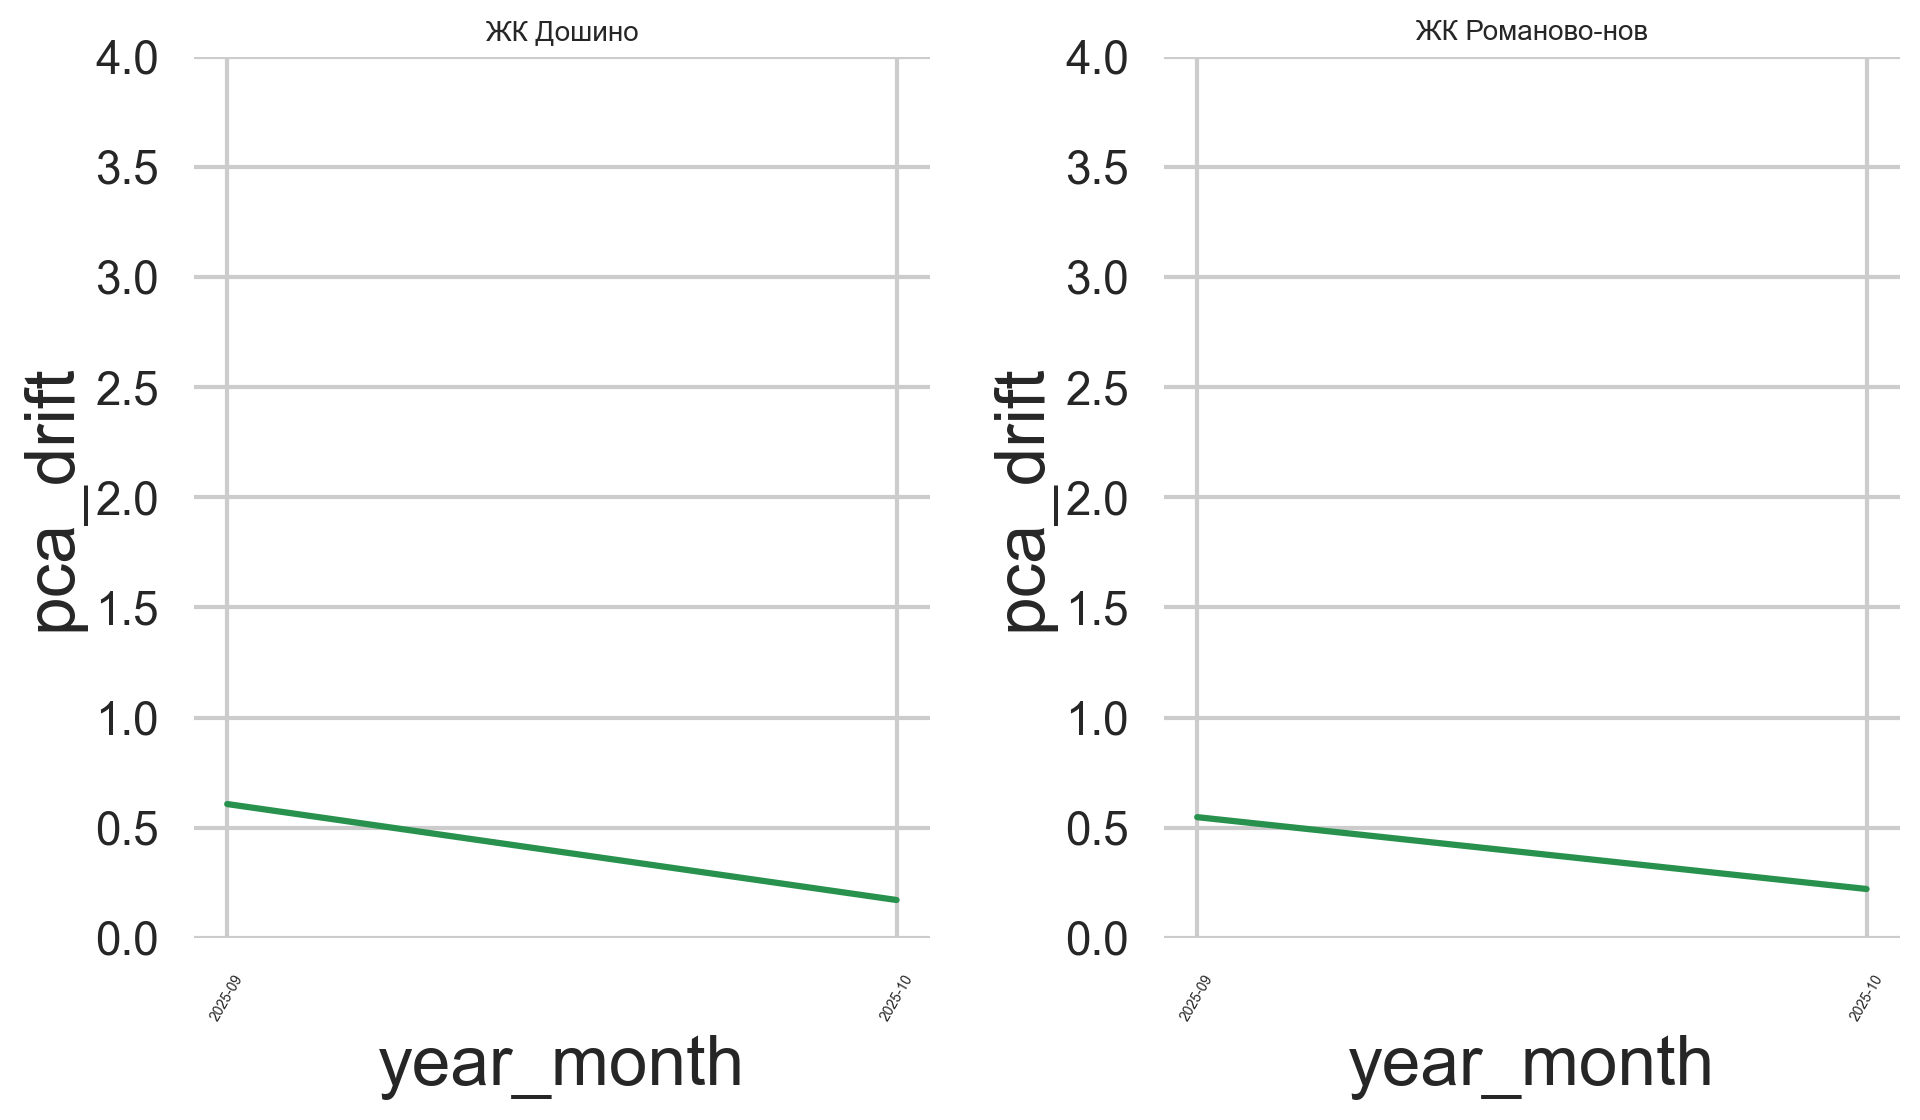

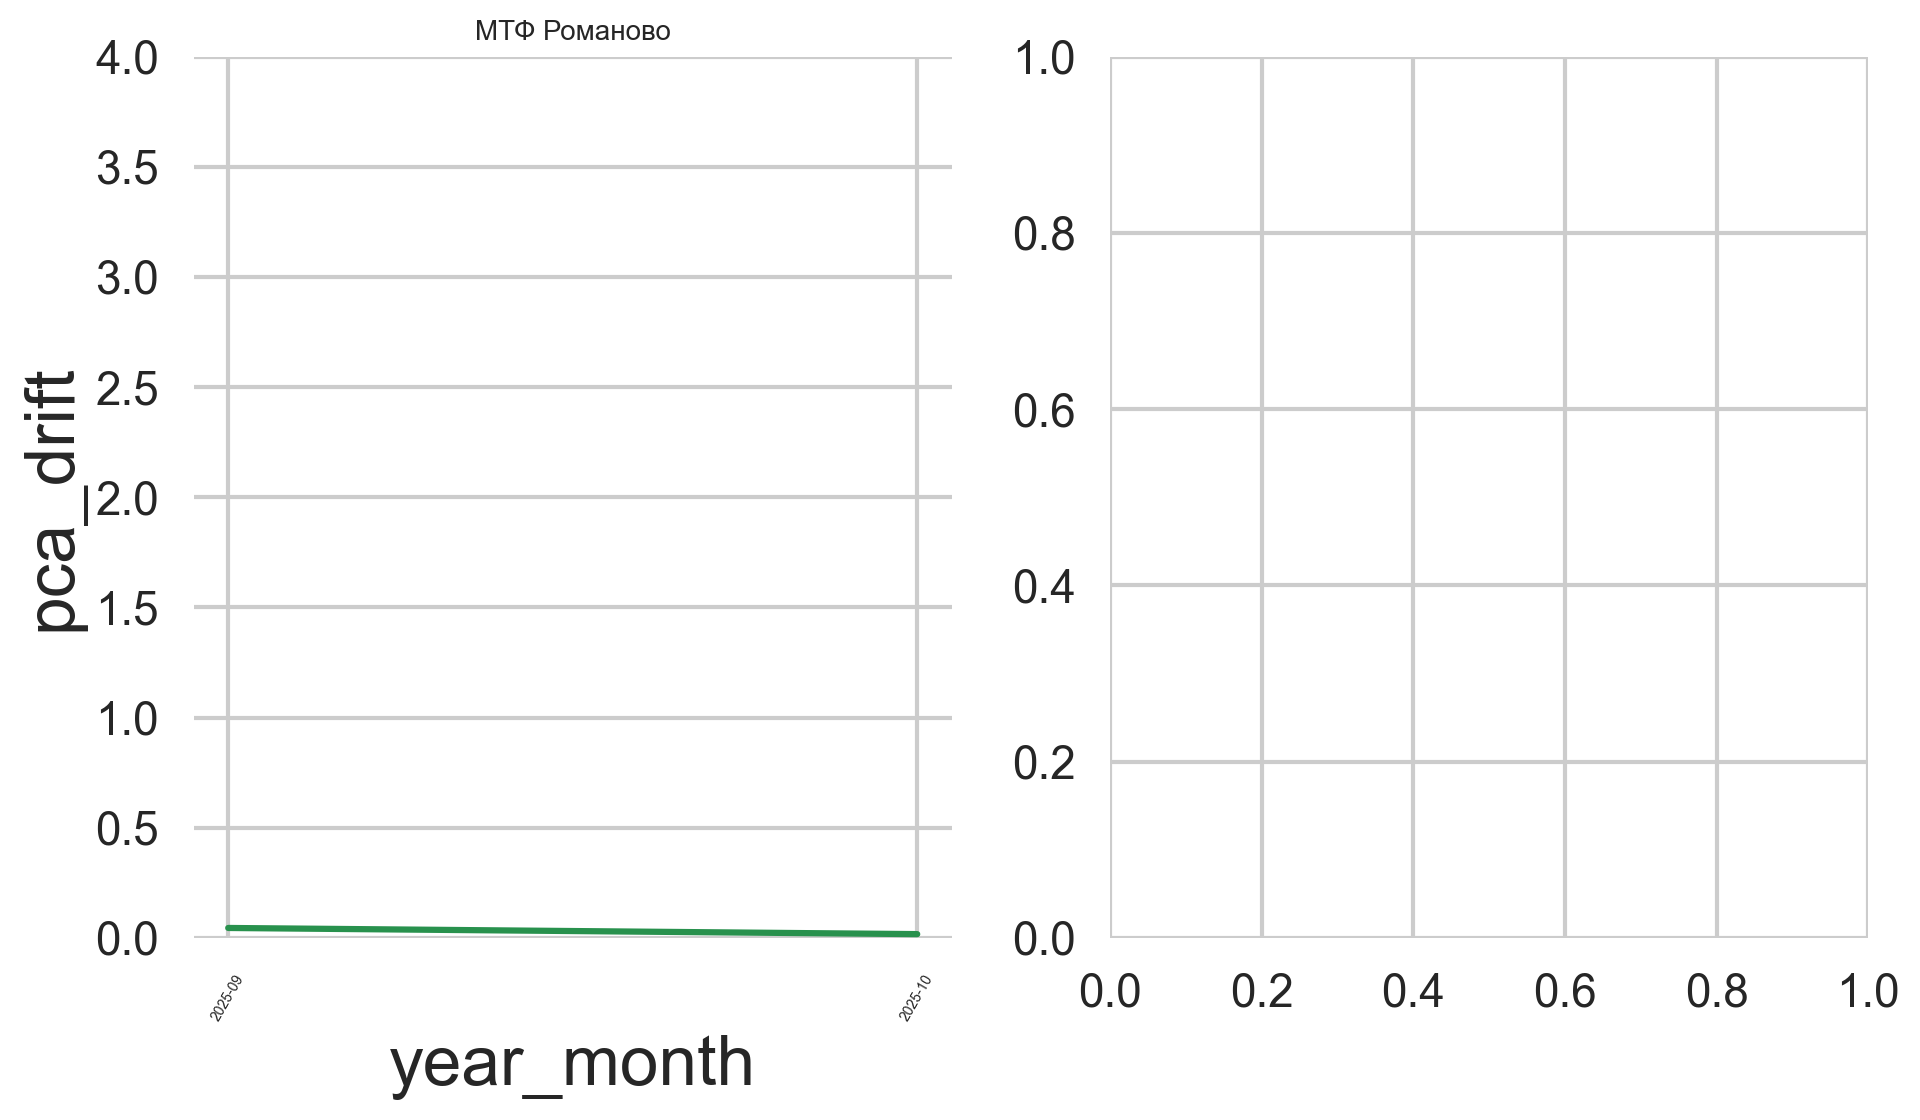

In [67]:
for i, farm in enumerate(monthly_vectors['FarmName'].unique()):
    if i % 2 == 0:
        fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
    sns.lineplot(data=monthly_vectors[monthly_vectors['FarmName'] == farm], x='year_month', y='pca_drift', ax=ax[i % 2])
    ax[i % 2].tick_params(axis='x', rotation=60, labelsize=5)
    ax[i % 2].set_ylim(0.0, 4.0)
    ax[i % 2].set_title(farm, fontsize=10)

In [68]:
s = monthly_vectors.groupby('FarmName')['pca_drift'].sum().reset_index().sort_values(by='pca_drift', ascending=False).reset_index()
s

index               FarmName  pca_drift
0      20           ЖК Колыбелка  74.078893
1      42               ЖК Щучье  65.285897
2      31          ЖК Петровское  62.877538
3      37        ЖК Старая Чигла  57.523894
4      18            ЖК Залужное  55.601786
5      30          ЖК Песковатка  48.029911
6       7             ЖК Борково  47.449004
7      27              ЖК Озерки  44.300775
8      38    ЖК Старое Резяпкино  44.104547
9      40             ЖК Уланово  41.535363
10     45        МТФ Каширинское  40.579271
11     14          ЖК Детчинское  36.990025
12      1            ЖК Аристово  36.158814
13     48            РМ Кольцово  35.404330
14     24             ЖК Наратлы  34.949379
15     15             ЖК Добрино  34.568771
16     22           ЖК Курочкино  33.071279
17     10      ЖК Верхний Икорец  32.834060
18     29            ЖК Пеньково  31.970168
19     39            ЖК Сугоново  30.390188
20     11          ЖК Волчанское  30.229554
21     21             ЖК Коршево  29.325212
22      5            ЖК Бодеевка  25.825578
23     23  ЖК Курская Васильевка  24.020232
24      4           ЖК Богданино  24.018025
25     19            ЖК Зимитицы  23.834852
26     32       ЖК Петропавловка  23.615797
27      2              ЖК Бобров  22.215858
28     12             ЖК Высокое  20.414267
29     47              МТФ Щучье  19.038347
30      0            ЖК Авангард  18.276197
31     33           ЖК Плеханово  17.384158
32      3            ЖК Бобров 2  17.083132
33     25           ЖК Нестерово  15.176001
34     17              ЖК Елбань  14.739502
35     13              ЖК Гусево  14.223005
36      8          ЖК Бортниково  13.790966
37      9             ЖК Бушовка  13.713839
38     34          ЖК Подболотье  12.891790
39      6          ЖК Болдасовка  12.582036
40     36     ЖК Семено-Макарово  10.039579
41     28            ЖК Пеневичи   7.252570
42     26       ЖК Огнева Заимка   7.142801
43     43            МТФ Высокое   6.720894
44     41                ЖК Шацк   5.360126
45     49            РМ Пеньково   3.116291
46     52               ЭФ Родня   1.224492
47     44             МТФ Гилево   0.943354
48     16              ЖК Дошино   0.780439
49     35        ЖК Романово-нов   0.770851
50     51            РМ Торопово   0.267021
51     50              РМ Поляна   0.189930
52     46           МТФ Романово   0.063138

In [69]:
monthly_vectors

ingredient_group year_month           FarmName  byproducts  \
0                   2022-01         ЖК Добрино    0.000000   
1                   2022-01         ЖК Коршево    0.000000   
2                   2022-02        ЖК Бодеевка    0.000000   
3                   2022-02  ЖК Верхний Икорец    0.000000   
4                   2022-02         ЖК Высокое    0.000000   
...                     ...                ...         ...   
1725                2025-10        РМ Кольцово    0.721447   
1726                2025-10        РМ Пеньково    1.233179   
1727                2025-10          РМ Поляна    0.849197   
1728                2025-10        РМ Торопово    0.917100   
1729                2025-10           ЭФ Родня    0.000000   

ingredient_group  compound_feed_calf_replacements  energy_source  fat_oils  \
0                                        2.443405       3.042668  0.100609   
1                                        2.843560       3.475203  0.130497   
2                                        2.551410       3.797562  0.083673   
3                                        1.625360       2.822767  0.061960   
4                                        2.690139       6.061484  0.129629   
...                                           ...            ...       ...   
1725                                     1.853074       0.768064  0.000000   
1726                                     1.910801       0.365862  0.000000   
1727                                     2.383007       0.861422  0.000000   
1728                                     0.000000       0.753350  0.000000   
1729                                     0.000000       0.000000  0.000000   

ingredient_group  feed_additives_probiotics  forage_bulk  medications  \
0                                  0.063965    20.326100     0.031507   
1                                  0.315463    19.497481     0.000000   
2                                  0.377359    17.150380     0.026529   
3                                  0.000000    16.432382     0.000000   
4                                  0.255193    23.464573     0.097194   
...                                     ...          ...          ...   
1725                               0.001683    14.749873     0.050412   
1726                               0.000000    10.944699     0.037800   
1727                               0.000000    12.680457     0.000000   
1728                               0.000000    22.153482     0.000000   
1729                               0.000000    37.020642     0.131322   

ingredient_group  minerals_buffers  premix_feed  protein_source  \
0                         0.051698     0.167850        2.909530   
1                         0.040794     0.132580        3.603738   
2                         0.155312     0.165690        2.840411   
3                         0.056563     0.169696        2.231988   
4                         0.231954     0.185723        4.655053   
...                            ...          ...             ...   
1725                      0.009356     0.196007        1.261460   
1726                      0.000000     0.171092        0.877475   
1727                      0.000000     0.175702        1.198894   
1728                      0.000000     0.205090        1.320500   
1729                      0.224968     0.000000        2.727945   

ingredient_group  wet_ingredients_water  yeast_products  \
0                              2.693400        0.832498   
1                              8.302740        0.000000   
2                              4.121511        1.128109   
3                              4.245658        0.000000   
4                              8.780972        0.000000   
...                                 ...             ...   
1725                           4.693253        0.000000   
1726                           6.376418        0.000000   
1727                           0.000000        0.000000   
1728                           0.000000       

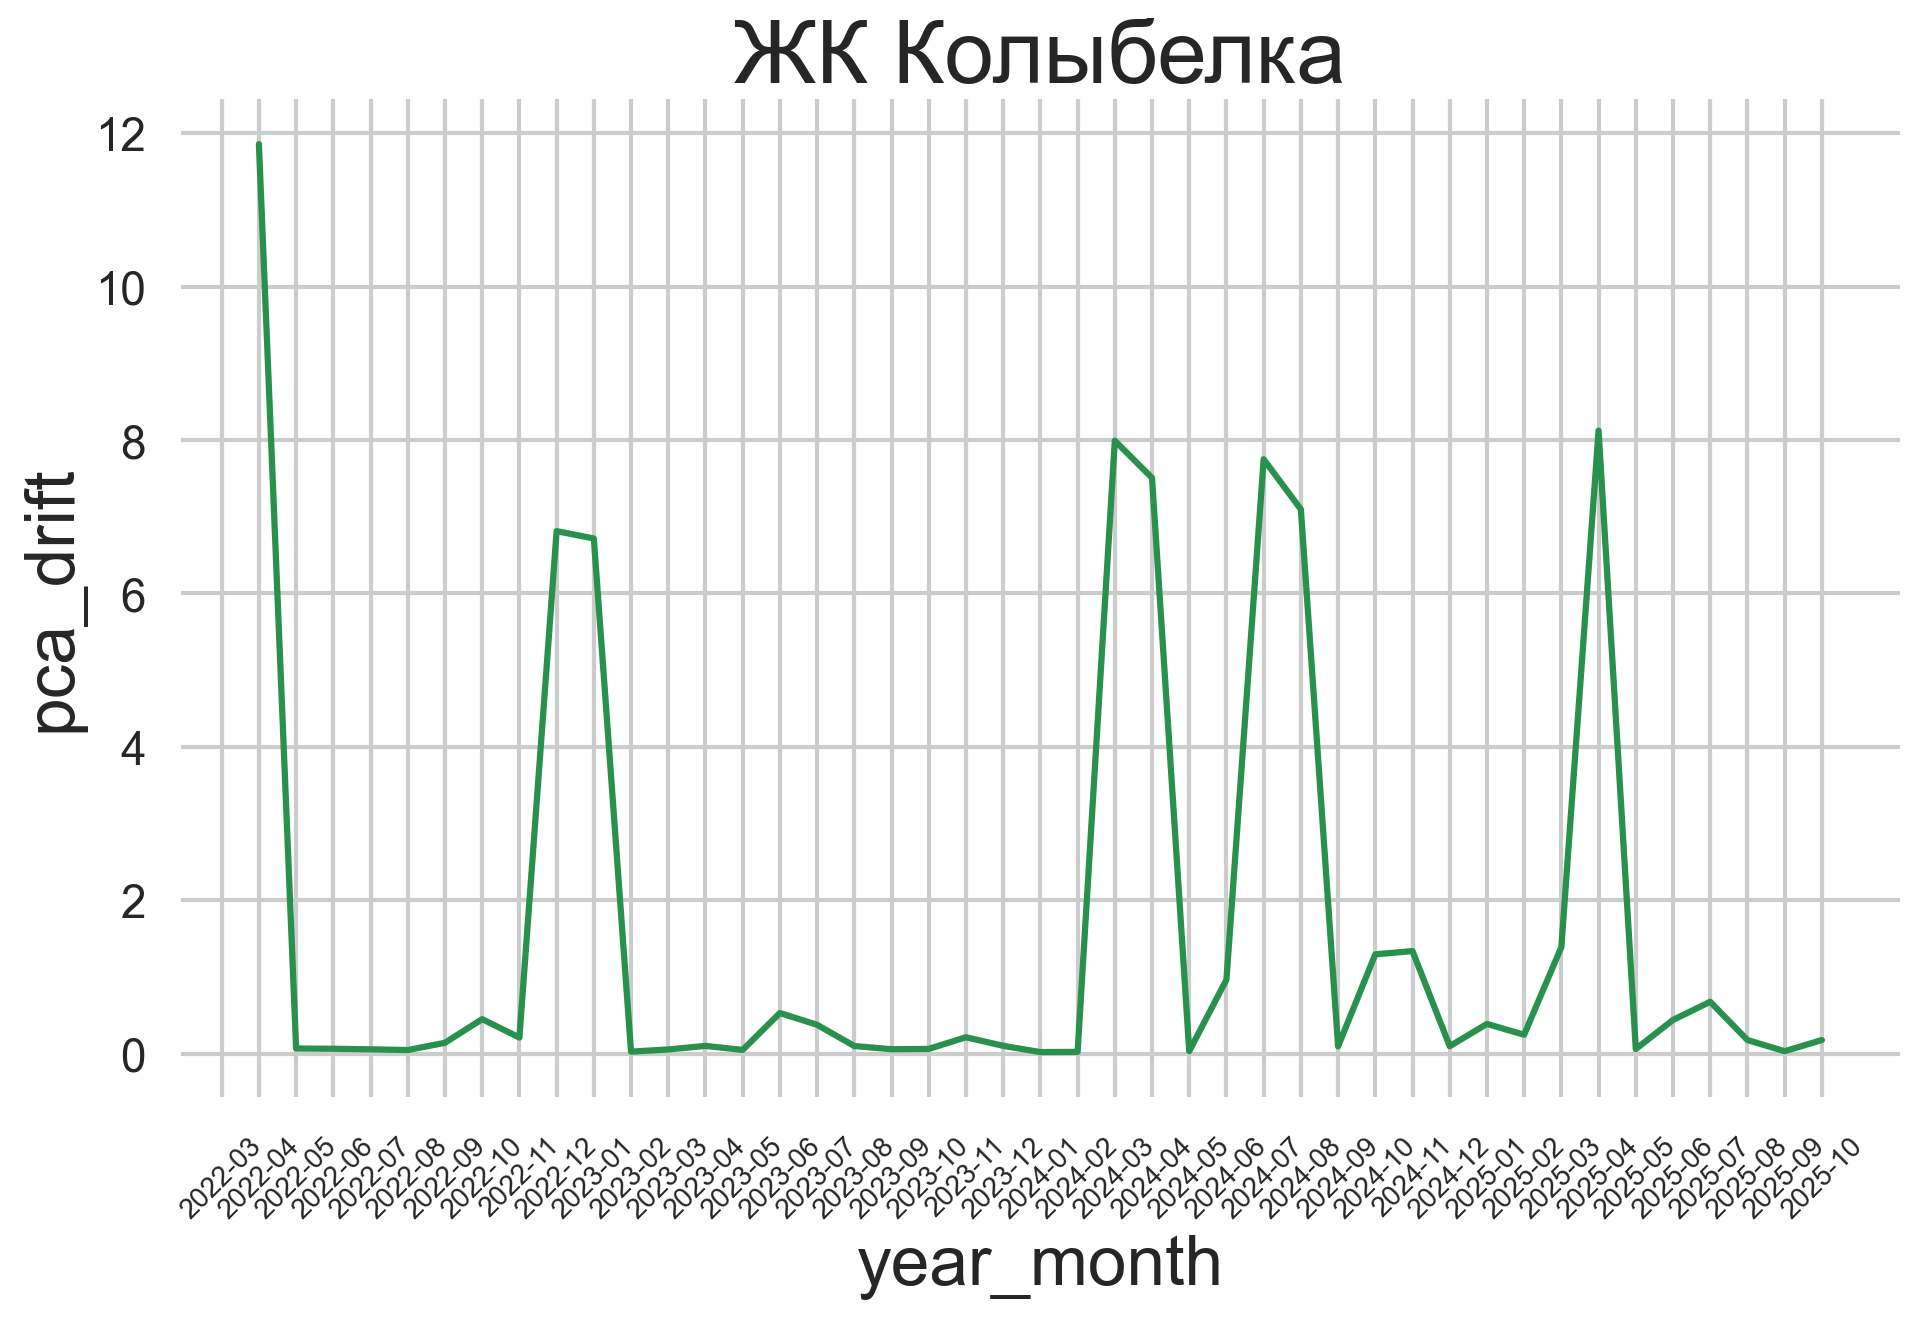

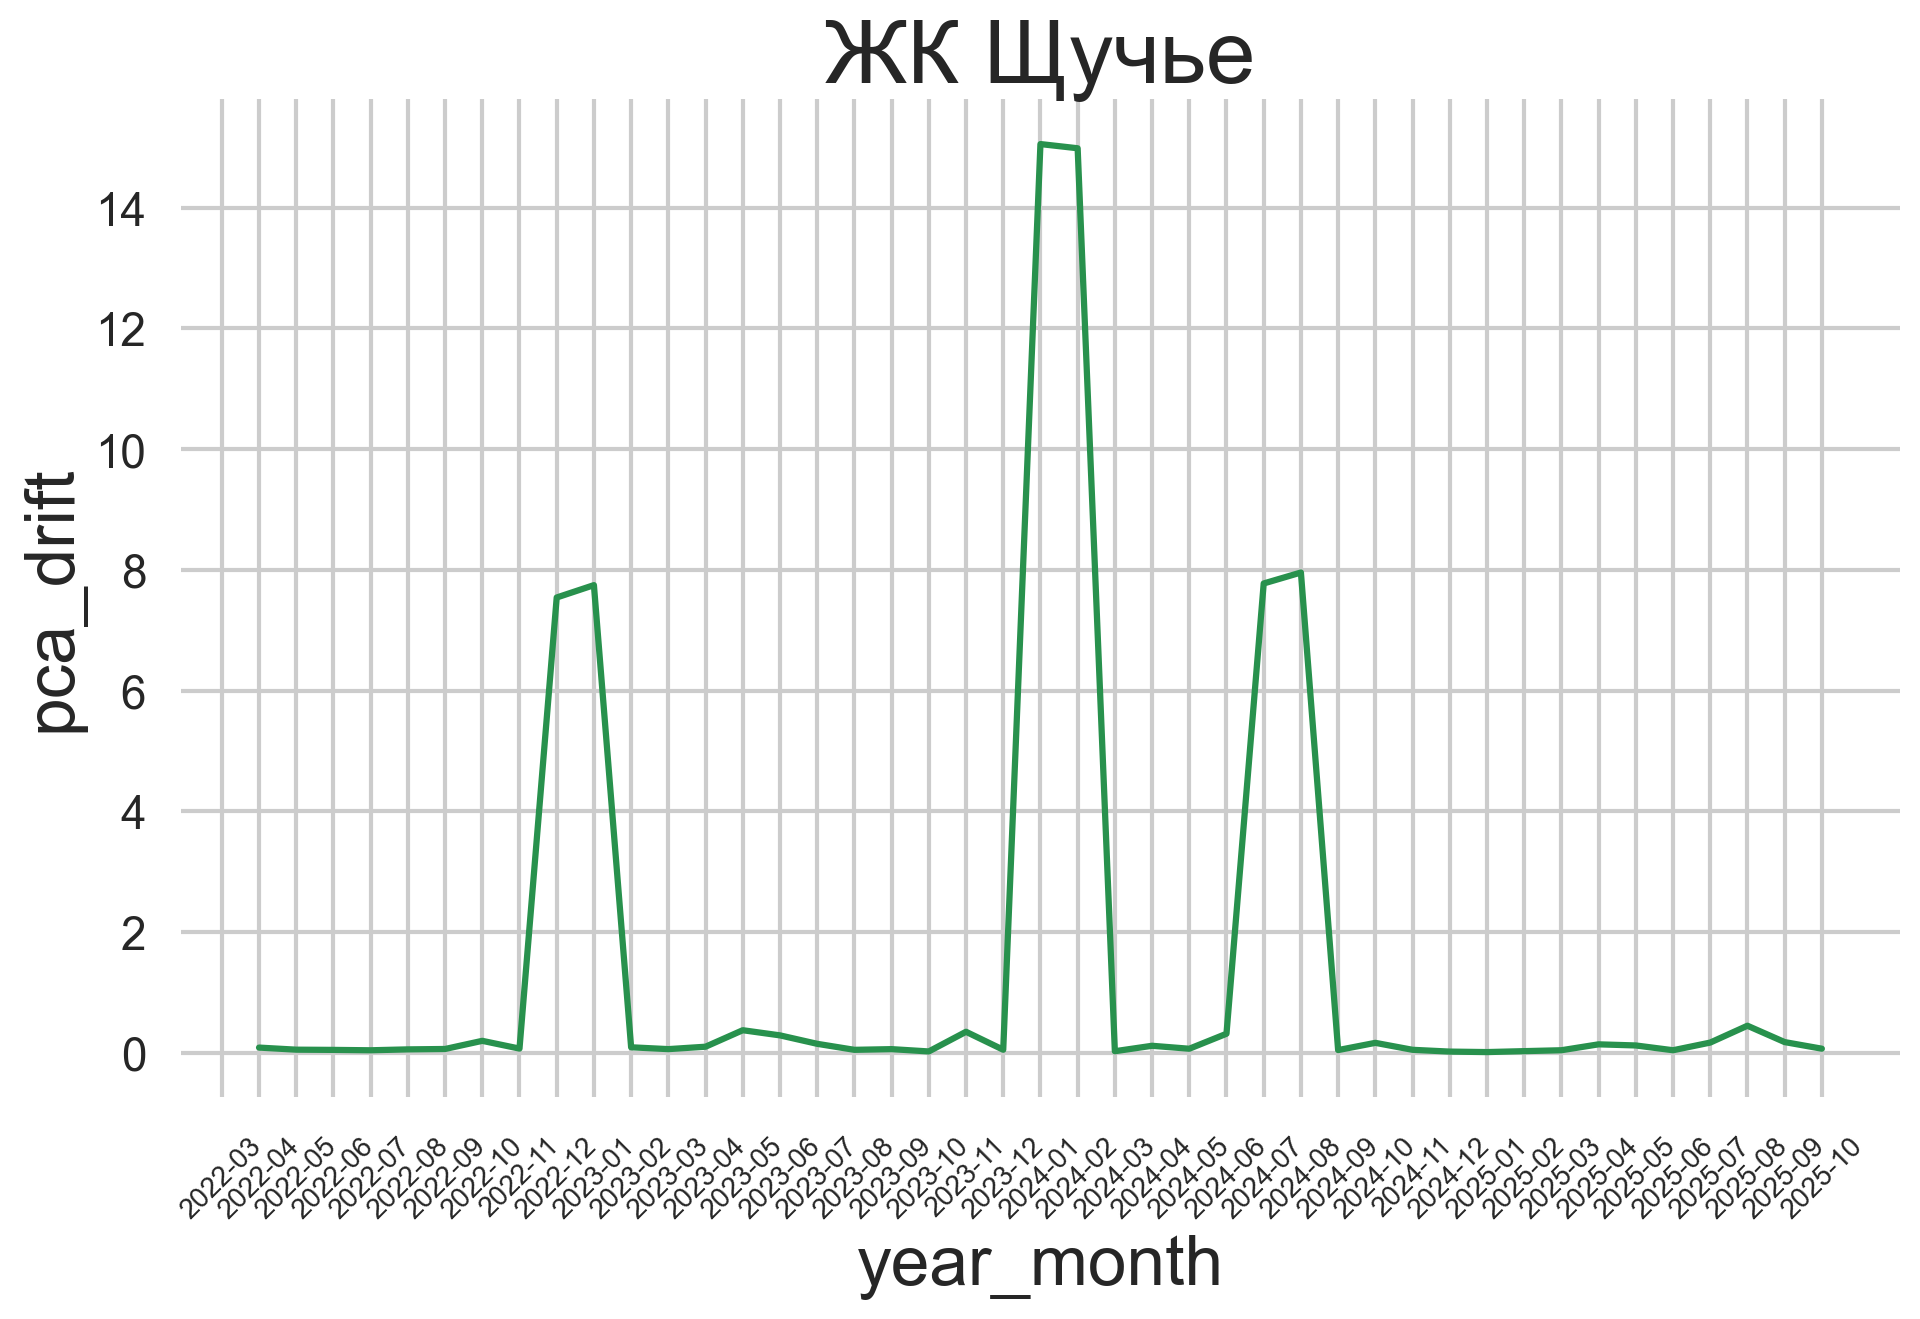

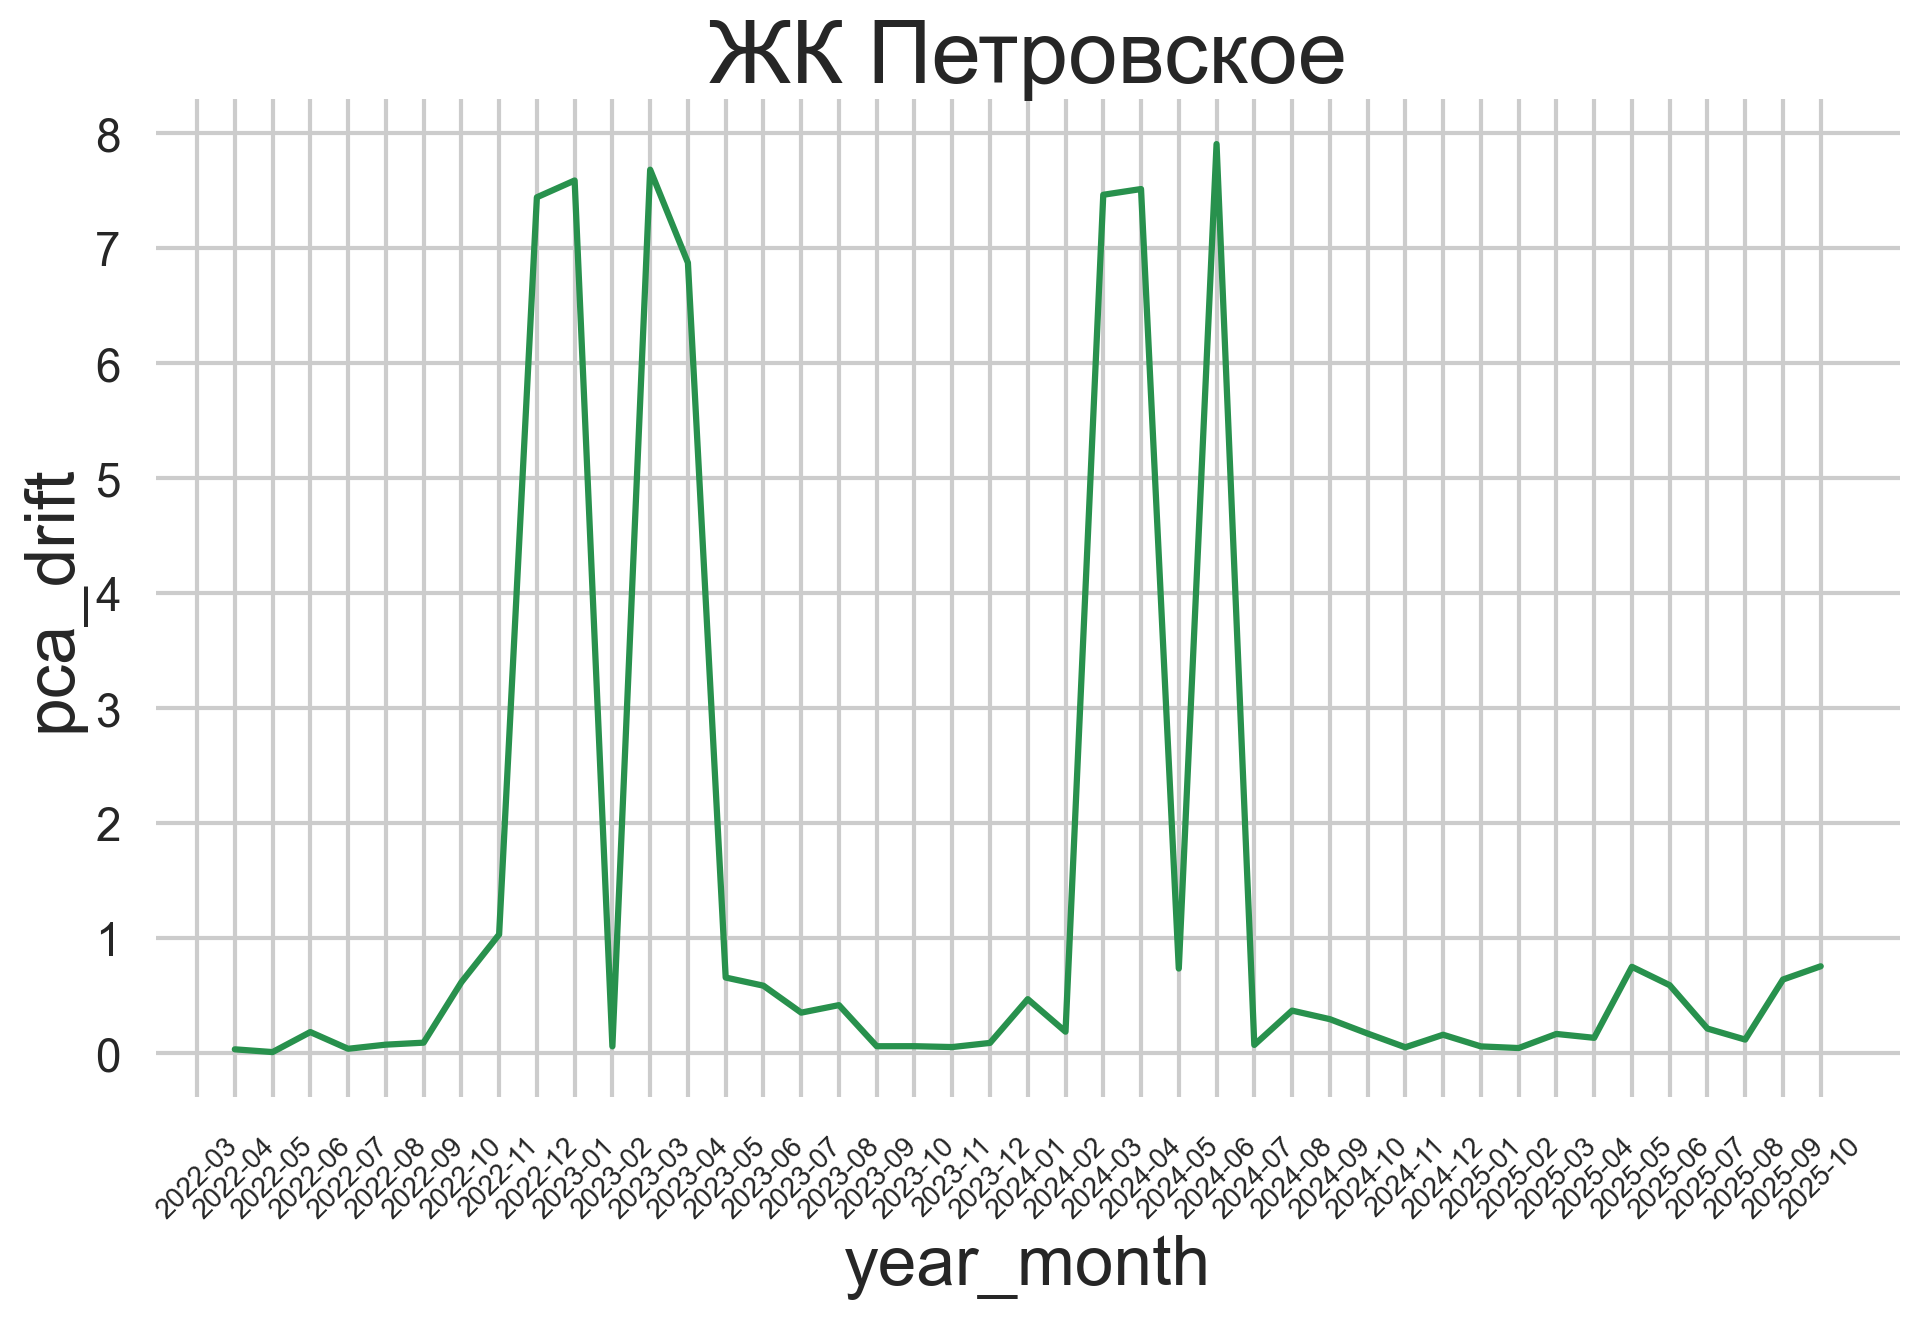

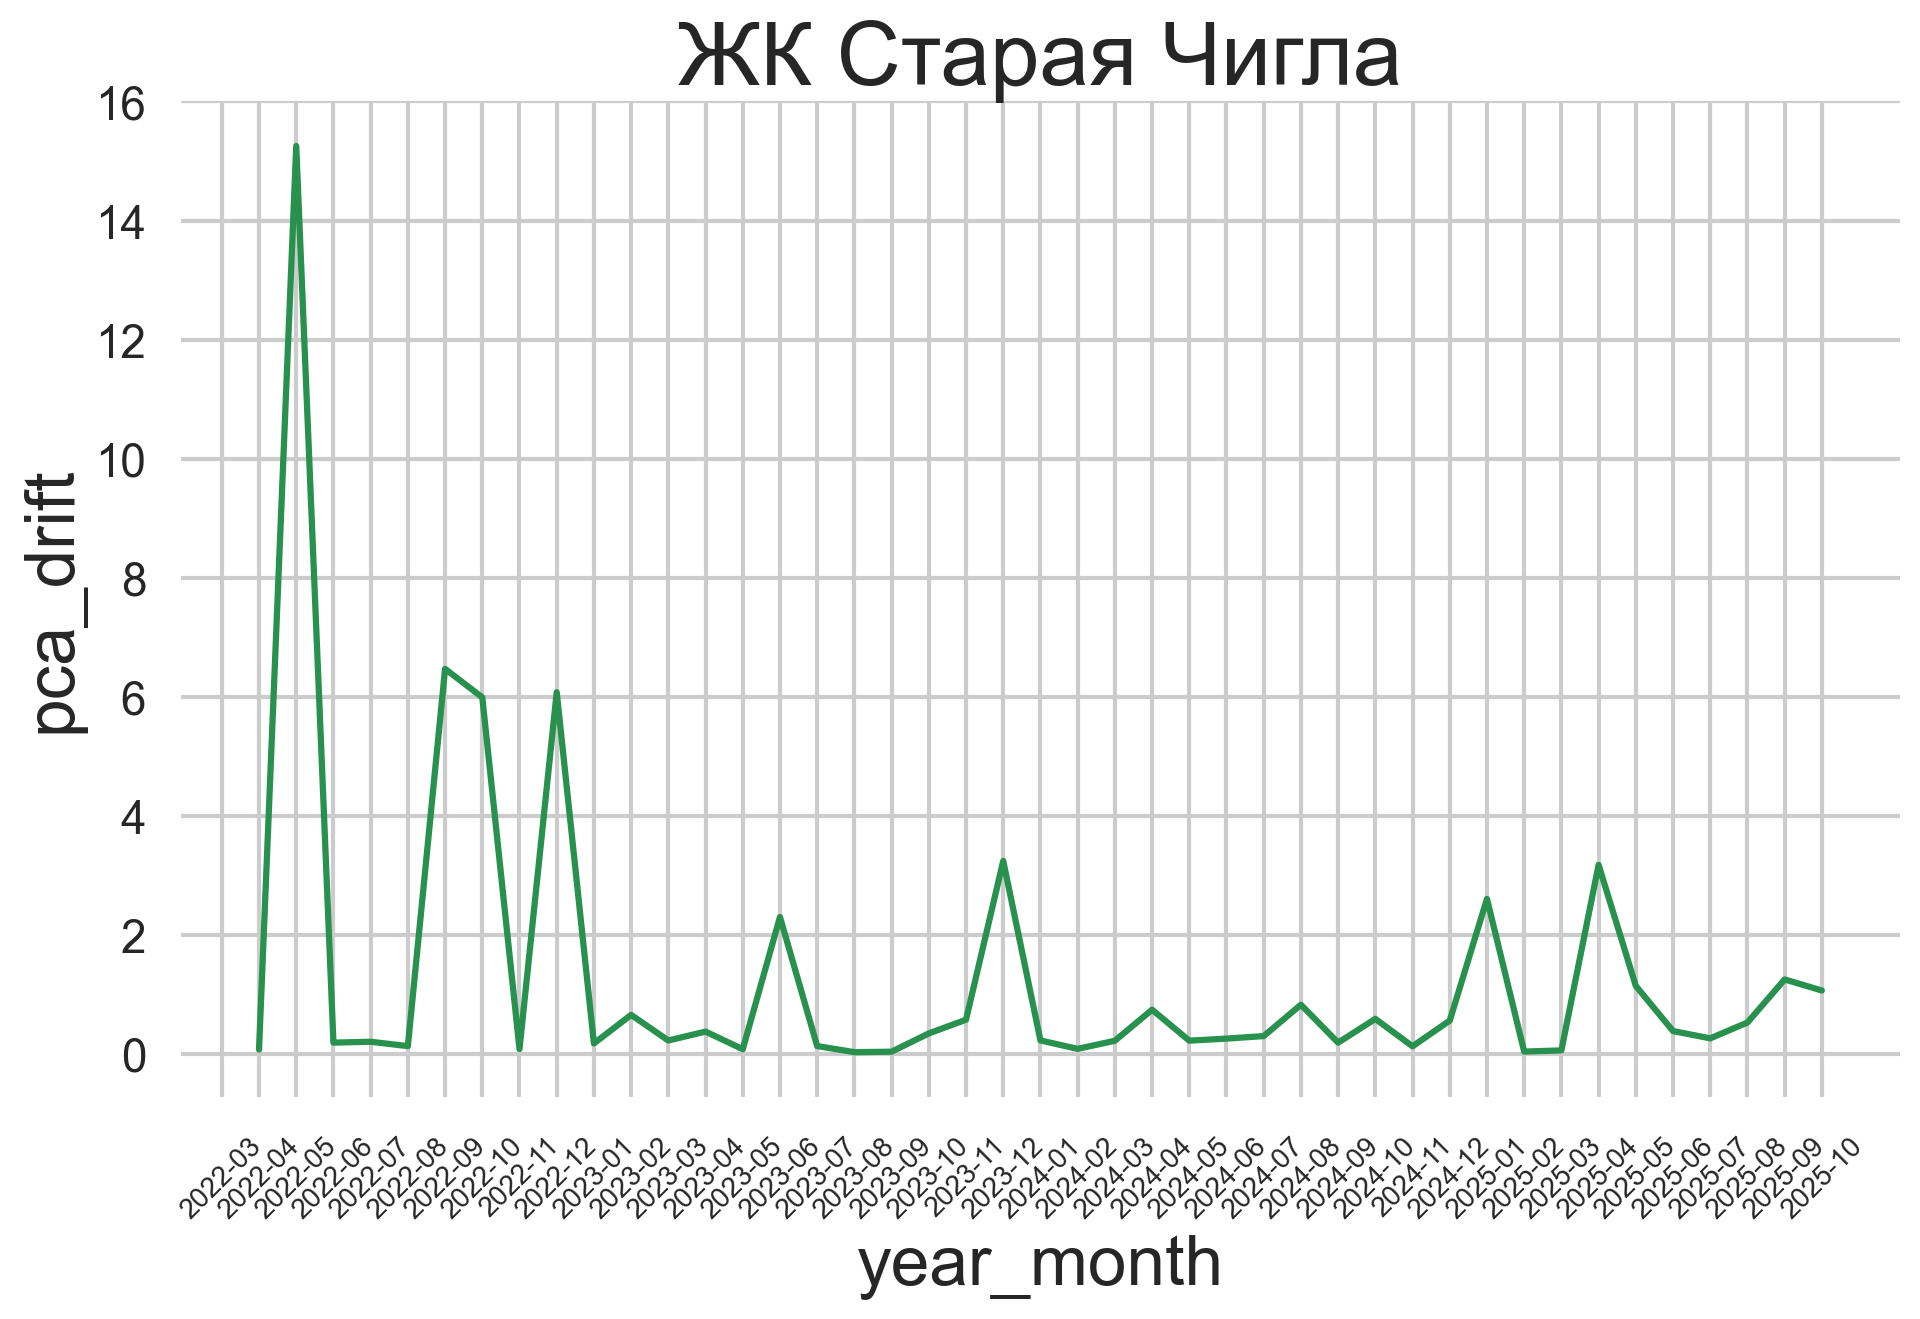

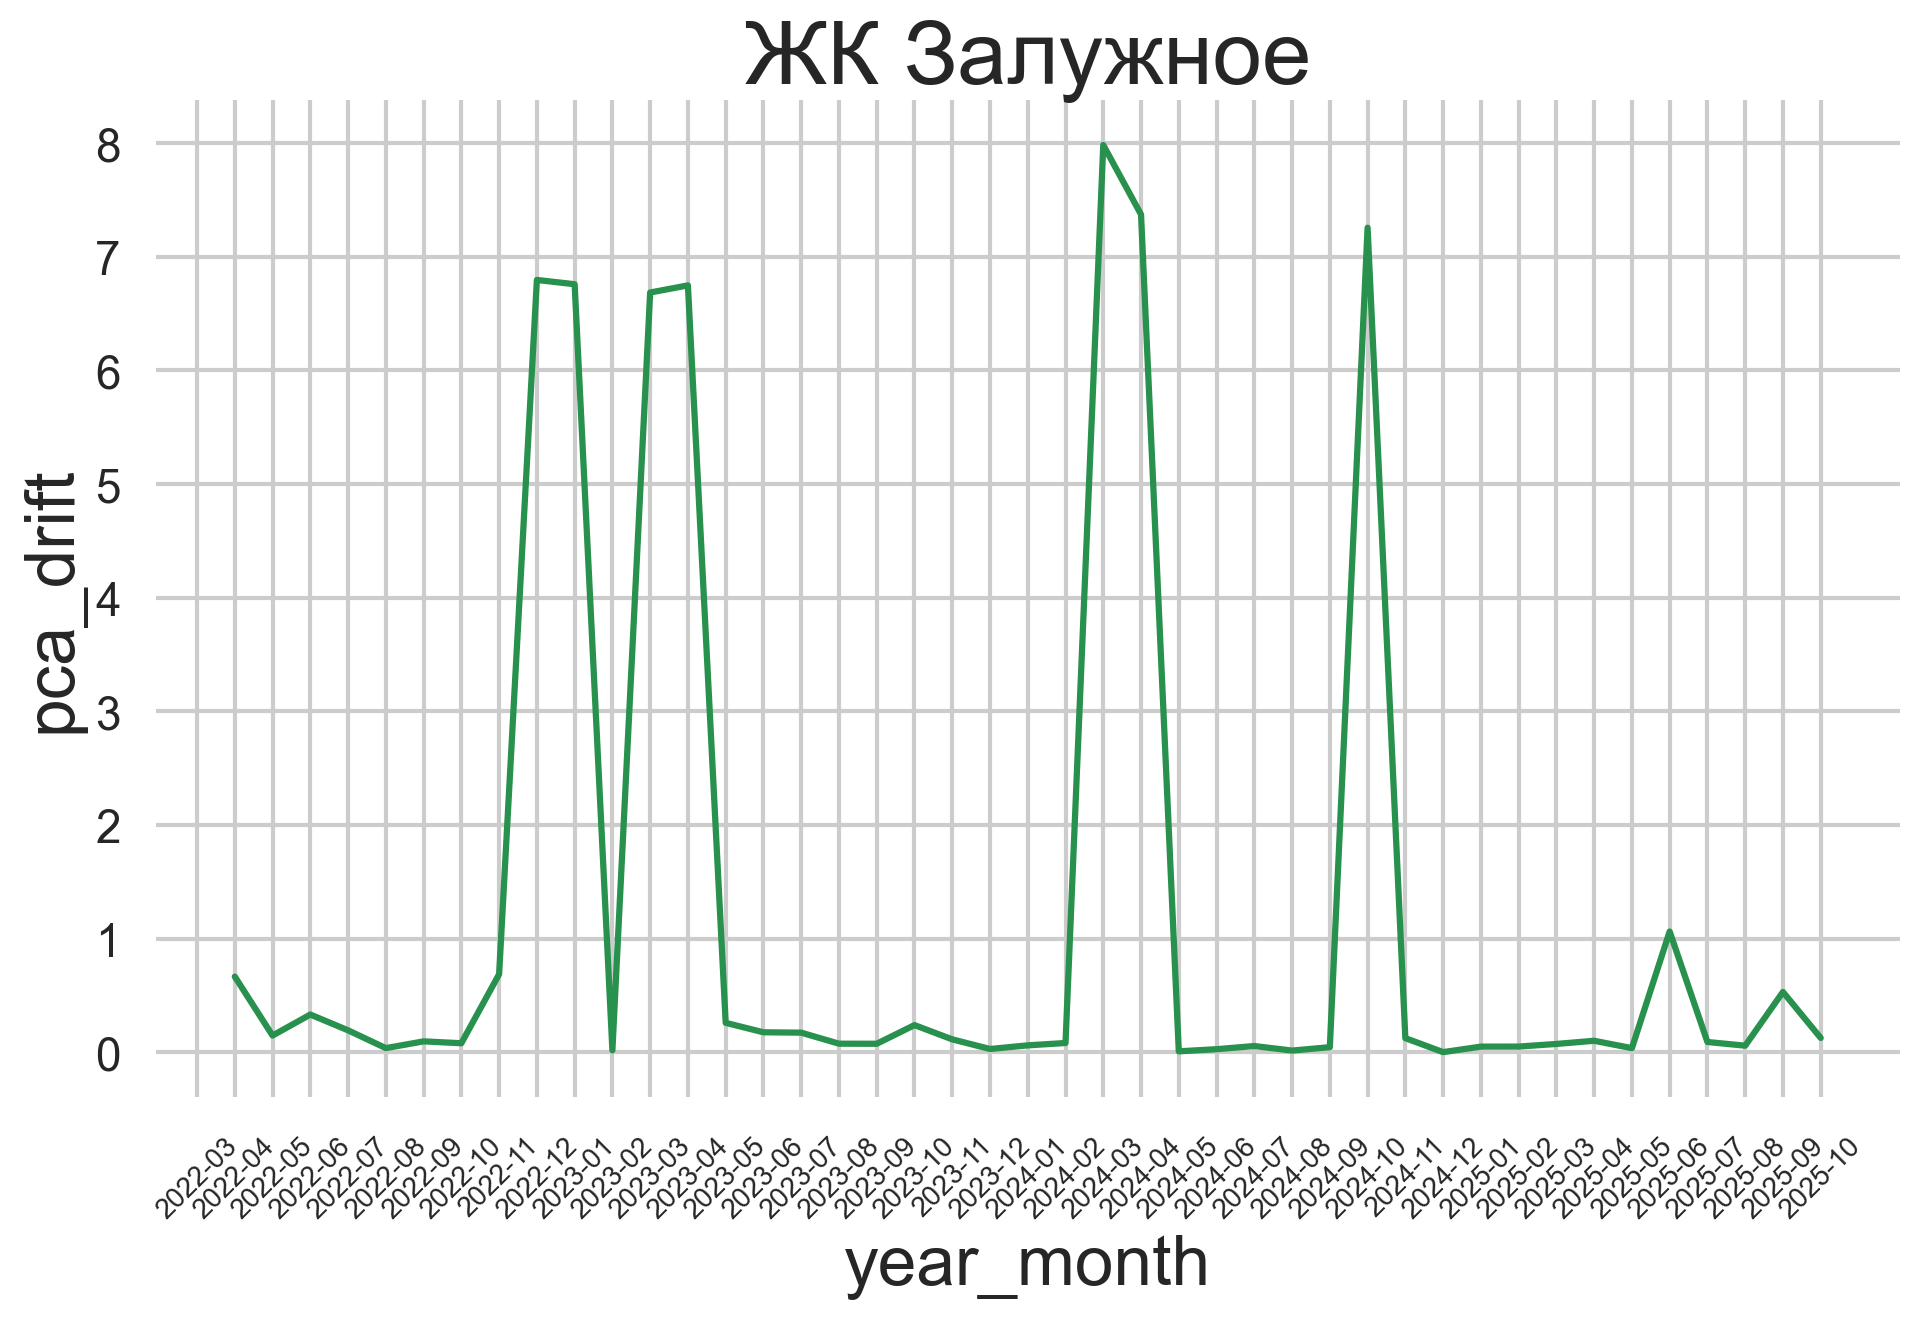

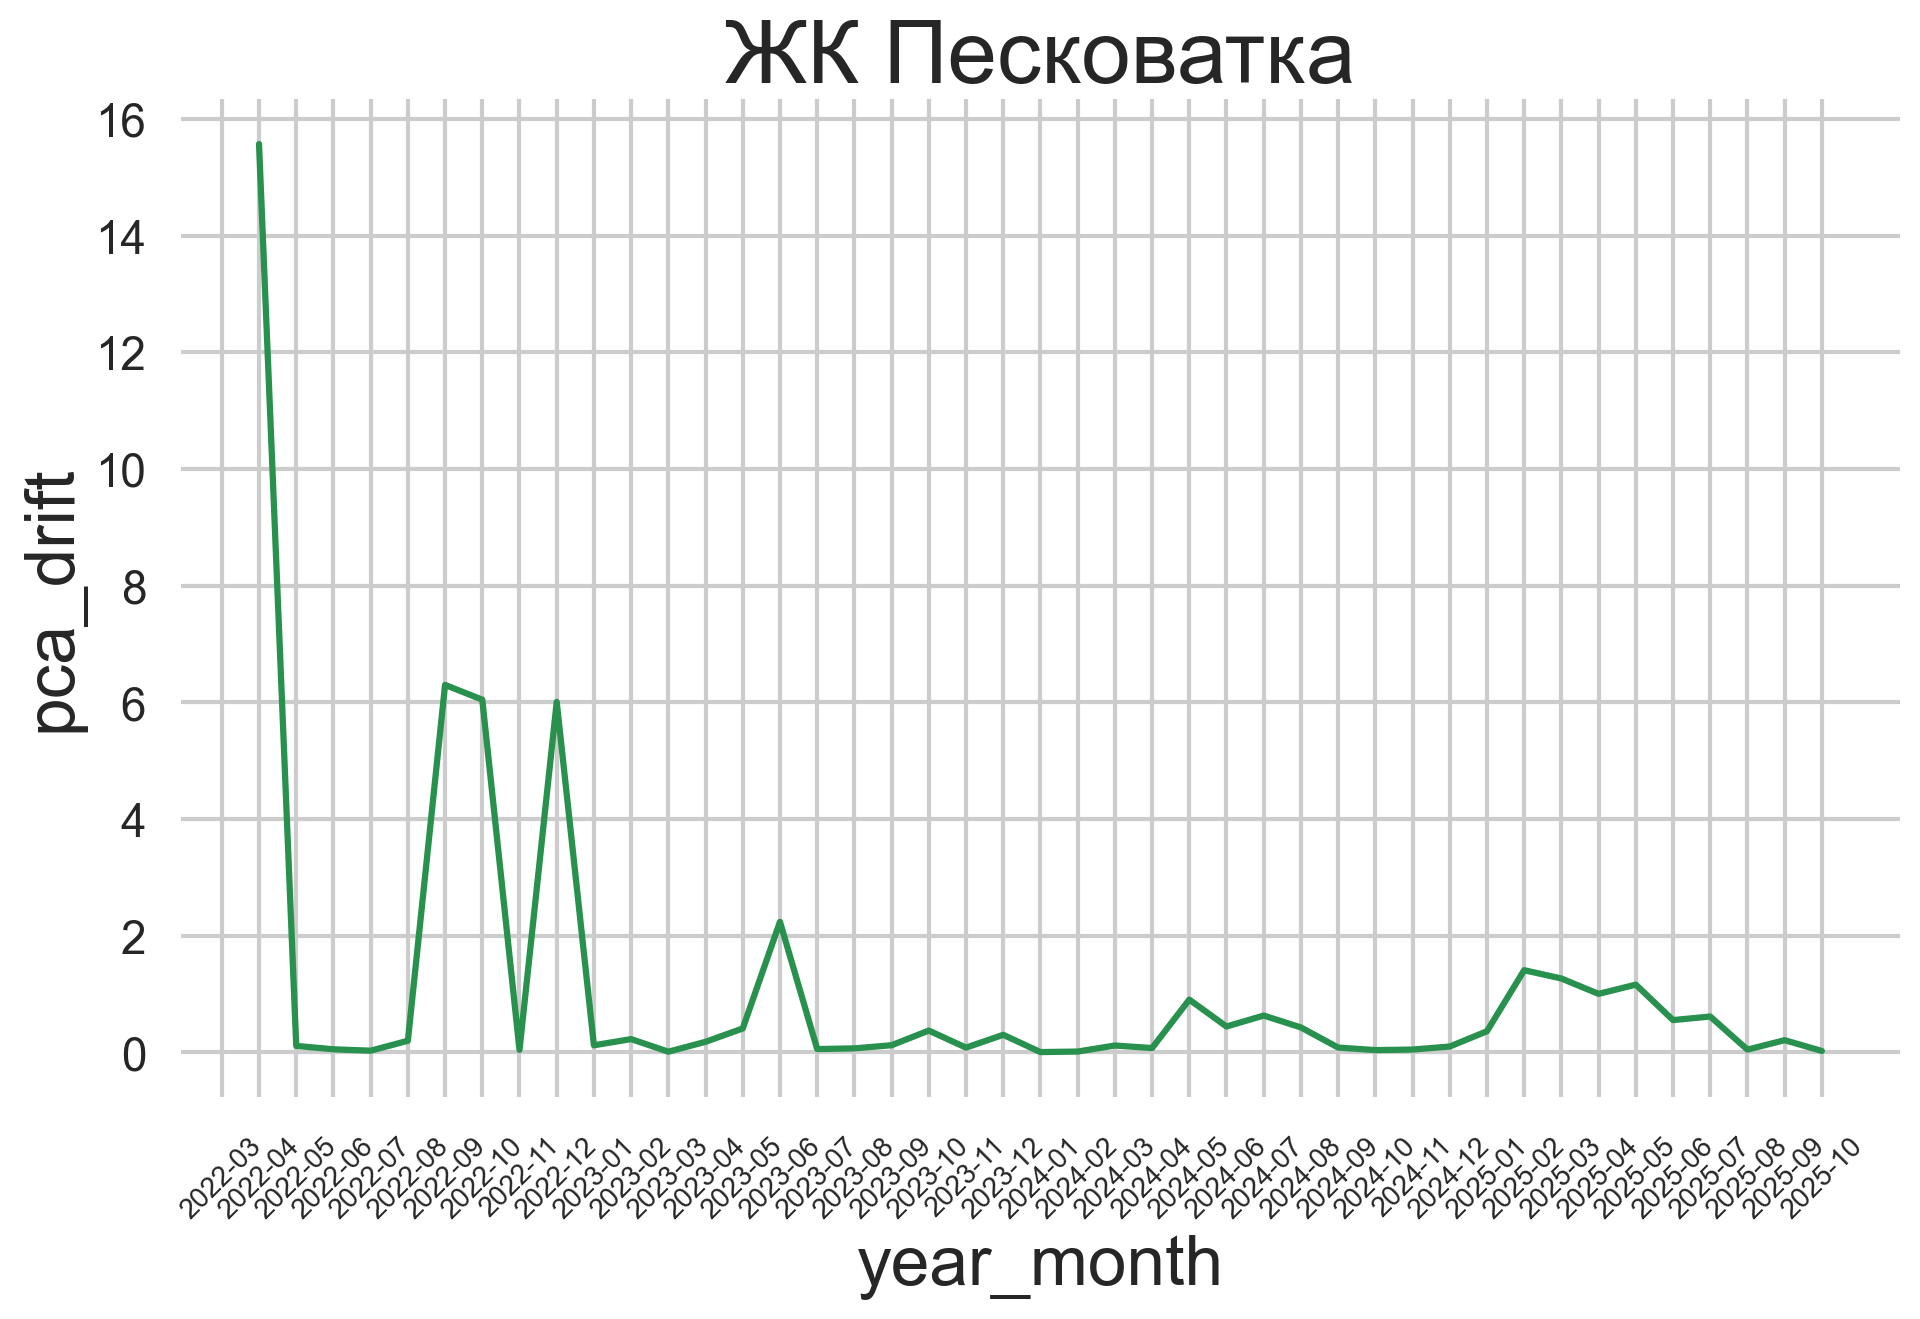

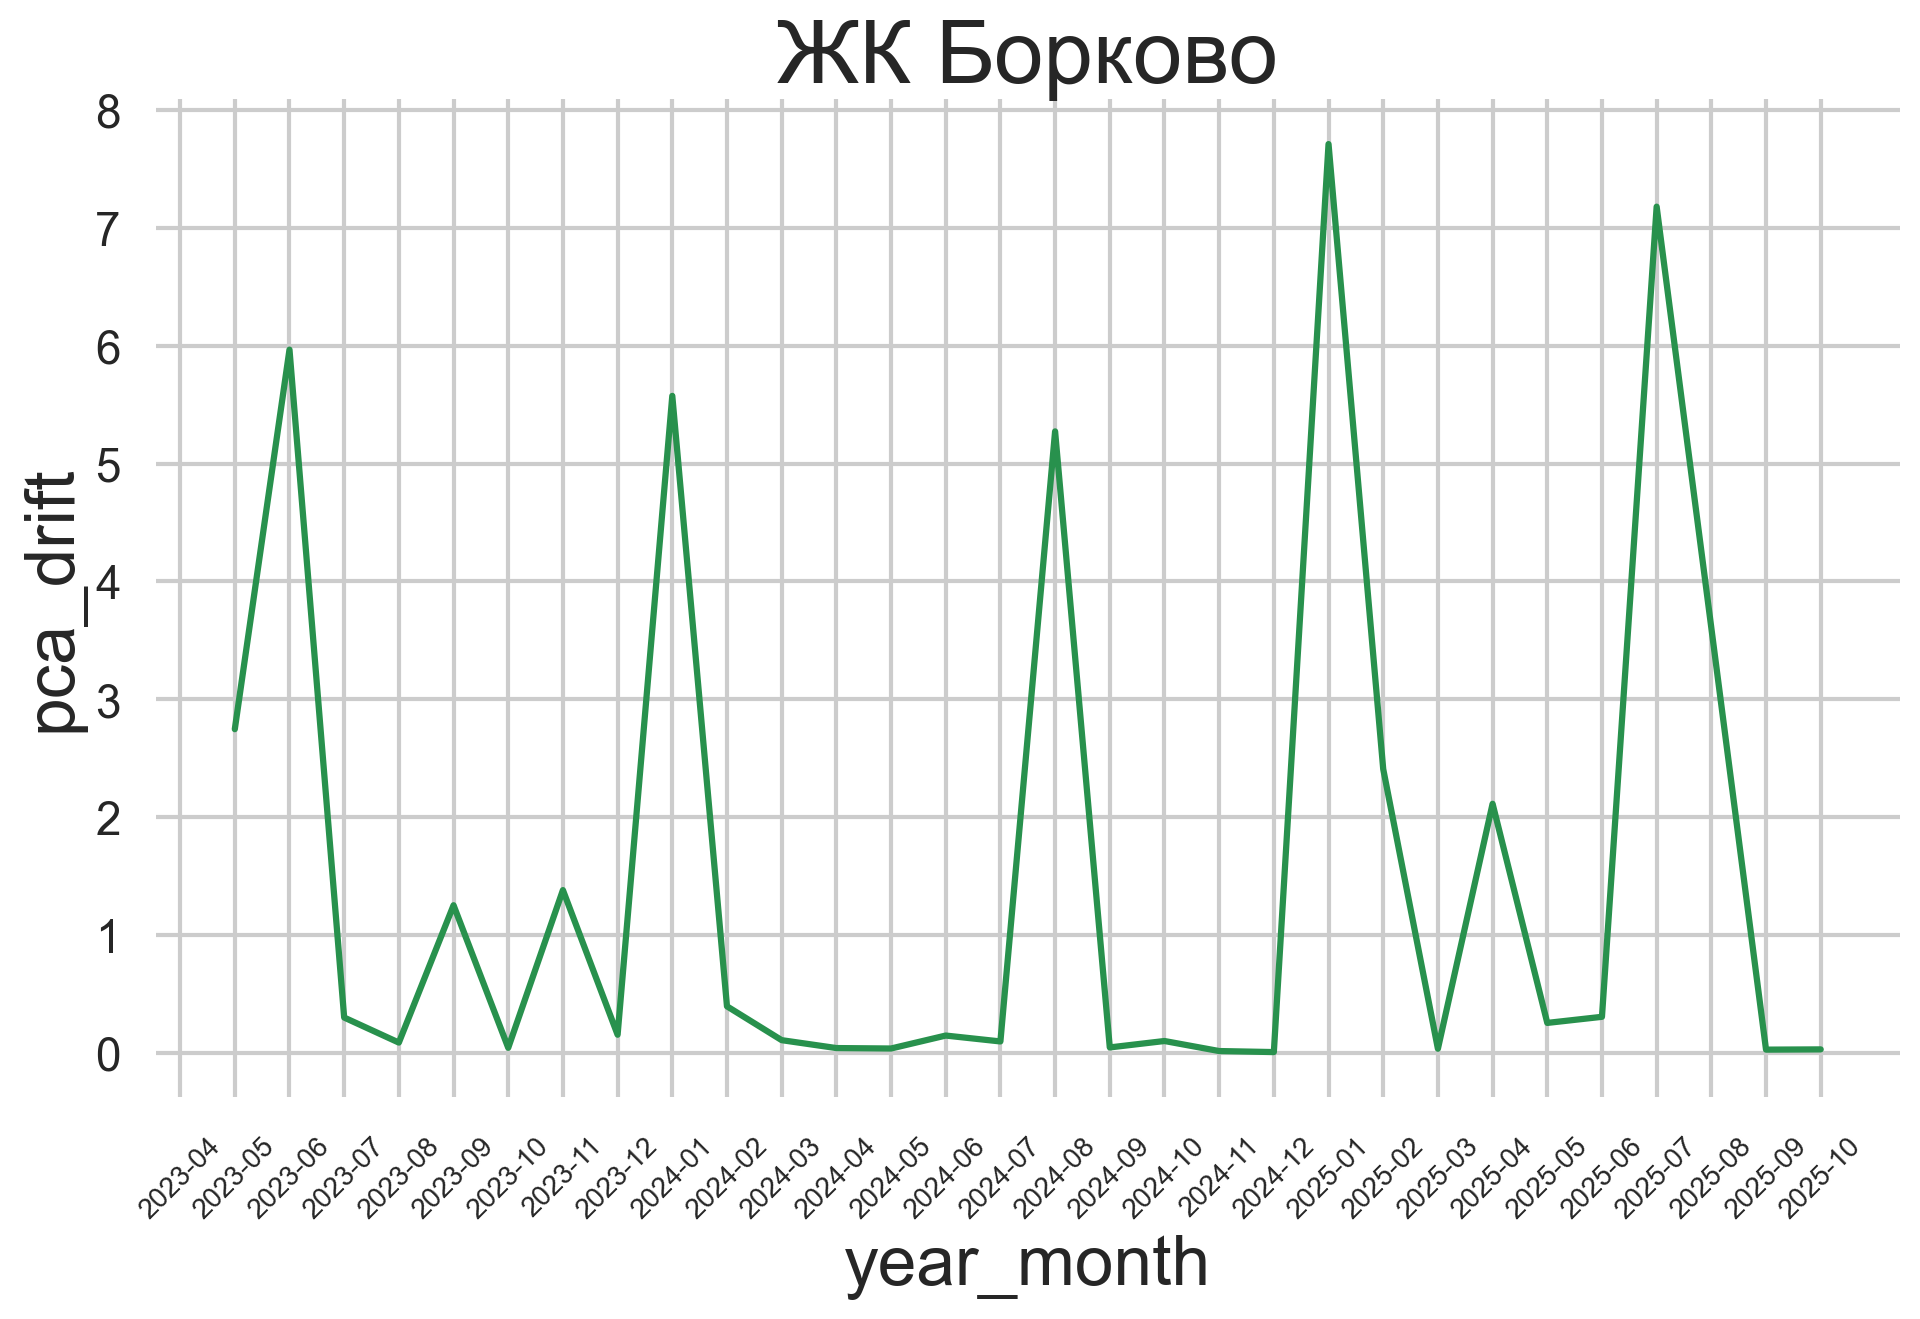

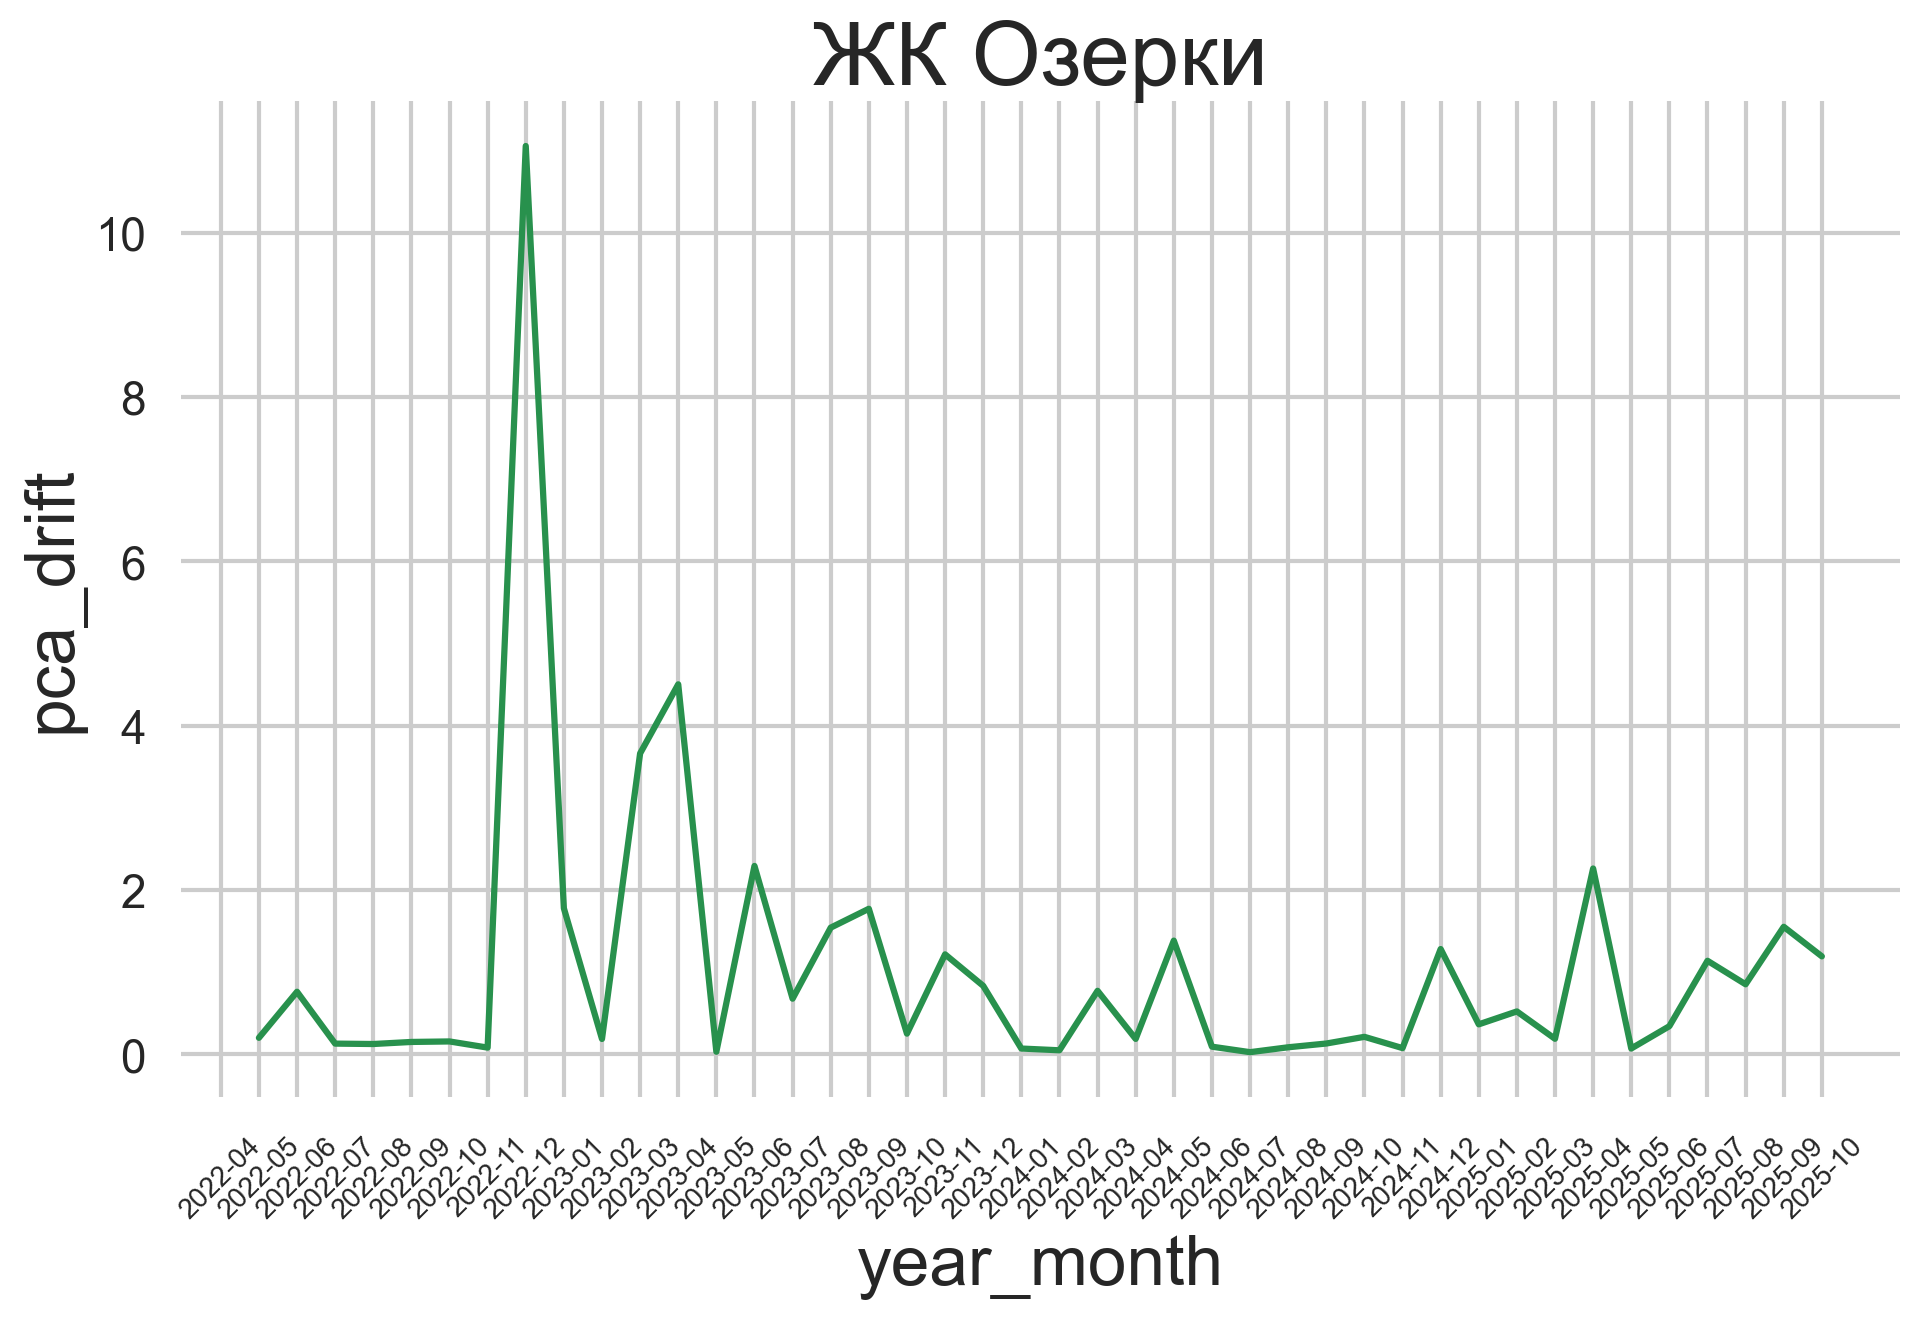

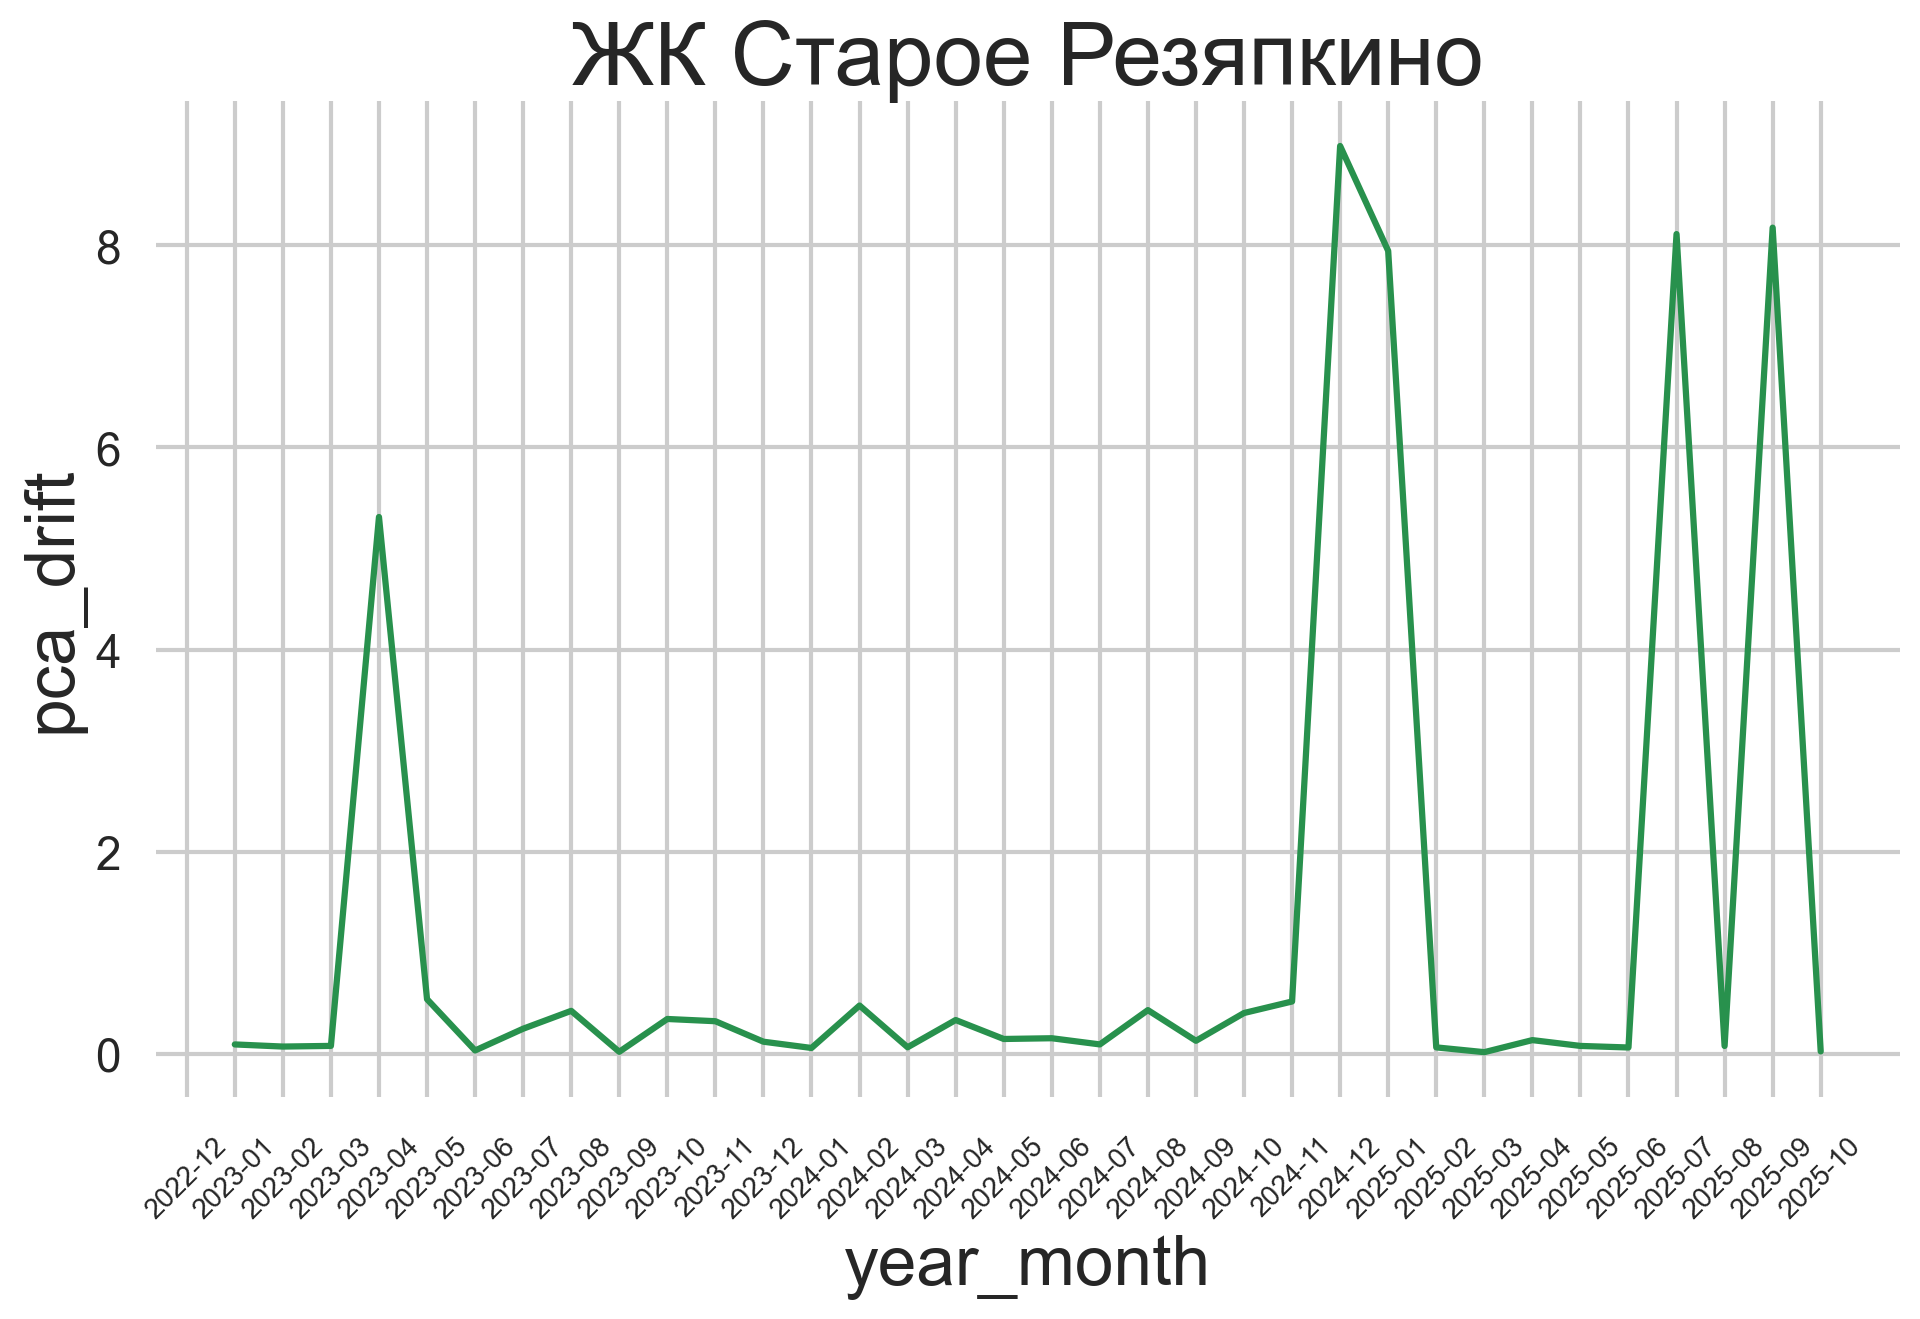

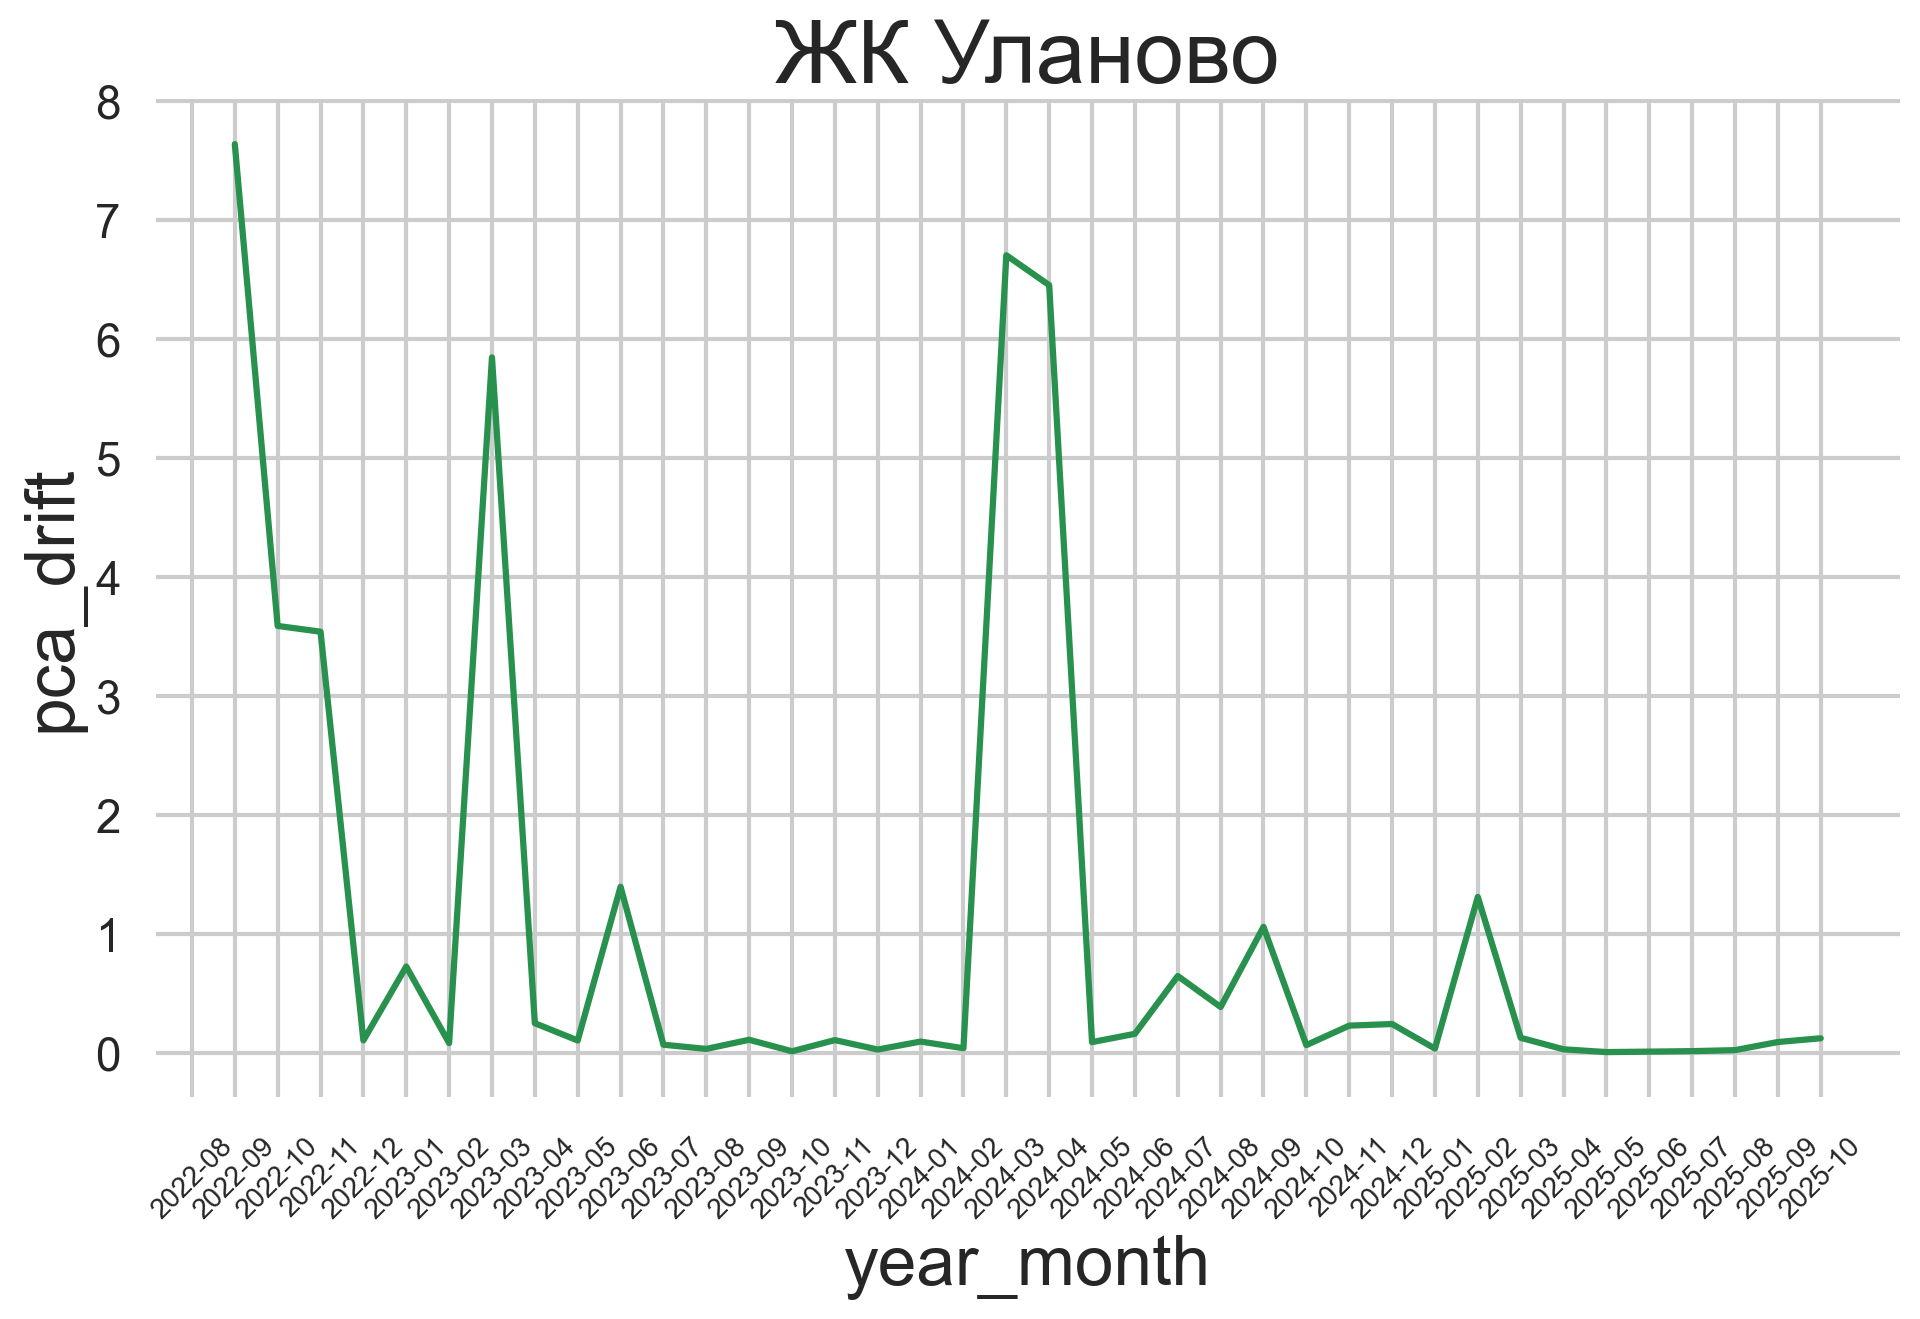

In [70]:
for farm in s.head(10)['FarmName']:
    plt.subplots()
    sns.lineplot(data=monthly_vectors[monthly_vectors['FarmName'] == farm], x='year_month', y='pca_drift')
    plt.title(farm)
    plt.xticks(rotation=45, fontsize=10);

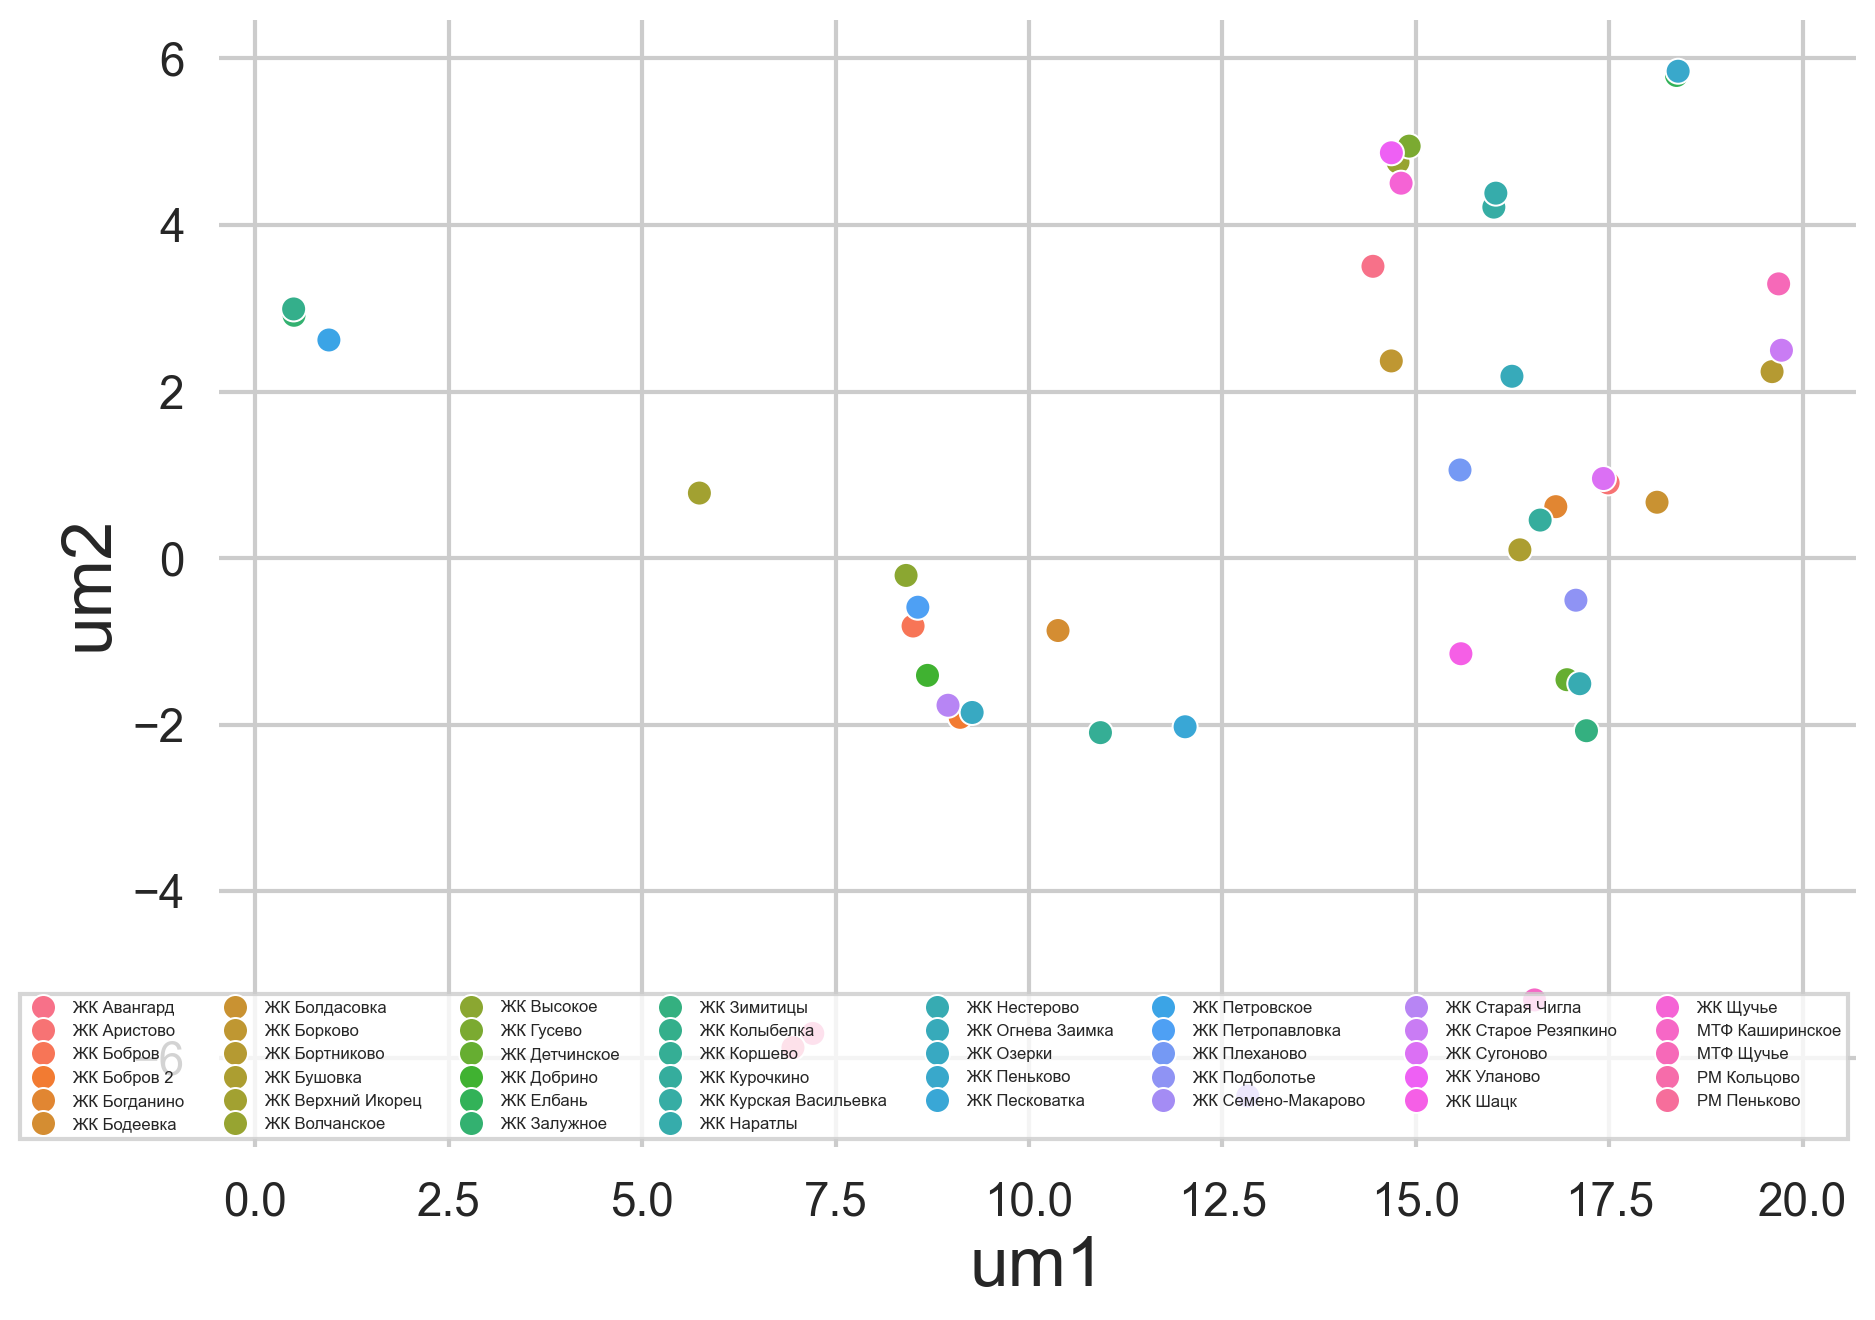

In [71]:
sns.scatterplot(data=monthly_vectors[(monthly_vectors['year_month'] == '2024-01')], x='um1', y='um2', hue='FarmName')
plt.legend(ncol=8, fontsize=6, loc='lower right')

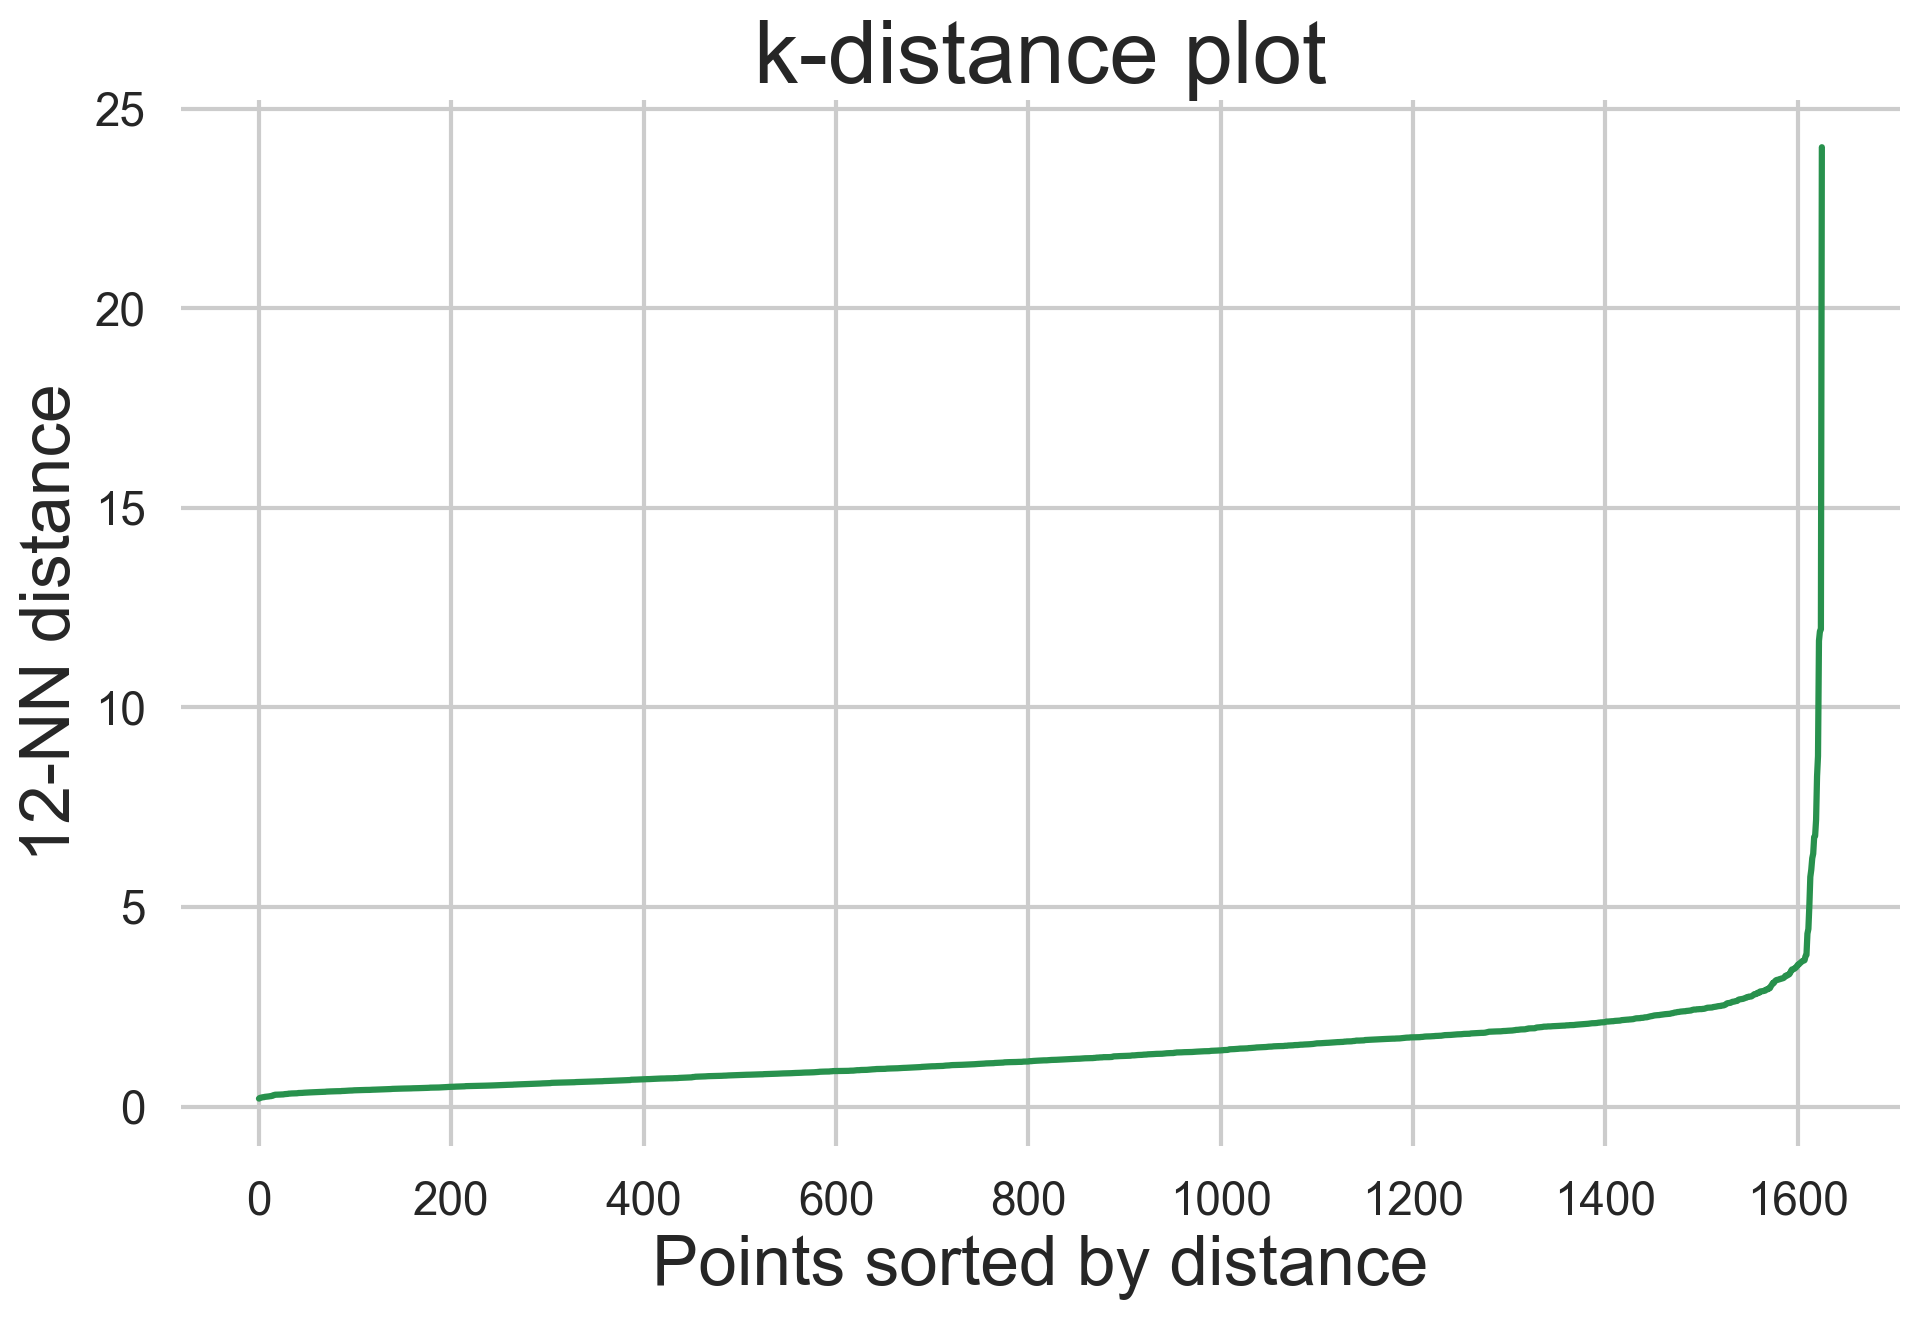

In [72]:
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(clr_df, min_samples=10):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    neigh.fit(clr_df)
    distances, indices = neigh.kneighbors(clr_df)

    k_distances = np.sort(distances[:, -1])

    plt.plot(k_distances)
    plt.ylabel(f"{min_samples}-NN distance")
    plt.xlabel("Points sorted by distance")
    plt.title("k-distance plot")
    plt.grid(True)
    plt.show()

plot_k_distance(X_div_scaled_df, min_samples=12)


### Посмотрим как выглядят наши кластеры

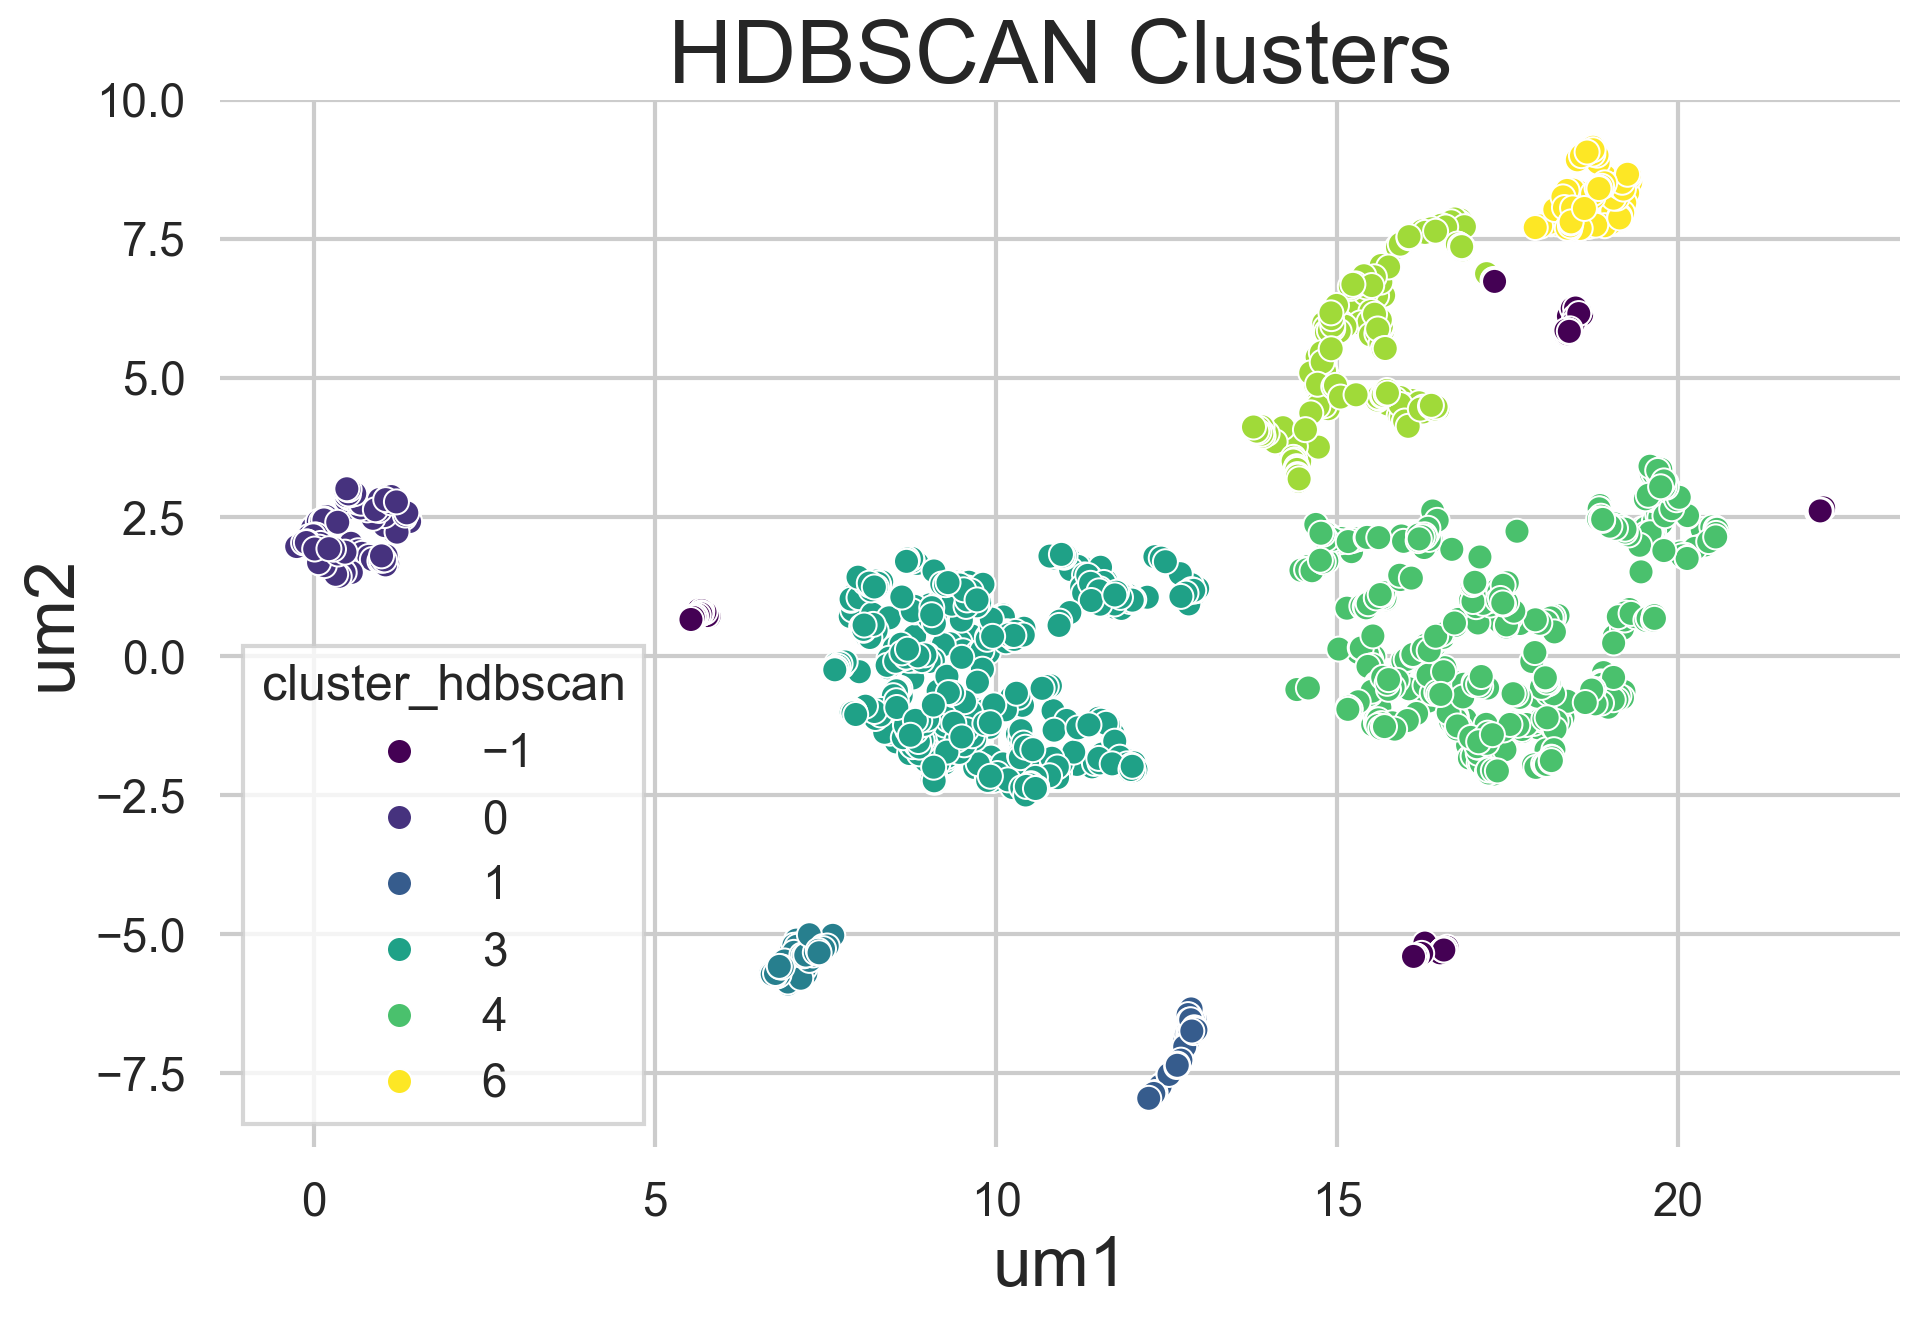

In [73]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=29)
labels = clusterer.fit_predict(U)


monthly_vectors['cluster_hdbscan'] = labels

sns.scatterplot(
    data=monthly_vectors,
    x='um1',
    y='um2',
    hue='cluster_hdbscan',
    palette="viridis",
)
plt.title("HDBSCAN Clusters")
plt.show()


monthly_vectors.to_csv("monthly_vectors.csv", index=False)


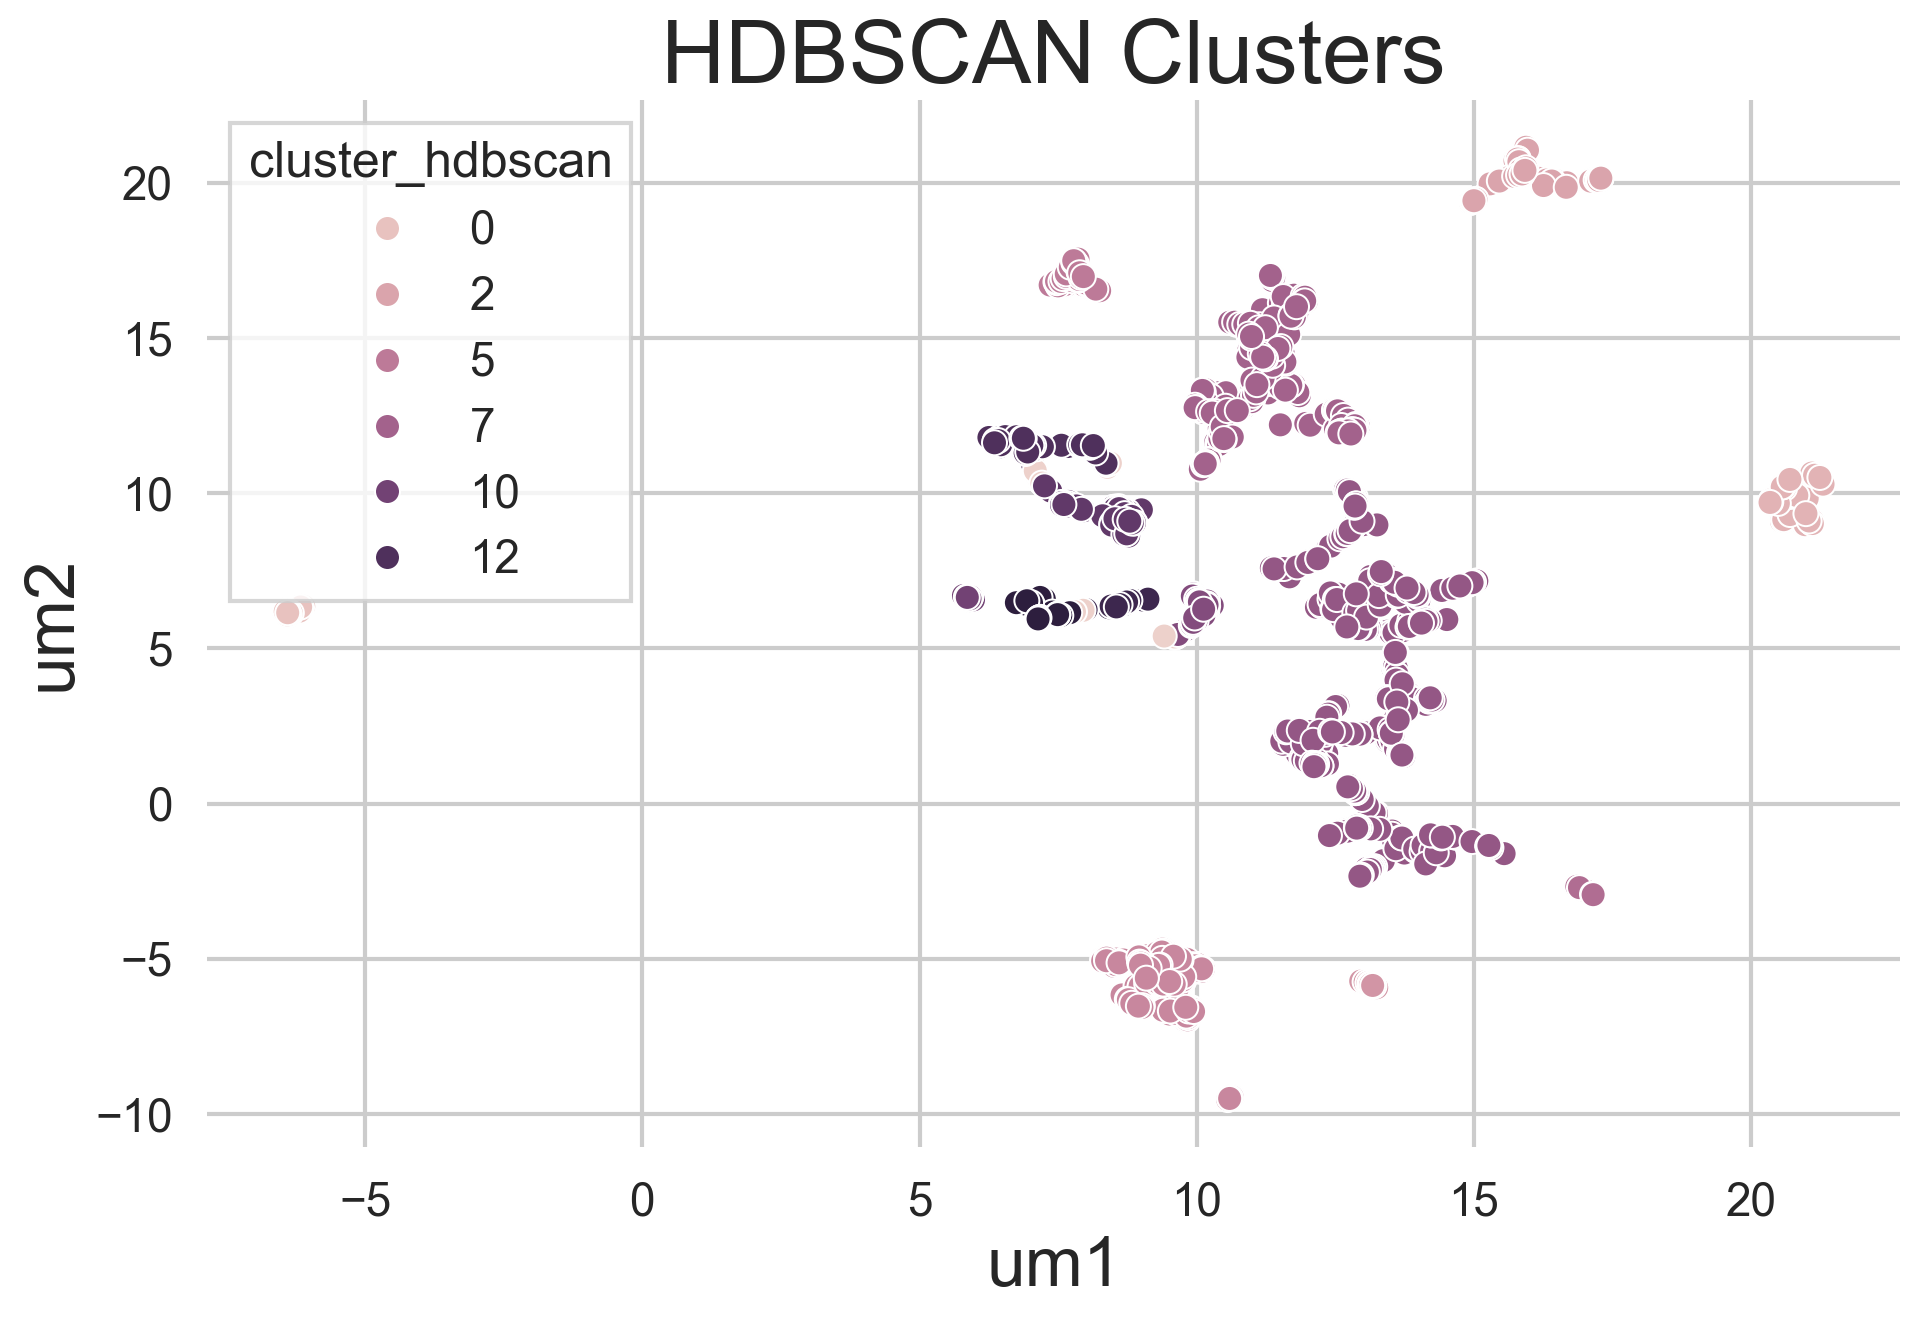

In [75]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
labels = clusterer.fit_predict(U_div)


monthly_div_vectors['cluster_hdbscan'] = labels

sns.scatterplot(
    data=monthly_div_vectors,
    x='um1',
    y='um2',
    hue='cluster_hdbscan',
)
plt.title("HDBSCAN Clusters")
plt.show()


monthly_div_vectors.to_csv("monthly_div_vectors.csv", index=False)


In [41]:
monthly_div_vectors[monthly_div_vectors["cluster_hdbscan"] == 14]

Empty DataFrame
Columns: [year_month, FarmName, byproducts, compound_feed_calf_replacements, energy_source, fat_oils, feed_additives_probiotics, forage_bulk, medications, minerals_buffers, premix_feed, protein_source, wet_ingredients_water, yeast_products, dist_to_center_euclid, dist_to_center_manhattan, um1, um2, cluster_hdbscan]
Index: []

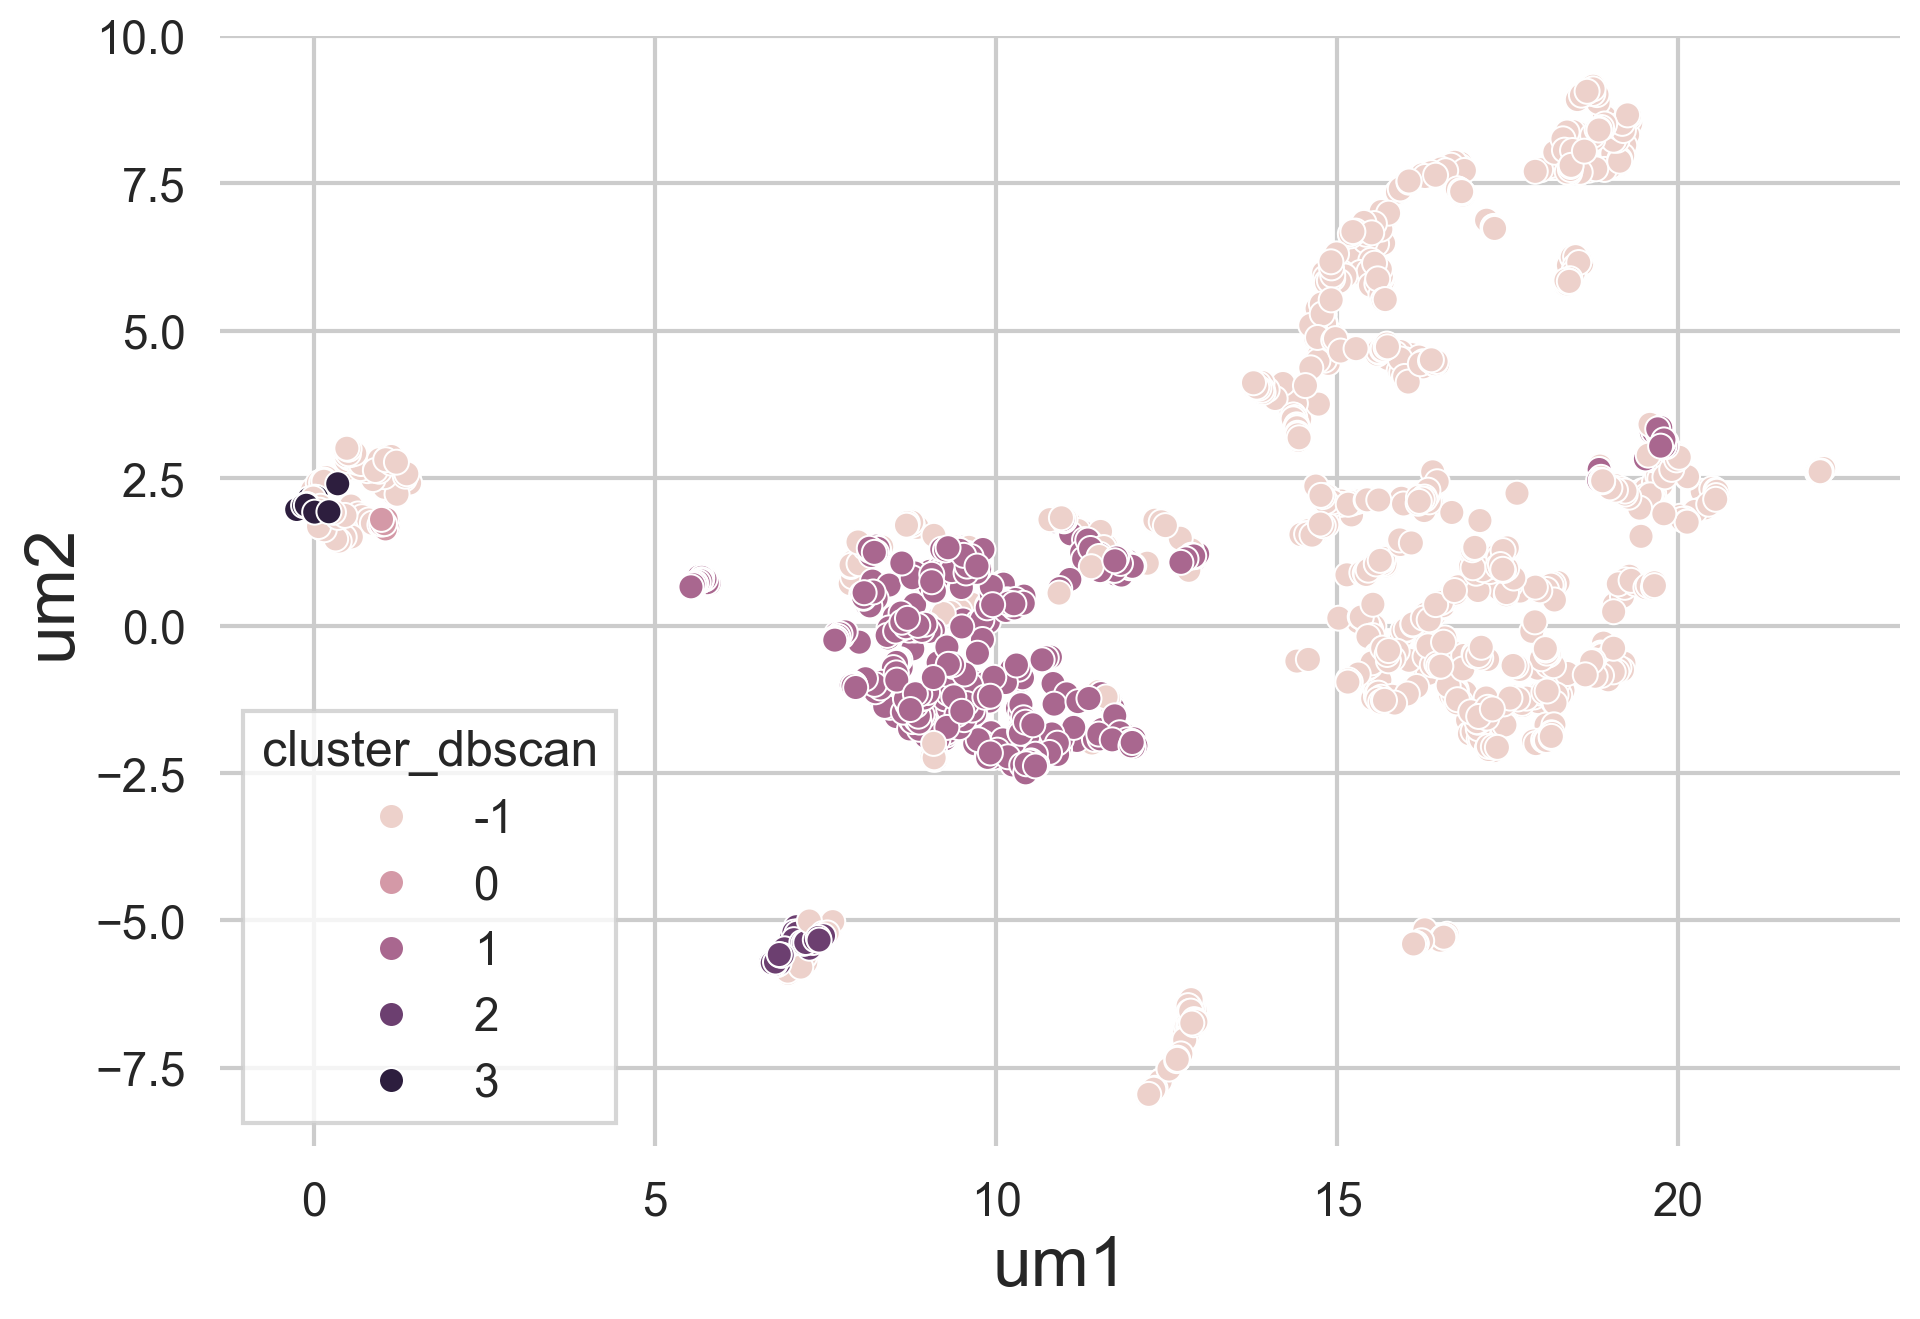

In [42]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1, min_samples=14)
labels = db.fit_predict(X_scaled_df)

monthly_vectors['cluster_dbscan'] = labels
sns.scatterplot(data=monthly_vectors, x='um1', y='um2', hue="cluster_dbscan")
plt.show()
monthly_vectors.to_csv("monthly_vectors.csv")

In [43]:
monthly_vectors

ingredient_group year_month           FarmName  byproducts  \
0                   2022-01         ЖК Добрино    0.000000   
1                   2022-01         ЖК Коршево    0.000000   
2                   2022-02        ЖК Бодеевка    0.000000   
3                   2022-02  ЖК Верхний Икорец    0.000000   
4                   2022-02         ЖК Высокое    0.000000   
...                     ...                ...         ...   
1725                2025-10        РМ Кольцово    0.721447   
1726                2025-10        РМ Пеньково    1.233179   
1727                2025-10          РМ Поляна    0.849197   
1728                2025-10        РМ Торопово    0.917100   
1729                2025-10           ЭФ Родня    0.000000   

ingredient_group  compound_feed_calf_replacements  energy_source  fat_oils  \
0                                        2.443405       3.042668  0.100609   
1                                        2.843560       3.475203  0.130497   
2                                        2.551410       3.797562  0.083673   
3                                        1.625360       2.822767  0.061960   
4                                        2.690139       6.061484  0.129629   
...                                           ...            ...       ...   
1725                                     1.853074       0.768064  0.000000   
1726                                     1.910801       0.365862  0.000000   
1727                                     2.383007       0.861422  0.000000   
1728                                     0.000000       0.753350  0.000000   
1729                                     0.000000       0.000000  0.000000   

ingredient_group  feed_additives_probiotics  forage_bulk  medications  \
0                                  0.063965    20.326100     0.031507   
1                                  0.315463    19.497481     0.000000   
2                                  0.377359    17.150380     0.026529   
3                                  0.000000    16.432382     0.000000   
4                                  0.255193    23.464573     0.097194   
...                                     ...          ...          ...   
1725                               0.001683    14.749873     0.050412   
1726                               0.000000    10.944699     0.037800   
1727                               0.000000    12.680457     0.000000   
1728                               0.000000    22.153482     0.000000   
1729                               0.000000    37.020642     0.131322   

ingredient_group  minerals_buffers  premix_feed  protein_source  \
0                         0.051698     0.167850        2.909530   
1                         0.040794     0.132580        3.603738   
2                         0.155312     0.165690        2.840411   
3                         0.056563     0.169696        2.231988   
4                         0.231954     0.185723        4.655053   
...                            ...          ...             ...   
1725                      0.009356     0.196007        1.261460   
1726                      0.000000     0.171092        0.877475   
1727                      0.000000     0.175702        1.198894   
1728                      0.000000     0.205090        1.320500   
1729                      0.224968     0.000000        2.727945   

ingredient_group  wet_ingredients_water  yeast_products  \
0                              2.693400        0.832498   
1                              8.302740        0.000000   
2                              4.121511        1.128109   
3                              4.245658        0.000000   
4                              8.780972        0.000000   
...                                 ...             ...   
1725                           4.693253        0.000000   
1726                           6.376418        0.000000   
1727                           0.000000        0.000000   
1728                           0.000000       

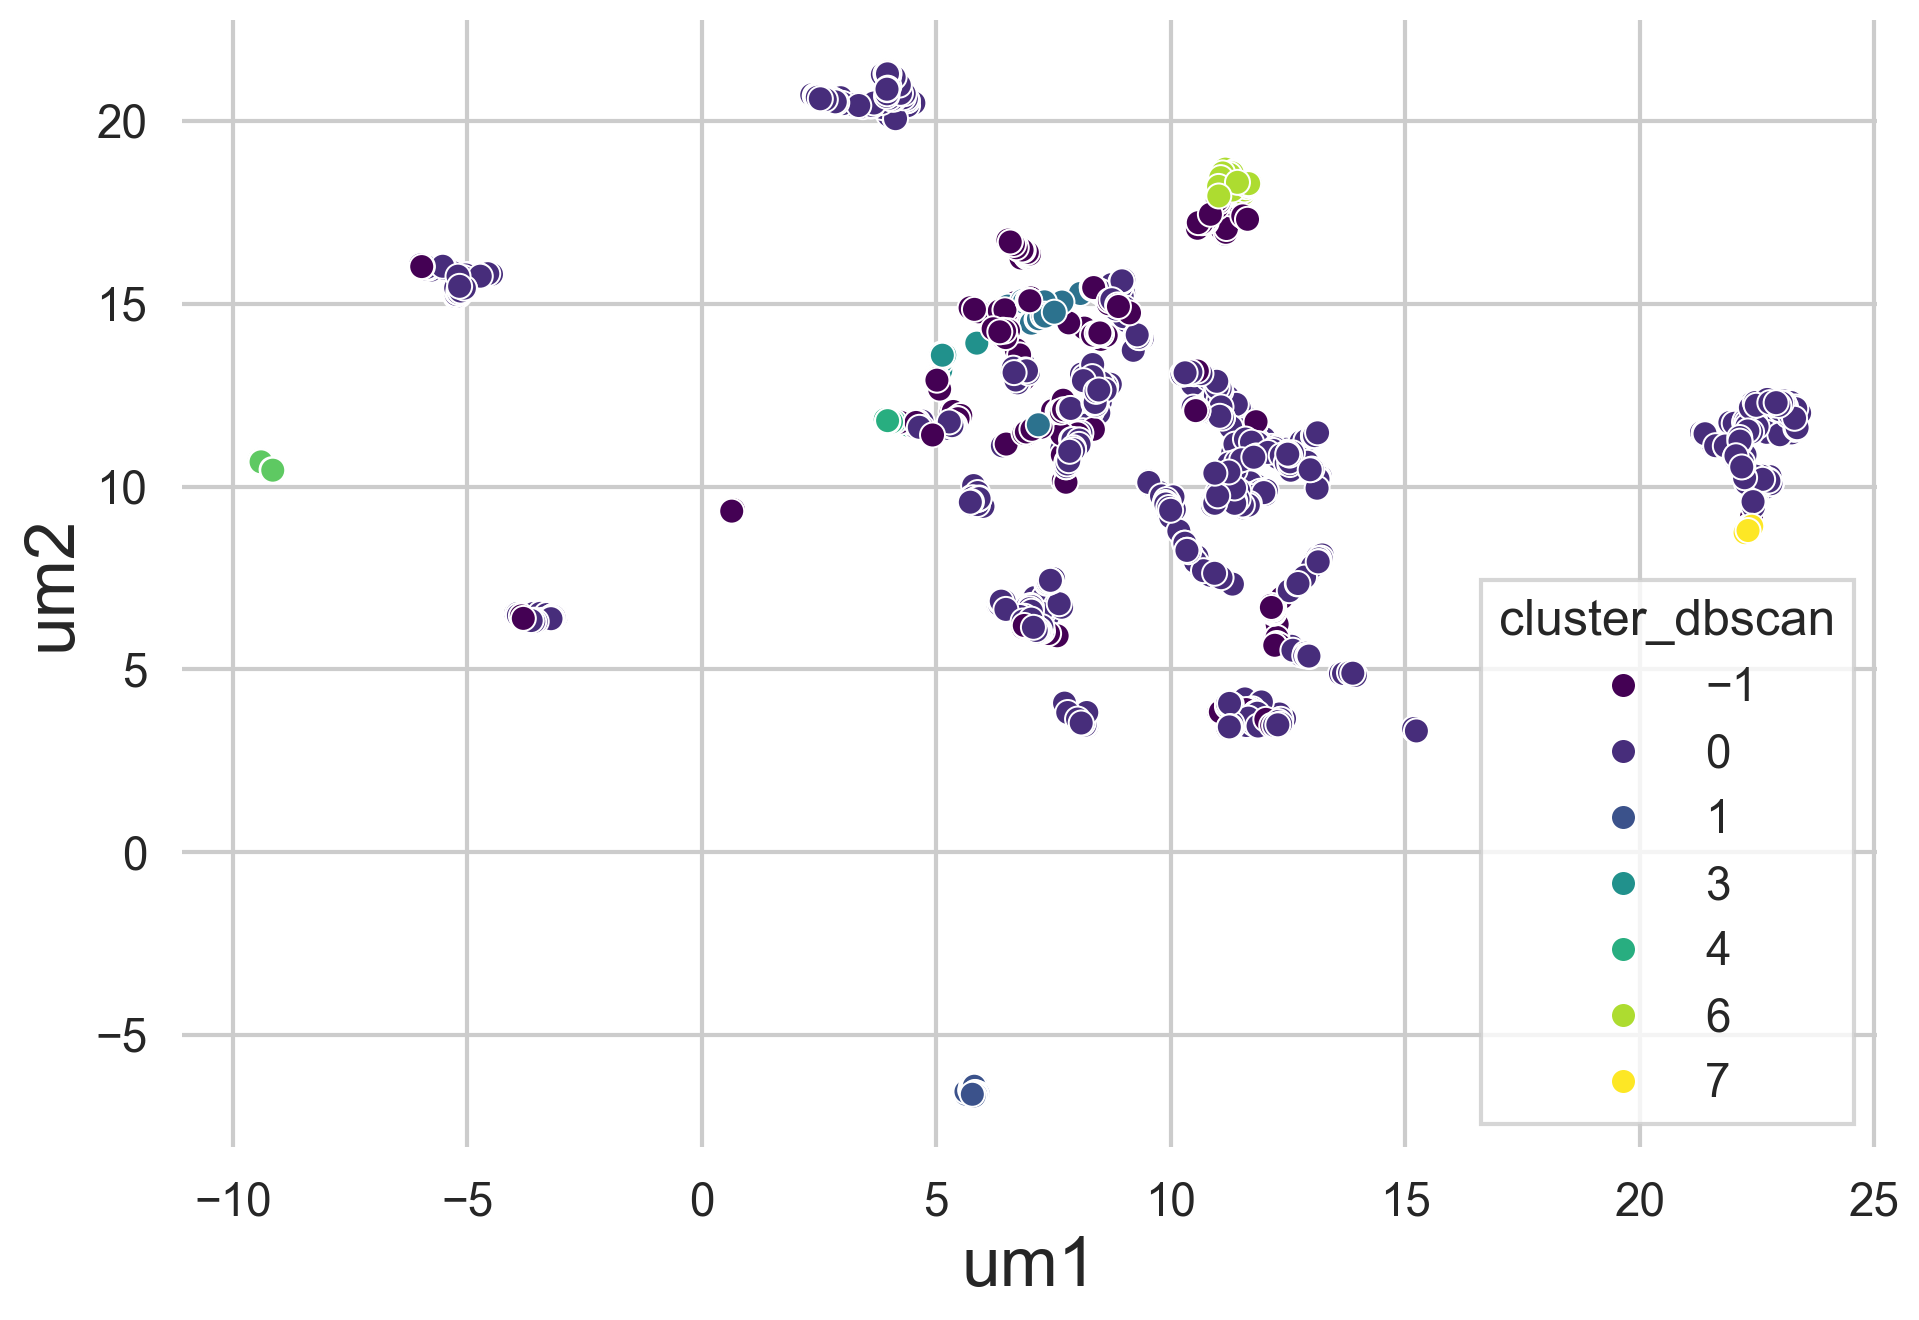

In [44]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=1.5, min_samples=10)
labels = db.fit_predict(X_div_scaled_df)
monthly_div_vectors['cluster_dbscan'] = labels
sns.scatterplot(data=monthly_div_vectors, x='um1', y='um2', hue="cluster_dbscan", palette="viridis")
plt.show()
monthly_div_vectors.to_csv("monthly_div_vectors.csv")

<Axes: xlabel='um1', ylabel='um2'>

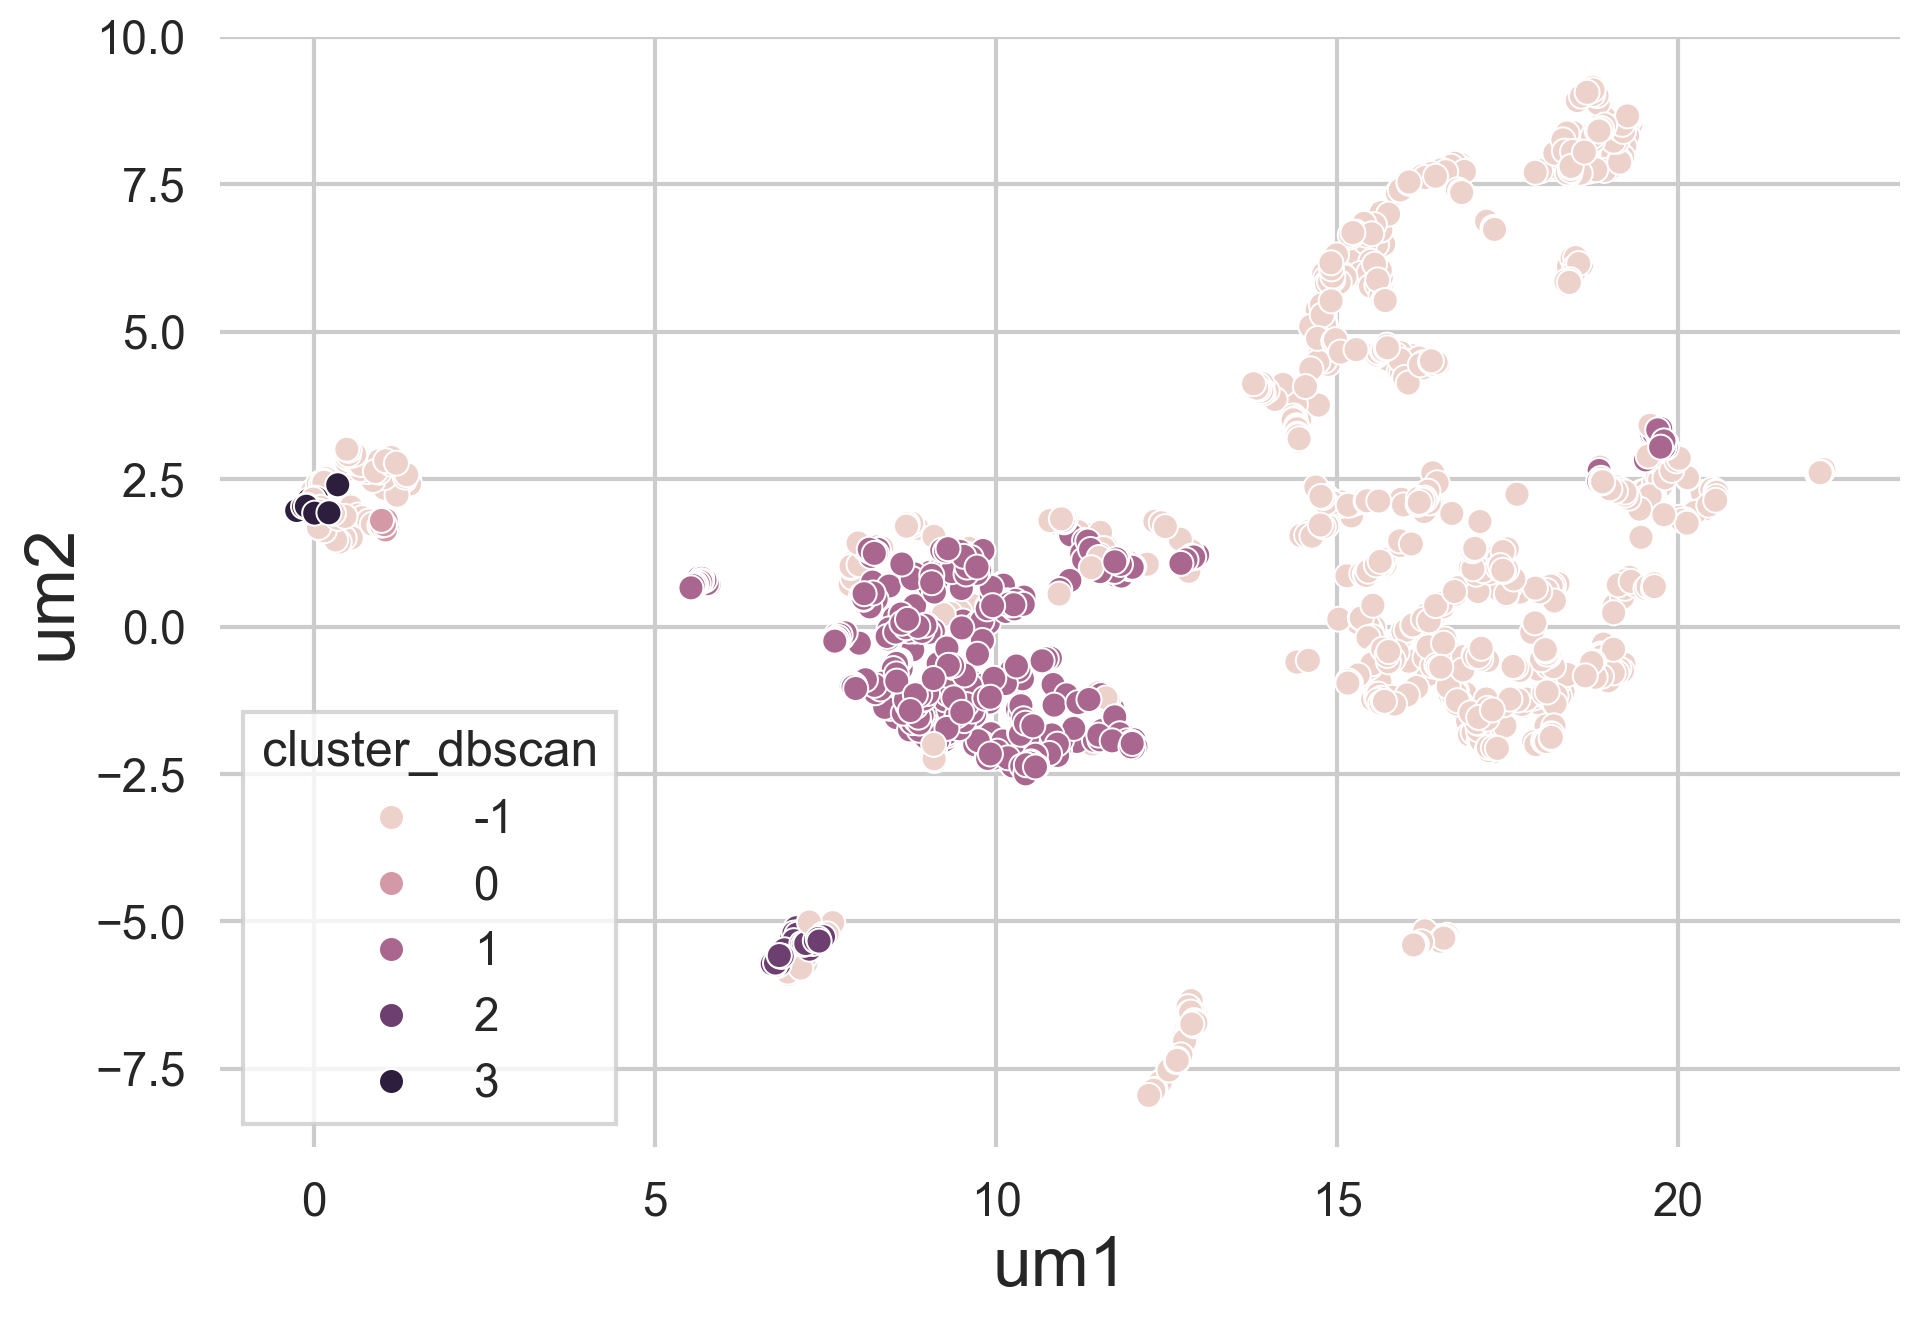

In [45]:
sns.scatterplot(data=monthly_vectors, x='um1', y='um2', hue="cluster_dbscan")

### Это вообще очень прикольный график. Можно прикольно визуализировать перемещени (точечно, может, чтобы исследовать аномалии какие нибудь)

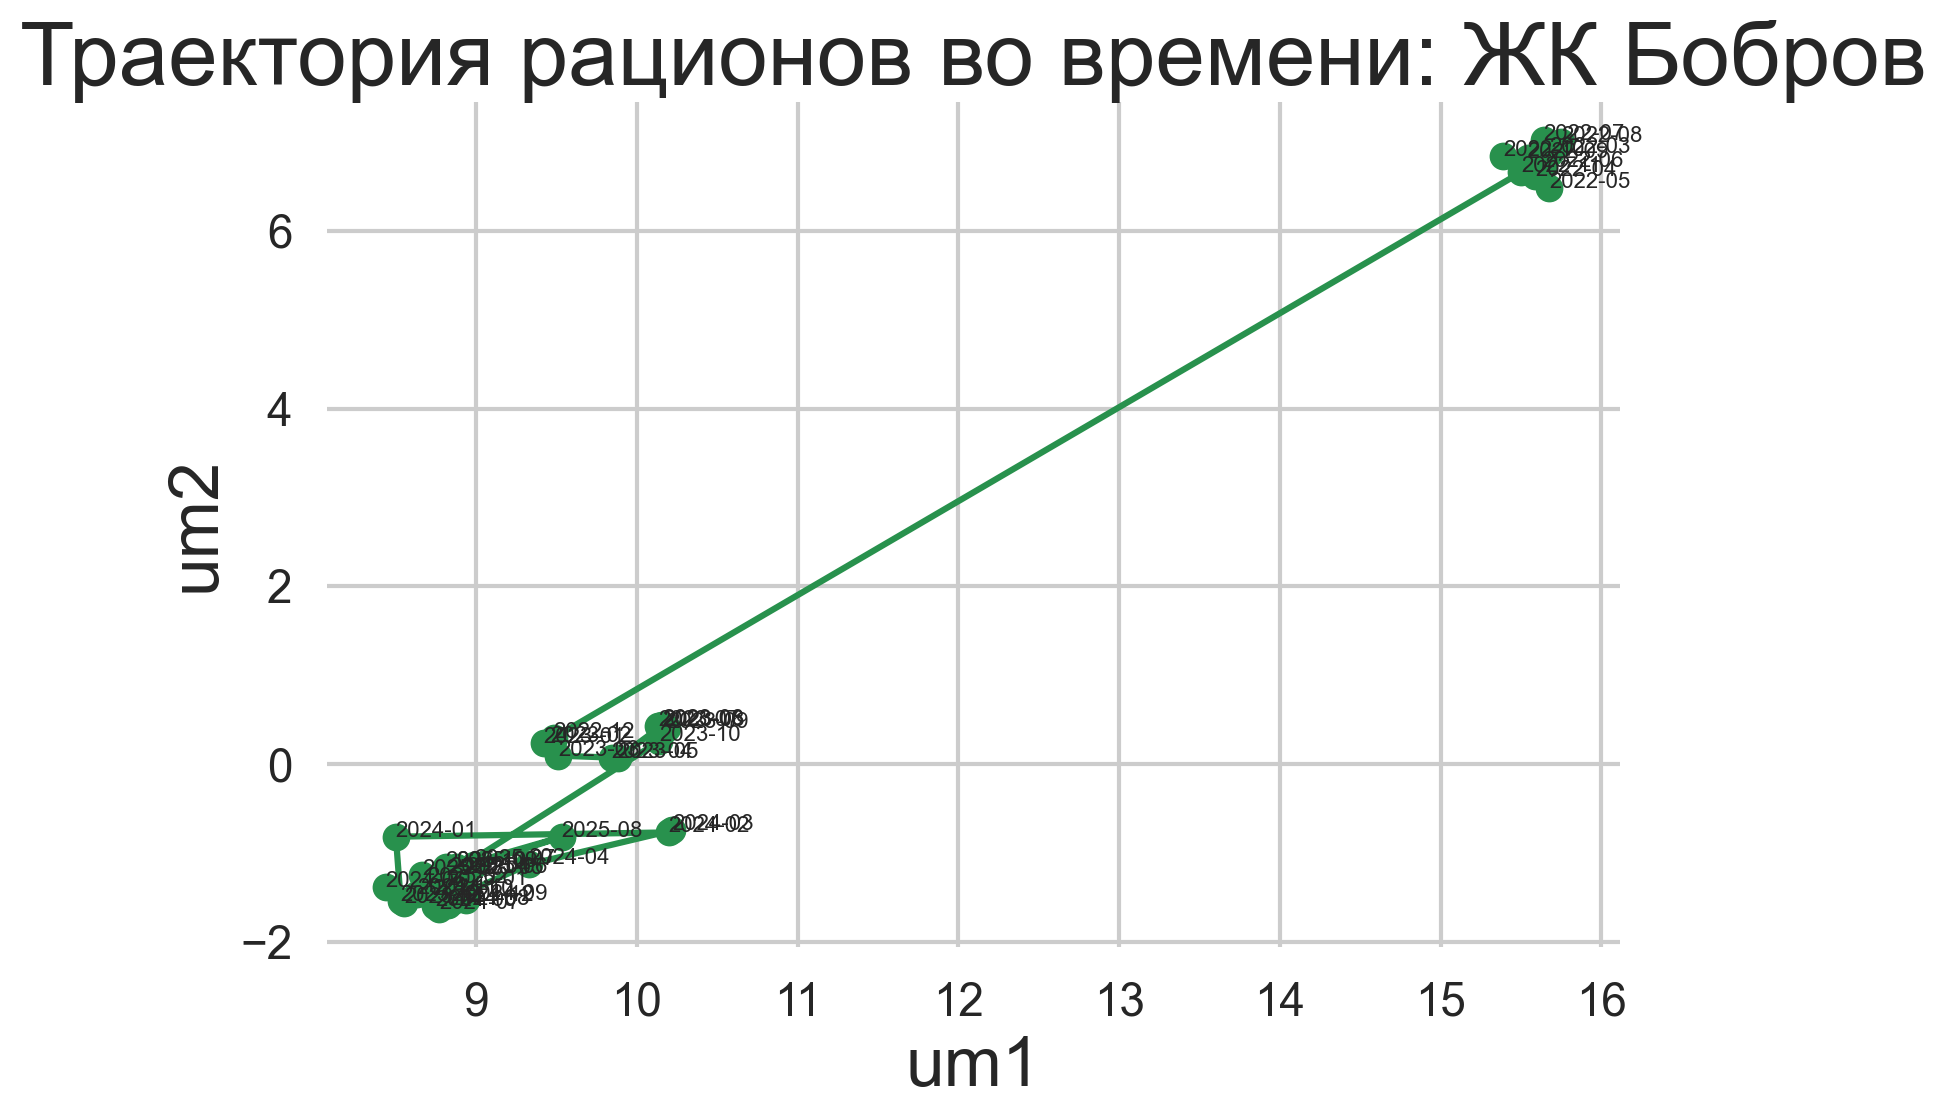

In [46]:
farm_example = 'ЖК Бобров'

df_traj = (monthly_vectors
           .query('FarmName == @farm_example')
           .copy())


df_traj['ym_period'] = df_traj['year_month'].map(pd.Period)
df_traj = df_traj.sort_values('ym_period')

plt.figure(figsize=(8, 6))
plt.plot(df_traj['um1'], df_traj['um2'], marker='o')
for _, row in df_traj.iterrows():
    plt.text(row['um1'], row['um2'], row['year_month'], fontsize=8)

plt.title(f'Траектория рационов во времени: {farm_example}')
plt.xlabel('um1')
plt.ylabel('um2')
plt.grid(True)
plt.show()

In [47]:
# выделим топ-20 самых 'странных' ферма-месяц-группа
top_anomalies = (monthly_vectors
                 .sort_values('dist_to_center_euclid', ascending=False)
                 .head(20)[['year_month', 'FarmName', 'PhysiologicalGroupName', 'dist_to_center_euclid']])

top_anomalies

KeyError: "['PhysiologicalGroupName'] not in index"

### Не думаю, что в для общего случая интересный график, но если строить по конкретным датам, то вполне себе

In [ ]:
monthly_vectors["PhysiologicalGroupName"].unique()

array(['Д0', 'Д1', 'Д2', 'Нетели', 'С1', 'С2', 'Д3'], dtype=object)

IngredientType          Concentrate      Forage  Medication  VitaminMineral  \
PhysiologicalGroupName                                                        
Д0                       252.421928  799.673409    0.079496        6.781316   
Д1                       375.770616  891.888717    0.000000        6.560476   
Д2                       321.058315  915.417327    0.000000        8.655070   
Д3                        86.580850  999.479424    0.000000        3.721065   
Нетели                    72.707780  717.250829    0.000000        5.663607   

IngredientType               Water  
PhysiologicalGroupName              
Д0                       63.095531  
Д1                      124.365883  
Д2                      102.060262  
Д3                        3.587154  
Нетели                    6.741476

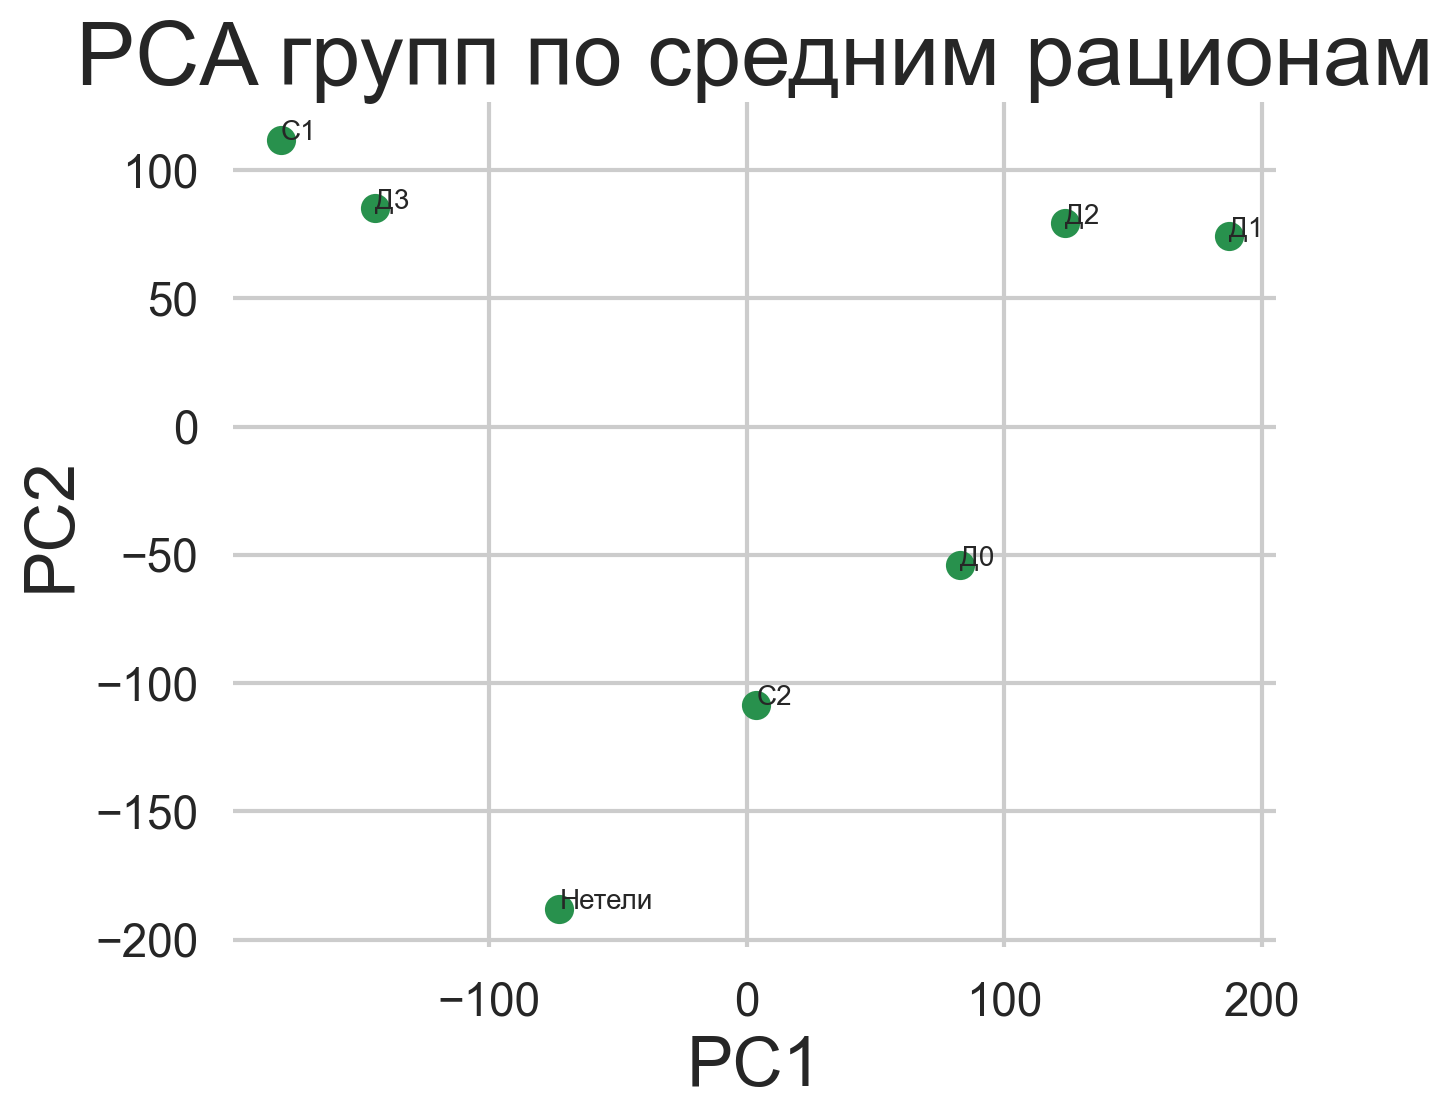

In [ ]:
# средние векторы рационов для каждой группы
group_profiles = (monthly_vectors
                  .groupby('PhysiologicalGroupName')[feature_cols]
                  .mean())

display(group_profiles.head())

pca_groups = PCA(n_components=2, random_state=42)
coords_groups = pca_groups.fit_transform(group_profiles.values)

df_groups_pca = pd.DataFrame(coords_groups, columns=['um1', 'um2'],
                              index=group_profiles.index)

plt.figure(figsize=(7, 6))
plt.scatter(df_groups_pca['um1'], df_groups_pca['um2'])
for grp, row in df_groups_pca.iterrows():
    plt.text(row['um1'], row['um2'], grp, fontsize=10)

plt.title('PCA групп по средним рационам')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.show()

In [ ]:
monthly_vectors['ym_period'] = monthly_vectors['year_month'].map(pd.Period)
monthly_vectors = monthly_vectors.sort_values(['FarmName', 'PhysiologicalGroupName', 'ym_period'])

### Дальше тут можно построить тоже интересный график соседей, не думаю, что он будет сильно информативен, но может какие нибудь интересные моменты показать может

In [ ]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 6  

nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
nn.fit(X_scaled)

distances, indices = nn.kneighbors(X_scaled)

N = 10 
rows = []
for i in range(N):
    base = monthly_vectors.iloc[i]
    for k in range(1, n_neighbors):
        j = indices[i, k]
        neigh = monthly_vectors.iloc[j]
        rows.append({
            'base_year_month': base['year_month'],
            'base_farm': base['FarmName'],
            'base_group': base['PhysiologicalGroupName'],
            'neighbor_rank': k,
            'neighbor_year_month': neigh['year_month'],
            'neighbor_farm': neigh['FarmName'],
            'neighbor_group': neigh['PhysiologicalGroupName'],
            'distance': distances[i, k]
        })

neighbors_df = pd.DataFrame(rows)
neighbors_df.head(20)

base_year_month    base_farm base_group  neighbor_rank neighbor_year_month  \
0          2023-03  ЖК Авангард         Д0              1             2025-05   
1          2023-03  ЖК Авангард         Д0              2             2025-06   
2          2023-03  ЖК Авангард         Д0              3             2024-08   
3          2023-03  ЖК Авангард         Д0              4             2025-08   
4          2023-03  ЖК Авангард         Д0              5             2025-01   
5          2023-04  ЖК Авангард         Д0              1             2025-07   
6          2023-04  ЖК Авангард         Д0              2             2025-09   
7          2023-04  ЖК Авангард         Д0              3             2023-09   
8          2023-04  ЖК Авангард         Д0              4             2025-09   
9          2023-04  ЖК Авангард         Д0              5             2022-12   
10         2023-05  ЖК Авангард         Д0              1             2023-01   
11         2023-05  ЖК Авангард         Д0              2             2024-02   
12         2023-05  ЖК Авангард         Д0              3             2023-08   
13         2023-05  ЖК Авангард         Д0              4             2024-09   
14         2023-05  ЖК Авангард         Д0              5             2023-08   
15         2023-06  ЖК Авангард         Д0              1             2025-04   
16         2023-06  ЖК Авангард         Д0              2             2025-02   
17         2023-06  ЖК Авангард         Д0              3             2022-09   
18         2023-06  ЖК Авангард         Д0              4             2023-05   
19         2023-06  ЖК Авангард         Д0              5             2022-10   

       neighbor_farm neighbor_group  distance  
0          МТФ Щучье         Нетели  0.220817  
1      ЖК Бортниково         Нетели  0.227339  
2      ЖК Бортниково             С1  0.248171  
3           ЭФ Родня             Д0  0.250114  
4          ЖК Бобров         Нетели  0.264488  
5        ЖК Авангард             Д0  0.128756  
6         ЖК Высокое             С2  0.203792  
7         ЖК Добрино             С1  0.226205  
8          МТФ Щучье             Д1  0.227918  
9       ЖК Богданино             С1  0.250181  
10        ЖК Уланово             С1  0.197403  
11        ЖК Коршево             Д1  0.282187  
12         ЖК Бобров         Нетели  0.323464  
13      ЖК Богданино         Нетели  0.377450  
14      ЖК Колыбелка             Д2  0.409169  
15  ЖК Петропавловка             Д3  0.057037  
16        ЖК Бушовка         Нетели  0.065426  
17         ЖК Гусево             Д2  0.069461  
18     ЖК Подболотье             С2  0.071365  
19         МТФ Щучье             С2  0.073202

### Тут можно посмотреть "странные" точки, позже изучить их детальнее

In [ ]:
# Странные точки по расстоянию до центра
threshold_center = monthly_vectors['dist_to_center_euclid'].quantile(0.99)
suspect_by_center = monthly_vectors[monthly_vectors['dist_to_center_euclid'] > threshold_center]

print('Подозрительные точки (по расстоянию до центра):')
display(suspect_by_center[['year_month', 'FarmName', 'PhysiologicalGroupName', 'dist_to_center_euclid']].head(30))

# Странные скачки во времени (по temporal distance)
threshold_temporal = dist_temporal_euclid['distance'].quantile(0.99)
suspect_jumps = dist_temporal_euclid[dist_temporal_euclid['distance'] > threshold_temporal]

print('Подозрительные скачки во времени:')
display(suspect_jumps.head(30))

Подозрительные точки (по расстоянию до центра):


IngredientType year_month       FarmName PhysiologicalGroupName  \
871               2022-10      ЖК Бобров                     Д2   
2039              2023-05    ЖК Бобров 2                     Д1   
2526              2023-07  ЖК Бортниково                     Д1   
919               2022-10     ЖК Высокое                     Д1   
7421              2025-02      ЖК Гусево                     Д0   
7688              2025-03      ЖК Гусево                     Д0   
7946              2025-04      ЖК Гусево                     Д0   
8206              2025-05      ЖК Гусево                     Д0   
8470              2025-06      ЖК Гусево                     Д0   
8734              2025-07      ЖК Гусево                     Д0   
8997              2025-08      ЖК Гусево                     Д0   
9263              2025-09      ЖК Гусево                     Д0   
9523              2025-10      ЖК Гусево                     Д0   
7159              2025-01      ЖК Гусево                     Д1   
7422              2025-02      ЖК Гусево                     Д1   
7689              2025-03      ЖК Гусево                     Д1   
7947              2025-04      ЖК Гусево                     Д1   
8207              2025-05      ЖК Гусево                     Д1   
8471              2025-06      ЖК Гусево                     Д1   
8735              2025-07      ЖК Гусево                     Д1   
7160              2025-01      ЖК Гусево                     Д2   
7423              2025-02      ЖК Гусево                     Д2   
7690              2025-03      ЖК Гусево                     Д2   
7948              2025-04      ЖК Гусево                     Д2   
8208              2025-05      ЖК Гусево                     Д2   
8472              2025-06      ЖК Гусево                     Д2   
8736              2025-07      ЖК Гусево                     Д2   
930               2022-10      ЖК Гусево                     С1   
5086              2024-05  ЖК Детчинское                     Д1   
5342              2024-06  ЖК Детчинское                     Д1   

IngredientType  dist_to_center_euclid  
871                          5.341320  
2039                         5.036906  
2526                         5.339432  
919                          5.043654  
7421                        13.141016  
7688                        27.557588  
7946                        27.146474  
8206                        27.002439  
8470                        27.447553  
8734                        27.503787  
8997                        27.712846  
9263                        27.703907  
9523                        19.686514  
7159                         7.685257  
7422                         7.421791  
7689                         8.800120  
7947                         9.532270  
8207                        10.970943  
8471                        11.587361  
8735                        11.689411  
7160                         7.723029  
7423                         7.208331  
7690                         7.984892  
7948                         9.601781  
8208                        11.122552  
8472                        11.018216  
8736                        10.468498  
930                          5.044702  
5086                         8.225043  
5342                        12.521344

Подозрительные скачки во времени:


FarmName PhysiologicalGroupName year_month_t year_month_t1  \
0           ЖК Авангард                     Д0      2023-03       2023-04   
93          ЖК Авангард                     Д3      2023-03       2023-04   
203         ЖК Аристово                     Д0      2022-12       2023-01   
204         ЖК Аристово                     Д0      2023-01       2023-02   
439           ЖК Бобров                     Д2      2022-09       2022-10   
444           ЖК Бобров                     Д2      2023-02       2023-03   
705         ЖК Бобров 2                     Д3      2022-07       2022-08   
706         ЖК Бобров 2                     Д3      2022-08       2022-09   
987        ЖК Богданино                     Д3      2022-10       2022-11   
1539      ЖК Болдасовка                     С2      2022-05       2022-06   
1540      ЖК Болдасовка                     С2      2022-06       2022-07   
1612         ЖК Борково                     Д3      2023-05       2023-06   
1675      ЖК Бортниково                     Д1      2023-07       2023-08   
1874         ЖК Бушовка                     Д1      2023-01       2023-02   
2118  ЖК Верхний Икорец                     Д1      2022-02       2022-03   
2173  ЖК Верхний Икорец                     Д2      2023-01       2023-02   
2381      ЖК Волчанское                     Д1      2022-03       2022-04   
2427      ЖК Волчанское                     Д2      2023-10       2023-11   
2466      ЖК Волчанское                     Д3      2025-05       2025-06   
2931          ЖК Гусево                     Д0      2025-01       2025-02   
2932          ЖК Гусево                     Д0      2025-02       2025-03   
2939          ЖК Гусево                     Д0      2025-09       2025-10   
2940          ЖК Гусево                     Д1      2022-08       2022-09   
2967          ЖК Гусево                     Д1      2024-11       2024-12   
2968          ЖК Гусево                     Д1      2024-12       2025-01   
2975          ЖК Гусево                     Д1      2025-07       2025-08   
2978          ЖК Гусево                     Д2      2022-08       2022-09   
3005          ЖК Гусево                     Д2      2024-11       2024-12   
3006          ЖК Гусево                     Д2      2024-12       2025-01   
3013          ЖК Гусево                     Д2      2025-07       2025-08   

       distance     metric  
0      3.485454  euclidean  
93     4.791480  euclidean  
203    3.641729  euclidean  
204    3.624742  euclidean  
439    5.684900  euclidean  
444    3.756257  euclidean  
705    3.451304  euclidean  
706    4.420237  euclidean  
987    3.750804  euclidean  
1539   6.375140  euclidean  
1540   3.957188  euclidean  
1612   3.673093  euclidean  
1675   3.445498  euclidean  
1874   3.927081  euclidean  
2118   5.235336  euclidean  
2173   3.340832  euclidean  
2381   3.339002  euclidean  
2427   3.528079  euclidean  
2466   3.635541  euclidean  
2931  13.137643  euclidean  
2932  14.468036  euclidean  
2939   8.115734  euclidean  
2940   3.499415  euclidean  
2967   3.866354  euclidean  
2968   4.325786  euclidean  
2975   9.631397  euclidean  
2978   3.734992  euclidean  
3005   3.594487  euclidean  
3006   4.602204  euclidean  
3013   8.841586  euclidean

In [ ]:
monthly_vectors

IngredientType year_month     FarmName PhysiologicalGroupName  Concentrate  \
1613              2023-03  ЖК Авангард                     Д0    16.249417   
1799              2023-04  ЖК Авангард                     Д0   243.117938   
2022              2023-05  ЖК Авангард                     Д0   249.060458   
2248              2023-06  ЖК Авангард                     Д0   245.885210   
2482              2023-07  ЖК Авангард                     Д0   260.912185   
...                   ...          ...                    ...          ...   
8660              2025-06     ЭФ Родня                     С1     0.000000   
8923              2025-07     ЭФ Родня                     С1     0.000000   
9190              2025-08     ЭФ Родня                     С1     0.000000   
9451              2025-09     ЭФ Родня                     С1     0.000000   
9708              2025-10     ЭФ Родня                     С1     0.000000   

IngredientType       Forage  Medication  VitaminMineral       Water  \
1613              49.454545         0.0        1.903464    0.000000   
1799             748.876939         0.0       28.346610   41.027718   
2022             796.189424         0.0       29.212909   33.116882   
2248             770.751223         0.0       32.303241   46.776849   
2482             759.301155         0.0       36.177907  121.452182   
...                     ...         ...             ...         ...   
8660            1311.857334         0.0        0.000000    0.000000   
8923            1283.474775         0.0        0.000000    0.000000   
9190            1380.954515         0.0        0.000000    0.000000   
9451            1270.068182         0.0        0.000000    0.000000   
9708             767.482704         0.0        0.000000    0.000000   

IngredientType  dist_to_center_euclid  dist_to_center_manhattan      pca1  \
1613                         3.284857                  5.040717 -0.855612   
1799                         1.591862                  2.384261  0.441653   
2022                         1.626363                  2.402540  0.386047   
2248                         1.833777                  2.518866  0.541160   
2482                         2.310571                  3.820993  1.317660   
...                               ...                       ...       ...   
8660                         2.134588                  3.879649 -1.429134   
8923                         2.053086                  3.773681 -1.418175   
9190                         2.341210                  4.137628 -1.455814   
9451                         2.015380                  3.723627 -1.412998   
9708                         1.387717                  2.585299 -1.218938   

IngredientType      pca2  pca_drift  cluster_kmeans ym_period  
1613           -2.327356        NaN               1   2023-03  
1799            0.661964   3.258670               1   2023-04  
2022            0.831846   0.178751               2   2023-05  
2248            0.888924   0.165281               2   2023-06  
2482            0.968236   0.780540               0   2023-07  
...                  ...        ...             ...       ...  
8660            0.920511   0.056618               5   2025-06  
8923            0.845585   0.075723               5   2025-07  
9190            1.102918   0.260071               5   2025-08  
9451            0.810193   0.295840               5   2025-09  
9708           -0.516564   1.340875               1   2025-10  

[9709 rows x 15 columns]

In [ ]:
monthly_vectors.groupby(["FarmName", "year_month"])["cluster_kmeans"].value_counts(normalize=True)

FarmName     year_month  cluster_kmeans
ЖК Авангард  2023-03     1                 1.000000
             2023-04     1                 0.428571
                         2                 0.285714
                         5                 0.285714
             2023-05     2                 0.428571
                                             ...   
ЭФ Родня     2025-07     1                 0.250000
             2025-08     5                 1.000000
             2025-09     5                 0.750000
                         1                 0.250000
             2025-10     1                 1.000000
Name: proportion, Length: 4785, dtype: float64